In [10]:
# Setup
print("Installing system dependencies...")
!apt-get update -qq && apt-get install -y build-essential swig -qq > /dev/null
print("Installing Python packages...")
!pip install -q gymnasium[box2d] mujoco gymnasium-robotics > /dev/null
print("Installation complete.")
!pip install Optuna

Installing system dependencies...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Installing Python packages...
Installation complete.



Using device: cpu
Global seed: 6


Running FINAL training for: CartPole-v1
--- Training for 50 epochs ---
Epoch: 1/50 | Avg Reward: 21.99 | Time: 2.76s
Epoch: 2/50 | Avg Reward: 46.00 | Time: 6.39s
Epoch: 3/50 | Avg Reward: 70.10 | Time: 9.63s
Epoch: 4/50 | Avg Reward: 115.82 | Time: 12.36s
Epoch: 5/50 | Avg Reward: 142.92 | Time: 15.14s
Epoch: 6/50 | Avg Reward: 168.91 | Time: 18.15s
Epoch: 7/50 | Avg Reward: 321.40 | Time: 22.47s
Epoch: 8/50 | Avg Reward: 198.10 | Time: 25.24s
Epoch: 9/50 | Avg Reward: 174.73 | Time: 28.67s
Epoch: 10/50 | Avg Reward: 211.11 | Time: 31.90s
Epoch: 11/50 | Avg Reward: 388.60 | Time: 35.32s
Epoch: 12/50 | Avg Reward: 167.08 | Time: 38.23s
Epoch: 13/50 | Avg Reward: 500.00 | Time: 41.11s
Epoch: 14/50 | Avg Reward: 59.15 | Time: 44.21s
Epoch: 15/50 | Avg Reward: 76.19 | Time: 47.90s
Epoch: 16/50 | Avg Reward: 254.62 | Time: 50.64s
Epoch: 17/50 | Avg Reward: 500.00 | Time: 53.40s
Epoch: 18/50 | Avg Reward: 21.53 | Time: 56.18s
Epoch: 19/50 | Avg Reward: 49

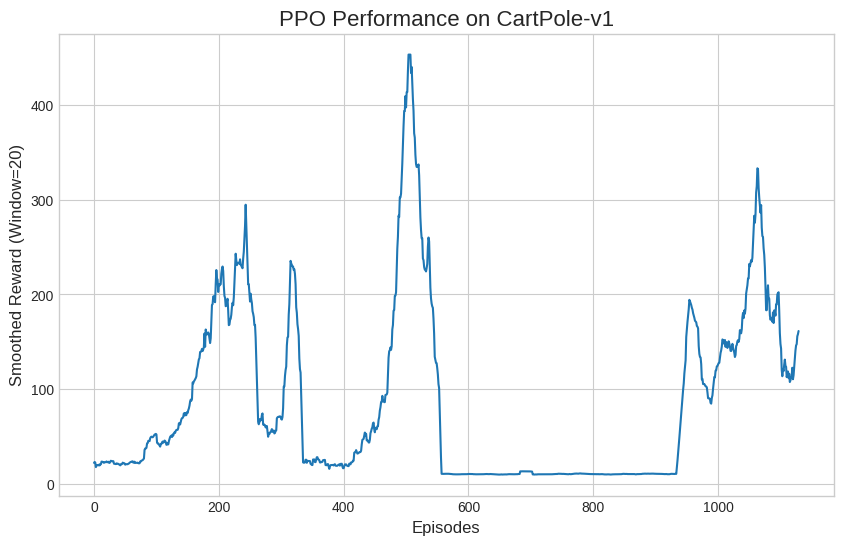

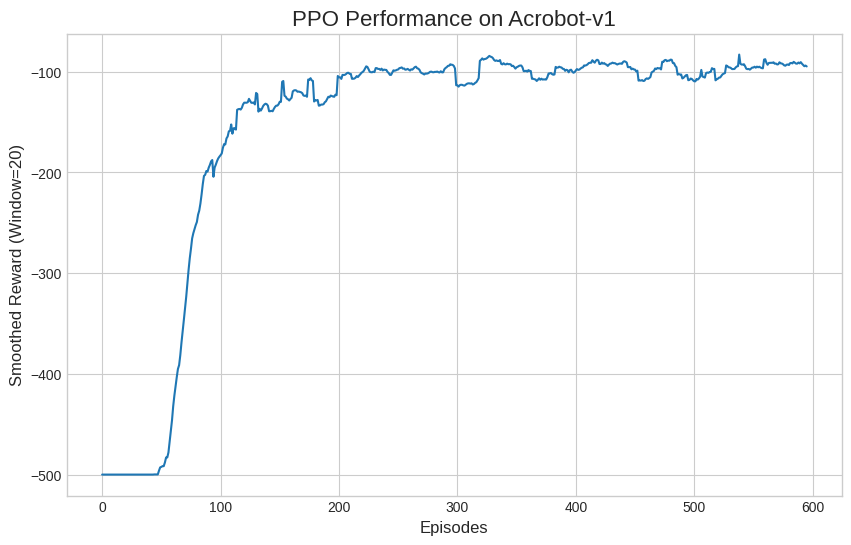

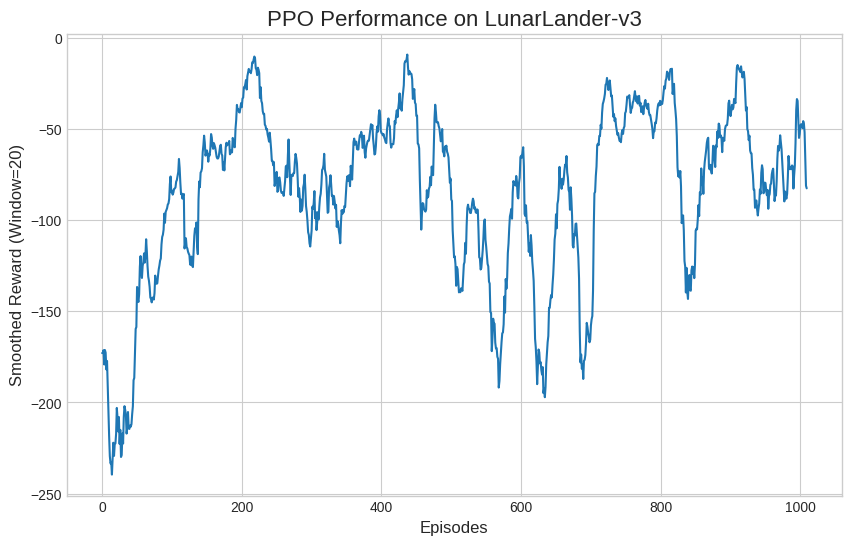

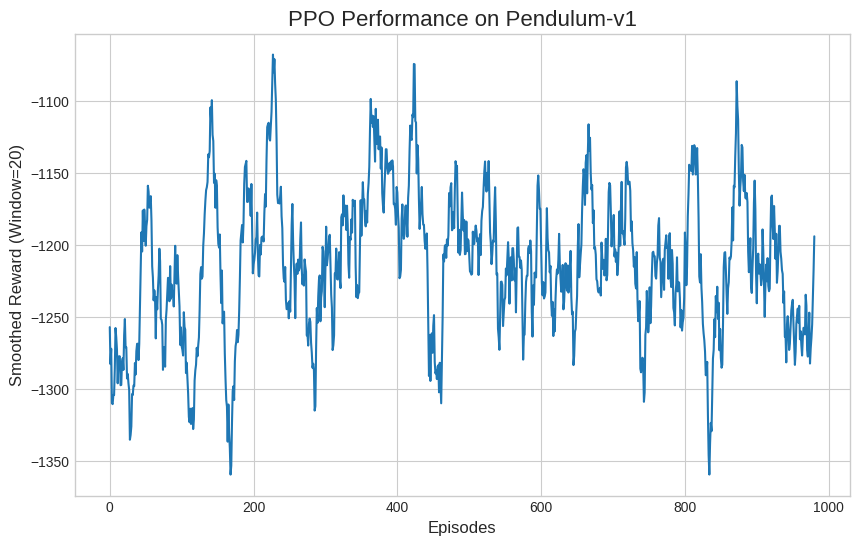

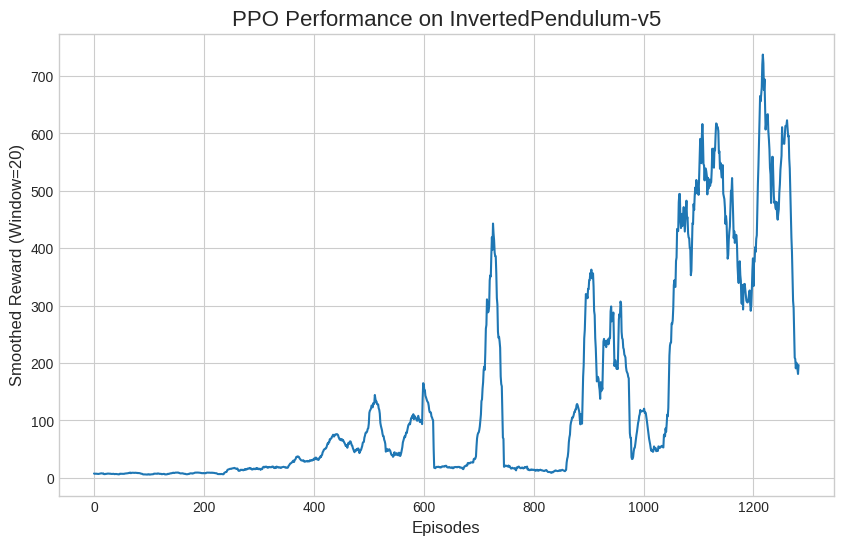

In [13]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical, Normal
import time
import random
import matplotlib.pyplot as plt
import optuna

SEED = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")
print(f"Global seed: {SEED}")

# Defines the Actor-Critic network. It shares initial layers and has separate heads
# for the policy (actor) and value function (critic). It includes methods to get the
# action distribution, state value, and evaluate an action's log probability and entropy.
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, is_continuous):
        super(ActorCritic, self).__init__()
        self.is_continuous = is_continuous
        self.shared_layers = nn.Sequential(nn.Linear(state_dim, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh())
        self.actor_head = nn.Linear(64, action_dim)
        self.critic_head = nn.Linear(64, 1)
        if self.is_continuous:
            self.log_std = nn.Parameter(torch.zeros(1, action_dim))

    def get_dist(self, state):
        shared_features = self.shared_layers(state)
        if self.is_continuous:
            mean = self.actor_head(shared_features)
            std = torch.exp(self.log_std)
            dist = Normal(mean, std)
        else:
            logits = self.actor_head(shared_features)
            dist = Categorical(logits=logits)
        return dist

    def get_value(self, state):
        return self.critic_head(self.shared_layers(state))

    def evaluate_action(self, state, action):
        dist = self.get_dist(state)
        log_prob = dist.log_prob(action)
        if self.is_continuous:
            log_prob = log_prob.sum(-1)
        entropy = dist.entropy()
        if self.is_continuous:
            entropy = entropy.sum(-1)
        value = self.get_value(state)
        return value, log_prob, entropy

# Calculates the Generalized Advantage Estimation (GAE) and the corresponding returns.
# GAE provides a stable advantage estimate by blending multi-step returns.
def compute_gae(rewards, values, dones, gamma, lambda_gae):
    advantages = []
    last_advantage = 0
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t+1] * (1 - dones[t]) - values[t]
        last_advantage = delta + gamma * lambda_gae * (1 - dones[t]) * last_advantage
        advantages.insert(0, last_advantage)
    advantages = torch.tensor(advantages, dtype=torch.float32).to(device)
    returns = advantages + torch.tensor(values[:-1], dtype=torch.float32).to(device)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    return advantages, returns


# The main training loop for the PPO algorithm. It handles environment interaction,
# data collection, advantage computation, and updates the agent's networks.
def train(config):
    seed = config["seed"]; torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
    env = gym.make(config["env_name"]); env.reset(seed=seed); env.action_space.seed(seed)
    state_dim = env.observation_space.shape[0]
    is_continuous = isinstance(env.action_space, gym.spaces.Box)
    action_dim = env.action_space.shape[0] if is_continuous else env.action_space.n
    agent = ActorCritic(state_dim, action_dim, is_continuous).to(device)
    optimizer = torch.optim.Adam(agent.parameters(), lr=config["lr"], eps=1e-5)
    start_time = time.time(); all_episode_rewards = []
    print(f"--- Training for {config['epochs']} epochs ---")

    for epoch in range(config["epochs"]):
        batch_states, batch_actions, batch_log_probs, batch_rewards, batch_dones, batch_values = [], [], [], [], [], []
        ep_rewards_in_epoch = []; steps_in_epoch = 0; state, _ = env.reset(); current_episode_reward = 0
        while steps_in_epoch < config["steps_per_epoch"]:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                dist = agent.get_dist(state_tensor); value = agent.get_value(state_tensor)
                action = dist.sample()
                action_to_step = action.cpu().numpy()[0]
                action_for_log_prob = action
                if is_continuous:
                    action_to_step = np.clip(action_to_step, env.action_space.low, env.action_space.high)
                    action_for_log_prob = torch.FloatTensor(action_to_step).unsqueeze(0).to(device)
                log_prob = dist.log_prob(action_for_log_prob)
                if is_continuous: log_prob = log_prob.sum(-1)
            next_state, reward, terminated, truncated, _ = env.step(action_to_step)
            done = terminated or truncated
            batch_states.append(state_tensor); batch_actions.append(action_for_log_prob); batch_log_probs.append(log_prob)
            batch_rewards.append(reward); batch_dones.append(done); batch_values.append(value.cpu().item())
            state = next_state; steps_in_epoch += 1; current_episode_reward += reward
            if done:
                all_episode_rewards.append(current_episode_reward)
                ep_rewards_in_epoch.append(current_episode_reward)
                state, _ = env.reset(); current_episode_reward = 0
        with torch.no_grad():
            last_value = agent.get_value(torch.FloatTensor(state).unsqueeze(0).to(device))
            batch_values.append(last_value.cpu().item())
        advantages, returns = compute_gae(batch_rewards, batch_values, batch_dones, config["gamma"], config["lambda_gae"])
        states_tensor = torch.cat(batch_states); actions_tensor = torch.cat(batch_actions); old_log_probs_tensor = torch.cat(batch_log_probs)
        for _ in range(config["update_epochs"]):
            indices = np.arange(config["steps_per_epoch"]); np.random.shuffle(indices)
            for start in range(0, config["steps_per_epoch"], config["minibatch_size"]):
                end = start + config["minibatch_size"]; mb_indices = indices[start:end]
                values, new_log_probs, entropy = agent.evaluate_action(states_tensor[mb_indices], actions_tensor[mb_indices])
                ratio = torch.exp(new_log_probs - old_log_probs_tensor[mb_indices])
                surr1 = ratio * advantages[mb_indices]
                surr2 = torch.clamp(ratio, 1 - config["clip_coef"], 1 + config["clip_coef"]) * advantages[mb_indices]
                policy_loss = -torch.min(surr1, surr2).mean()
                value_loss = nn.MSELoss()(values.squeeze(), returns[mb_indices])
                entropy_loss = -entropy.mean()
                loss = policy_loss + config["vf_coef"] * value_loss + config["ent_coef"] * entropy_loss
                optimizer.zero_grad(); loss.backward()
                nn.utils.clip_grad_norm_(agent.parameters(), config["max_grad_norm"])
                optimizer.step()
        avg_reward = np.mean(ep_rewards_in_epoch) if ep_rewards_in_epoch else 0.0
        print(f"Epoch: {epoch+1}/{config['epochs']} | Avg Reward: {avg_reward:.2f} | Time: {time.time() - start_time:.2f}s")
    env.close()
    return all_episode_rewards



#configurations with tuned hyper parameters
FINAL_PPO_CONFIGS = {
    "CartPole-v1": {"env_name": "CartPole-v1", "seed": 6, "epochs": 50, "steps_per_epoch": 2048, "gamma": 0.99, "lambda_gae": 0.95, "minibatch_size": 64,
        "lr": 0.004665485027051999,
        "update_epochs": 10,
        "clip_coef": 0.26755986037793833,
        "vf_coef": 0.6290054638833613,
        "ent_coef": 0.008293426022747633,
        "max_grad_norm": 0.5,
    },
    "Acrobot-v1": {"env_name": "Acrobot-v1", "seed": 6, "epochs": 50, "steps_per_epoch": 2048, "gamma": 0.99, "lambda_gae": 0.95, "minibatch_size": 64,
        "lr": 0.003711233513428388,
        "update_epochs": 7,
        "clip_coef": 0.1732021619664734,
        "vf_coef": 0.6999247113754699,
        "ent_coef": 0.03378276830457914,
        "max_grad_norm": 0.5,
    },
    "LunarLander-v3": {"env_name": "LunarLander-v3", "seed": 6, "epochs": 100, "steps_per_epoch": 2048, "gamma": 0.99, "lambda_gae": 0.95, "minibatch_size": 64,
        "lr": 0.004185547603761529,
        "update_epochs": 10,
        "clip_coef": 0.16552323665774962,
        "vf_coef": 0.37490804939397404,
        "ent_coef": 0.020481539906598265,
        "max_grad_norm": 0.5,
    },
    "Pendulum-v1": {"env_name": "Pendulum-v1", "seed": 6, "epochs": 100, "steps_per_epoch": 2048, "gamma": 0.99, "lambda_gae": 0.95, "minibatch_size": 64,
        "lr": 0.004612813814972431,
        "update_epochs": 10,
        "clip_coef": 0.18044334912695223,
        "vf_coef": 0.6417292619996507,
        "ent_coef": 0.04738577388735471,
        "max_grad_norm": 0.5,
    },
    "InvertedPendulum-v5": {"env_name": "InvertedPendulum-v5", "seed": 6, "epochs": 100, "steps_per_epoch": 2048, "gamma": 0.99, "lambda_gae": 0.95, "minibatch_size": 64,
        "lr": 0.001852726960763727,
        "update_epochs": 10,
        "clip_coef": 0.2549868701686233,
        "vf_coef": 0.5277305530659305,
        "ent_coef": 0.030527071335378936,
        "max_grad_norm": 0.5,
    },
}



environments_to_run = ["CartPole-v1", "Acrobot-v1", "LunarLander-v3", "Pendulum-v1", "InvertedPendulum-v5"]
all_results = {}
for env_name in environments_to_run:
    print(f"\n\n{'='*20}\nRunning FINAL training for: {env_name}\n{'='*20}")
    rewards = train(FINAL_PPO_CONFIGS[env_name])
    all_results[env_name] = rewards

def moving_average(data, window_size):
    if len(data) < window_size: return np.array([])
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

print("\n\n--- Plotting Final Results ---")
for env_name, rewards in all_results.items():
    plt.figure(figsize=(10, 6)); plt.style.use('seaborn-v0_8-whitegrid')
    smoothed_rewards = moving_average(rewards, 20)
    if smoothed_rewards.any(): plt.plot(smoothed_rewards)
    plt.title(f"PPO Performance on {env_name}", fontsize=16)
    plt.xlabel("Episodes", fontsize=12)
    plt.ylabel("Smoothed Reward (Window=20)", fontsize=12)
    plt.grid(True)
    plt.show()


In [5]:
!pip install Optuna

In [9]:
#Hyperparameter Tuning with Optuna
import optuna

def objective(trial, env_name):
    # Reduced workload for faster trials during tuning
    config = {
        "env_name": env_name, "seed": SEED, "epochs": 25, "steps_per_epoch": 2048,
        "gamma": 0.99, "lambda_gae": 0.95, "minibatch_size": 64,

        # --- Hyperparameters to be tuned by Optuna ---
        "lr": trial.suggest_float("lr", 1e-4, 5e-3, log=True),
        "update_epochs": trial.suggest_int("update_epochs", 4, 10),
        "clip_coef": trial.suggest_float("clip_coef", 0.1, 0.3),
        "vf_coef": trial.suggest_float("vf_coef", 0.3, 0.7),
        "ent_coef": trial.suggest_float("ent_coef", 0.0, 0.05),
    }

    # Call the train function from the previous cell, passing the trial object
    # to enable pruning.
    all_episode_rewards = train(config, trial=trial)

    # Return the final performance metric to be maximized
    return np.mean(all_episode_rewards[-10:]) if len(all_episode_rewards) > 10 else -np.inf

def run_tuning():
    environments_to_tune = ["CartPole-v1", "Acrobot-v1", "LunarLander-v3", "Pendulum-v1", "InvertedPendulum-v5"]
    all_best_params = {}
    n_trials_per_env = 50

    for env_name in environments_to_tune:
        print(f"\n\n{'='*20}\nOptimizing for: {env_name}\n{'='*20}")
        study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
        study.optimize(lambda t: objective(t, env_name), n_trials=n_trials_per_env, timeout=3600)

        print(f"\n--- Optimization Finished for {env_name} ---")
        print(f"Best score: {study.best_value:.2f}")
        print("Best parameters found:")
        for key, value in study.best_params.items():
            print(f"    {key}: {value}")
        all_best_params[env_name] = study.best_params

    print(f"\n\n{'='*20}\nALL OPTIMIZATIONS COMPLETE\n{'='*20}")
    print("Final tuned hyperparameters for all environments:")
    # Print in a format that can be easily copied back into the first cell
    print("FINAL_PPO_CONFIGS = {")
    for env_name, params in all_best_params.items():
        # Get the fixed params from the default config to combine them
        fixed_params = FINAL_PPO_CONFIGS[env_name]
        print(f'    "{env_name}": {{"env_name": "{env_name}", "seed": {fixed_params["seed"]}, "epochs": {fixed_params["epochs"]}, "steps_per_epoch": {fixed_params["steps_per_epoch"]}, "gamma": {fixed_params["gamma"]}, "lambda_gae": {fixed_params["lambda_gae"]}, "minibatch_size": {fixed_params["minibatch_size"]},')
        # Print the tuned params
        for key, value in params.items():
             print(f'        "{key}": {value},')
        print("    },")
    print("}")


# To run the tuning process, uncomment the line below:
# run_tuning()

[I 2025-10-13 14:21:46,289] A new study created in memory with name: no-name-683b9738-3318-4f8c-bfd4-c7b527373dd2




Optimizing for: CartPole-v1
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 8.51s
Epoch: 2/25 | Avg Reward: 23.00 | Time: 14.49s
Epoch: 3/25 | Avg Reward: 22.85 | Time: 17.78s
Epoch: 4/25 | Avg Reward: 21.95 | Time: 20.32s
Epoch: 5/25 | Avg Reward: 24.74 | Time: 22.92s
Epoch: 6/25 | Avg Reward: 22.36 | Time: 25.60s
Epoch: 7/25 | Avg Reward: 23.64 | Time: 28.70s
Epoch: 8/25 | Avg Reward: 25.43 | Time: 31.53s
Epoch: 9/25 | Avg Reward: 25.10 | Time: 33.97s
Epoch: 10/25 | Avg Reward: 31.91 | Time: 36.40s
Epoch: 11/25 | Avg Reward: 35.84 | Time: 38.87s
Epoch: 12/25 | Avg Reward: 32.87 | Time: 42.04s
Epoch: 13/25 | Avg Reward: 39.67 | Time: 44.78s
Epoch: 14/25 | Avg Reward: 48.45 | Time: 47.32s
Epoch: 15/25 | Avg Reward: 61.12 | Time: 49.71s
Epoch: 16/25 | Avg Reward: 48.83 | Time: 52.08s
Epoch: 17/25 | Avg Reward: 56.14 | Time: 55.27s
Epoch: 18/25 | Avg Reward: 79.60 | Time: 57.96s
Epoch: 19/25 | Avg Reward: 44.91 | Time: 60.47s
Epoch: 20/25 | Avg Reward: 113.39 | T

[I 2025-10-13 14:23:01,916] Trial 0 finished with value: 70.5 and parameters: {'lr': 0.0001175342428275507, 'update_epochs': 8, 'clip_coef': 0.12426606991431638, 'vf_coef': 0.41635587123243867, 'ent_coef': 0.002278970764733285}. Best is trial 0 with value: 70.5.


Epoch: 25/25 | Avg Reward: 80.60 | Time: 75.59s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.52s
Epoch: 2/25 | Avg Reward: 32.21 | Time: 7.48s
Epoch: 3/25 | Avg Reward: 65.39 | Time: 10.02s
Epoch: 4/25 | Avg Reward: 154.00 | Time: 12.59s
Epoch: 5/25 | Avg Reward: 119.27 | Time: 15.18s
Epoch: 6/25 | Avg Reward: 72.39 | Time: 18.29s
Epoch: 7/25 | Avg Reward: 123.81 | Time: 21.34s
Epoch: 8/25 | Avg Reward: 218.56 | Time: 23.85s
Epoch: 9/25 | Avg Reward: 249.62 | Time: 26.30s
Epoch: 10/25 | Avg Reward: 153.85 | Time: 28.77s
Epoch: 11/25 | Avg Reward: 340.83 | Time: 31.85s
Epoch: 12/25 | Avg Reward: 118.06 | Time: 34.75s
Epoch: 13/25 | Avg Reward: 119.69 | Time: 37.29s
Epoch: 14/25 | Avg Reward: 500.00 | Time: 39.97s
Epoch: 15/25 | Avg Reward: 91.59 | Time: 42.50s
Epoch: 16/25 | Avg Reward: 386.40 | Time: 45.98s
Epoch: 17/25 | Avg Reward: 136.08 | Time: 48.46s
Epoch: 18/25 | Avg Reward: 225.67 | Time: 50.96s
Epoch: 19/25 | Avg Reward: 142.54 | Time: 53.55s
Epoch:

[I 2025-10-13 14:24:12,179] Trial 1 finished with value: 263.5 and parameters: {'lr': 0.002771486733636814, 'update_epochs': 9, 'clip_coef': 0.20427125081630143, 'vf_coef': 0.5770615835394539, 'ent_coef': 0.011280647087298673}. Best is trial 1 with value: 263.5.


Epoch: 25/25 | Avg Reward: 281.86 | Time: 70.23s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 3.27s
Epoch: 2/25 | Avg Reward: 39.33 | Time: 5.85s
Epoch: 3/25 | Avg Reward: 100.55 | Time: 8.48s
Epoch: 4/25 | Avg Reward: 144.15 | Time: 10.96s
Epoch: 5/25 | Avg Reward: 100.60 | Time: 14.43s
Epoch: 6/25 | Avg Reward: 98.90 | Time: 17.34s
Epoch: 7/25 | Avg Reward: 131.33 | Time: 19.94s
Epoch: 8/25 | Avg Reward: 122.60 | Time: 22.68s
Epoch: 9/25 | Avg Reward: 168.67 | Time: 25.49s
Epoch: 10/25 | Avg Reward: 263.50 | Time: 28.87s
Epoch: 11/25 | Avg Reward: 443.25 | Time: 31.52s
Epoch: 12/25 | Avg Reward: 196.60 | Time: 34.21s
Epoch: 13/25 | Avg Reward: 276.83 | Time: 36.84s
Epoch: 14/25 | Avg Reward: 318.50 | Time: 40.50s
Epoch: 15/25 | Avg Reward: 337.50 | Time: 43.58s
Epoch: 16/25 | Avg Reward: 252.00 | Time: 46.24s
Epoch: 17/25 | Avg Reward: 394.80 | Time: 48.82s
Epoch: 18/25 | Avg Reward: 84.89 | Time: 51.92s
Epoch: 19/25 | Avg Reward: 485.50 | Time: 55.27s
Epoch

[I 2025-10-13 14:25:23,997] Trial 2 finished with value: 101.1 and parameters: {'lr': 0.002333318995973135, 'update_epochs': 10, 'clip_coef': 0.23426187999214357, 'vf_coef': 0.4651480879604747, 'ent_coef': 0.01533600552911113}. Best is trial 1 with value: 263.5.


Epoch: 25/25 | Avg Reward: 110.89 | Time: 71.78s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.23s
Epoch: 2/25 | Avg Reward: 21.04 | Time: 4.50s
Epoch: 3/25 | Avg Reward: 21.69 | Time: 7.53s
Epoch: 4/25 | Avg Reward: 21.76 | Time: 10.14s
Epoch: 5/25 | Avg Reward: 21.30 | Time: 12.35s
Epoch: 6/25 | Avg Reward: 25.49 | Time: 14.63s
Epoch: 7/25 | Avg Reward: 20.43 | Time: 17.07s
Epoch: 8/25 | Avg Reward: 22.17 | Time: 19.73s
Epoch: 9/25 | Avg Reward: 24.87 | Time: 22.52s
Epoch: 10/25 | Avg Reward: 26.35 | Time: 24.69s
Epoch: 11/25 | Avg Reward: 27.36 | Time: 26.95s
Epoch: 12/25 | Avg Reward: 31.68 | Time: 29.23s
Epoch: 13/25 | Avg Reward: 30.94 | Time: 31.50s
Epoch: 14/25 | Avg Reward: 34.10 | Time: 34.77s
Epoch: 15/25 | Avg Reward: 37.87 | Time: 37.01s
Epoch: 16/25 | Avg Reward: 39.31 | Time: 39.20s
Epoch: 17/25 | Avg Reward: 37.22 | Time: 41.41s
Epoch: 18/25 | Avg Reward: 62.94 | Time: 43.62s
Epoch: 19/25 | Avg Reward: 44.16 | Time: 46.43s
Epoch: 20/25 | Avg R

[I 2025-10-13 14:26:25,441] Trial 3 finished with value: 65.3 and parameters: {'lr': 0.00010474422104137204, 'update_epochs': 7, 'clip_coef': 0.2498023411905151, 'vf_coef': 0.40582953314873144, 'ent_coef': 0.042048045182136104}. Best is trial 1 with value: 263.5.


Epoch: 25/25 | Avg Reward: 98.50 | Time: 61.42s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.28s
Epoch: 2/25 | Avg Reward: 24.25 | Time: 4.58s
Epoch: 3/25 | Avg Reward: 21.87 | Time: 6.85s
Epoch: 4/25 | Avg Reward: 25.68 | Time: 9.28s
Epoch: 5/25 | Avg Reward: 28.44 | Time: 12.41s
Epoch: 6/25 | Avg Reward: 35.09 | Time: 14.68s
Epoch: 7/25 | Avg Reward: 34.68 | Time: 17.11s
Epoch: 8/25 | Avg Reward: 45.20 | Time: 19.39s
Epoch: 9/25 | Avg Reward: 57.63 | Time: 21.70s
Epoch: 10/25 | Avg Reward: 79.24 | Time: 24.85s
Epoch: 11/25 | Avg Reward: 50.42 | Time: 27.32s
Epoch: 12/25 | Avg Reward: 101.26 | Time: 29.61s
Epoch: 13/25 | Avg Reward: 88.80 | Time: 32.01s
Epoch: 14/25 | Avg Reward: 87.50 | Time: 34.30s
Epoch: 15/25 | Avg Reward: 157.46 | Time: 37.23s
Epoch: 16/25 | Avg Reward: 123.86 | Time: 39.97s
Epoch: 17/25 | Avg Reward: 150.33 | Time: 42.31s
Epoch: 18/25 | Avg Reward: 59.53 | Time: 44.58s
Epoch: 19/25 | Avg Reward: 458.75 | Time: 46.88s
Epoch: 20/25 | Av

[I 2025-10-13 14:27:27,722] Trial 4 finished with value: 209.0 and parameters: {'lr': 0.00029694798126003453, 'update_epochs': 7, 'clip_coef': 0.1454494667806988, 'vf_coef': 0.6768293344768691, 'ent_coef': 0.049083181433120134}. Best is trial 1 with value: 263.5.


Epoch: 25/25 | Avg Reward: 215.56 | Time: 62.25s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.77s
Epoch: 2/25 | Avg Reward: 25.20 | Time: 4.75s
Epoch: 3/25 | Avg Reward: 31.35 | Time: 6.81s
Epoch: 4/25 | Avg Reward: 50.12 | Time: 9.01s
Epoch: 5/25 | Avg Reward: 38.60 | Time: 11.03s
Epoch: 6/25 | Avg Reward: 56.31 | Time: 13.43s
Epoch: 7/25 | Avg Reward: 63.41 | Time: 16.21s
Epoch: 8/25 | Avg Reward: 84.54 | Time: 18.15s
Epoch: 9/25 | Avg Reward: 100.00 | Time: 20.14s
Epoch: 10/25 | Avg Reward: 191.30 | Time: 22.19s
Epoch: 11/25 | Avg Reward: 97.10 | Time: 24.14s
Epoch: 12/25 | Avg Reward: 181.09 | Time: 26.54s
Epoch: 13/25 | Avg Reward: 177.64 | Time: 29.06s
Epoch: 14/25 | Avg Reward: 106.78 | Time: 31.00s
Epoch: 15/25 | Avg Reward: 127.00 | Time: 32.99s
Epoch: 16/25 | Avg Reward: 273.00 | Time: 34.97s
Epoch: 17/25 | Avg Reward: 96.62 | Time: 36.91s
Epoch: 18/25 | Avg Reward: 117.35 | Time: 39.23s
Epoch: 19/25 | Avg Reward: 239.25 | Time: 41.82s
Epoch: 20/25

[I 2025-10-13 14:28:22,610] Trial 5 finished with value: 240.6 and parameters: {'lr': 0.0018619225201282777, 'update_epochs': 5, 'clip_coef': 0.21924101794443795, 'vf_coef': 0.34036073860390104, 'ent_coef': 0.0018230062221963163}. Best is trial 1 with value: 263.5.


Epoch: 25/25 | Avg Reward: 221.00 | Time: 54.86s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.09s
Epoch: 2/25 | Avg Reward: 38.45 | Time: 4.37s
Epoch: 3/25 | Avg Reward: 57.54 | Time: 6.50s
Epoch: 4/25 | Avg Reward: 65.87 | Time: 8.64s
Epoch: 5/25 | Avg Reward: 63.67 | Time: 11.45s
Epoch: 6/25 | Avg Reward: 63.53 | Time: 13.95s
Epoch: 7/25 | Avg Reward: 63.53 | Time: 16.05s
Epoch: 8/25 | Avg Reward: 155.46 | Time: 18.36s
Epoch: 9/25 | Avg Reward: 163.08 | Time: 20.52s
Epoch: 10/25 | Avg Reward: 163.00 | Time: 22.86s
Epoch: 11/25 | Avg Reward: 44.48 | Time: 25.67s
Epoch: 12/25 | Avg Reward: 140.71 | Time: 27.76s
Epoch: 13/25 | Avg Reward: 145.62 | Time: 29.86s
Epoch: 14/25 | Avg Reward: 173.73 | Time: 31.96s
Epoch: 15/25 | Avg Reward: 276.71 | Time: 34.05s
Epoch: 16/25 | Avg Reward: 178.27 | Time: 36.52s
Epoch: 17/25 | Avg Reward: 113.12 | Time: 39.16s
Epoch: 18/25 | Avg Reward: 146.00 | Time: 41.25s
Epoch: 19/25 | Avg Reward: 112.83 | Time: 43.34s
Epoch: 20/

[I 2025-10-13 14:29:19,484] Trial 6 finished with value: 280.1 and parameters: {'lr': 0.003754353341588979, 'update_epochs': 6, 'clip_coef': 0.2512069661353238, 'vf_coef': 0.669788407319568, 'ent_coef': 0.0398098728786547}. Best is trial 6 with value: 280.1.


Epoch: 25/25 | Avg Reward: 332.00 | Time: 56.85s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.36s
Epoch: 2/25 | Avg Reward: 32.41 | Time: 5.02s
Epoch: 3/25 | Avg Reward: 50.77 | Time: 8.30s
Epoch: 4/25 | Avg Reward: 200.70 | Time: 10.69s
Epoch: 5/25 | Avg Reward: 198.89 | Time: 13.07s
Epoch: 6/25 | Avg Reward: 185.90 | Time: 15.47s
Epoch: 7/25 | Avg Reward: 173.00 | Time: 18.04s
Epoch: 8/25 | Avg Reward: 227.38 | Time: 21.18s
Epoch: 9/25 | Avg Reward: 71.39 | Time: 23.67s
Epoch: 10/25 | Avg Reward: 180.82 | Time: 26.01s
Epoch: 11/25 | Avg Reward: 170.25 | Time: 28.39s
Epoch: 12/25 | Avg Reward: 467.75 | Time: 30.87s
Epoch: 13/25 | Avg Reward: 77.54 | Time: 34.02s
Epoch: 14/25 | Avg Reward: 74.81 | Time: 36.39s
Epoch: 15/25 | Avg Reward: 226.89 | Time: 38.80s
Epoch: 16/25 | Avg Reward: 339.00 | Time: 41.18s
Epoch: 17/25 | Avg Reward: 457.00 | Time: 43.67s
Epoch: 18/25 | Avg Reward: 289.86 | Time: 46.94s
Epoch: 19/25 | Avg Reward: 146.54 | Time: 49.36s
Epoch: 

[I 2025-10-13 14:30:24,361] Trial 7 finished with value: 62.5 and parameters: {'lr': 0.0024156069842595535, 'update_epochs': 9, 'clip_coef': 0.190779558925943, 'vf_coef': 0.5483055605934755, 'ent_coef': 0.033875062172340625}. Best is trial 6 with value: 280.1.


Epoch: 25/25 | Avg Reward: 45.39 | Time: 64.85s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.47s
Epoch: 2/25 | Avg Reward: 37.69 | Time: 5.11s
Epoch: 3/25 | Avg Reward: 91.64 | Time: 8.26s
Epoch: 4/25 | Avg Reward: 379.00 | Time: 10.68s
Epoch: 5/25 | Avg Reward: 33.43 | Time: 13.09s
Epoch: 6/25 | Avg Reward: 83.62 | Time: 15.44s
Epoch: 7/25 | Avg Reward: 124.27 | Time: 18.02s
Epoch: 8/25 | Avg Reward: 78.60 | Time: 21.29s
Epoch: 9/25 | Avg Reward: 62.81 | Time: 23.67s
Epoch: 10/25 | Avg Reward: 119.94 | Time: 26.07s
Epoch: 11/25 | Avg Reward: 87.83 | Time: 28.44s
Epoch: 12/25 | Avg Reward: 151.38 | Time: 31.01s
Epoch: 13/25 | Avg Reward: 452.75 | Time: 34.17s
Epoch: 14/25 | Avg Reward: 51.13 | Time: 36.56s
Epoch: 15/25 | Avg Reward: 337.67 | Time: 38.93s
Epoch: 16/25 | Avg Reward: 500.00 | Time: 41.33s
Epoch: 17/25 | Avg Reward: 159.45 | Time: 43.84s
Epoch: 18/25 | Avg Reward: 169.42 | Time: 47.04s
Epoch: 19/25 | Avg Reward: 479.25 | Time: 49.42s
Epoch: 20/2

[I 2025-10-13 14:31:29,294] Trial 8 finished with value: 233.5 and parameters: {'lr': 0.0034000300805014285, 'update_epochs': 9, 'clip_coef': 0.2432058378432317, 'vf_coef': 0.3732112562378986, 'ent_coef': 0.027300402672039828}. Best is trial 6 with value: 280.1.


Epoch: 25/25 | Avg Reward: 255.43 | Time: 64.90s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 1.92s


[I 2025-10-13 14:31:33,160] Trial 9 pruned. 


Epoch: 2/25 | Avg Reward: 20.70 | Time: 3.86s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.33s


[I 2025-10-13 14:31:37,770] Trial 10 pruned. 


Epoch: 2/25 | Avg Reward: 22.36 | Time: 4.56s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.07s
Epoch: 2/25 | Avg Reward: 46.19 | Time: 4.15s
Epoch: 3/25 | Avg Reward: 95.67 | Time: 6.36s
Epoch: 4/25 | Avg Reward: 55.47 | Time: 8.41s
Epoch: 5/25 | Avg Reward: 61.52 | Time: 11.13s
Epoch: 6/25 | Avg Reward: 103.89 | Time: 13.48s
Epoch: 7/25 | Avg Reward: 231.25 | Time: 15.51s
Epoch: 8/25 | Avg Reward: 373.80 | Time: 17.58s
Epoch: 9/25 | Avg Reward: 38.88 | Time: 19.72s
Epoch: 10/25 | Avg Reward: 98.35 | Time: 21.74s
Epoch: 11/25 | Avg Reward: 88.14 | Time: 24.56s
Epoch: 12/25 | Avg Reward: 339.00 | Time: 26.70s
Epoch: 13/25 | Avg Reward: 500.00 | Time: 28.70s
Epoch: 14/25 | Avg Reward: 145.14 | Time: 30.74s
Epoch: 15/25 | Avg Reward: 289.86 | Time: 32.75s
Epoch: 16/25 | Avg Reward: 250.71 | Time: 34.93s
Epoch: 17/25 | Avg Reward: 247.00 | Time: 37.87s
Epoch: 18/25 | Avg Reward: 94.30 | Time: 39.87s
Epoch: 19/25 | Avg Reward: 173.36 | Time: 41.89s
Epoch: 20/25 |

[I 2025-10-13 14:32:32,855] Trial 11 finished with value: 214.5 and parameters: {'lr': 0.004523942010781733, 'update_epochs': 6, 'clip_coef': 0.2914302630277797, 'vf_coef': 0.5845987682647034, 'ent_coef': 0.014718161501990505}. Best is trial 6 with value: 280.1.


Epoch: 25/25 | Avg Reward: 393.75 | Time: 55.03s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.12s


[I 2025-10-13 14:32:37,121] Trial 12 pruned. 


Epoch: 2/25 | Avg Reward: 22.59 | Time: 4.25s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.90s
Epoch: 2/25 | Avg Reward: 50.73 | Time: 6.07s
Epoch: 3/25 | Avg Reward: 95.81 | Time: 8.53s
Epoch: 4/25 | Avg Reward: 108.41 | Time: 11.03s
Epoch: 5/25 | Avg Reward: 100.70 | Time: 13.61s
Epoch: 6/25 | Avg Reward: 73.04 | Time: 16.85s
Epoch: 7/25 | Avg Reward: 258.43 | Time: 19.54s
Epoch: 8/25 | Avg Reward: 52.24 | Time: 22.03s
Epoch: 9/25 | Avg Reward: 40.68 | Time: 24.59s
Epoch: 10/25 | Avg Reward: 74.85 | Time: 27.25s
Epoch: 11/25 | Avg Reward: 43.42 | Time: 30.92s
Epoch: 12/25 | Avg Reward: 56.36 | Time: 33.59s
Epoch: 13/25 | Avg Reward: 101.85 | Time: 36.36s
Epoch: 14/25 | Avg Reward: 262.83 | Time: 39.00s
Epoch: 15/25 | Avg Reward: 358.60 | Time: 42.26s
Epoch: 16/25 | Avg Reward: 117.53 | Time: 45.23s
Epoch: 17/25 | Avg Reward: 394.50 | Time: 47.82s
Epoch: 18/25 | Avg Reward: 500.00 | Time: 50.44s
Epoch: 19/25 | Avg Reward: 92.64 | Time: 52.99s
Epoch: 20/25 |

[I 2025-10-13 14:33:47,465] Trial 13 finished with value: 300.7 and parameters: {'lr': 0.004665485027051999, 'update_epochs': 10, 'clip_coef': 0.26755986037793833, 'vf_coef': 0.6290054638833613, 'ent_coef': 0.008293426022747633}. Best is trial 13 with value: 300.7.


Epoch: 25/25 | Avg Reward: 338.67 | Time: 70.29s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.05s


[I 2025-10-13 14:33:51,599] Trial 14 pruned. 


Epoch: 2/25 | Avg Reward: 21.46 | Time: 4.11s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.65s
Epoch: 2/25 | Avg Reward: 57.74 | Time: 5.38s
Epoch: 3/25 | Avg Reward: 87.61 | Time: 8.75s
Epoch: 4/25 | Avg Reward: 110.39 | Time: 11.30s
Epoch: 5/25 | Avg Reward: 75.65 | Time: 13.80s
Epoch: 6/25 | Avg Reward: 104.37 | Time: 16.34s
Epoch: 7/25 | Avg Reward: 304.83 | Time: 19.23s
Epoch: 8/25 | Avg Reward: 58.91 | Time: 22.31s
Epoch: 9/25 | Avg Reward: 88.04 | Time: 24.79s
Epoch: 10/25 | Avg Reward: 156.69 | Time: 27.27s
Epoch: 11/25 | Avg Reward: 182.91 | Time: 29.75s
Epoch: 12/25 | Avg Reward: 144.57 | Time: 32.80s
Epoch: 13/25 | Avg Reward: 336.40 | Time: 35.97s
Epoch: 14/25 | Avg Reward: 264.67 | Time: 38.47s
Epoch: 15/25 | Avg Reward: 337.80 | Time: 41.00s
Epoch: 16/25 | Avg Reward: 142.71 | Time: 43.66s
Epoch: 17/25 | Avg Reward: 434.00 | Time: 47.19s
Epoch: 18/25 | Avg Reward: 237.25 | Time: 49.76s
Epoch: 19/25 | Avg Reward: 272.43 | Time: 52.28s
Epoch: 20/

[I 2025-10-13 14:35:00,144] Trial 15 finished with value: 193.5 and parameters: {'lr': 0.004107808354762571, 'update_epochs': 10, 'clip_coef': 0.2638803524779197, 'vf_coef': 0.5237922119911378, 'ent_coef': 0.03635190506286518}. Best is trial 13 with value: 300.7.


Epoch: 25/25 | Avg Reward: 193.50 | Time: 68.49s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.97s


[I 2025-10-13 14:35:05,918] Trial 16 pruned. 


Epoch: 2/25 | Avg Reward: 28.60 | Time: 5.75s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.13s
Epoch: 2/25 | Avg Reward: 42.23 | Time: 4.25s


[I 2025-10-13 14:35:12,314] Trial 17 pruned. 


Epoch: 3/25 | Avg Reward: 43.80 | Time: 6.38s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 1.78s


[I 2025-10-13 14:35:16,597] Trial 18 pruned. 


Epoch: 2/25 | Avg Reward: 23.46 | Time: 4.23s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.57s


[I 2025-10-13 14:35:21,496] Trial 19 pruned. 


Epoch: 2/25 | Avg Reward: 28.70 | Time: 4.84s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 1.99s


[I 2025-10-13 14:35:25,460] Trial 20 pruned. 


Epoch: 2/25 | Avg Reward: 24.24 | Time: 3.94s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.62s
Epoch: 2/25 | Avg Reward: 37.24 | Time: 5.92s


[I 2025-10-13 14:35:33,793] Trial 21 pruned. 


Epoch: 3/25 | Avg Reward: 58.17 | Time: 8.30s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.52s
Epoch: 2/25 | Avg Reward: 44.15 | Time: 5.04s
Epoch: 3/25 | Avg Reward: 95.95 | Time: 7.93s
Epoch: 4/25 | Avg Reward: 30.48 | Time: 11.03s
Epoch: 5/25 | Avg Reward: 63.83 | Time: 13.59s
Epoch: 6/25 | Avg Reward: 51.46 | Time: 16.15s


[I 2025-10-13 14:35:52,496] Trial 22 pruned. 


Epoch: 7/25 | Avg Reward: 81.54 | Time: 18.68s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 3.07s


[I 2025-10-13 14:35:58,326] Trial 23 pruned. 


Epoch: 2/25 | Avg Reward: 32.79 | Time: 5.79s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.54s
Epoch: 2/25 | Avg Reward: 37.04 | Time: 5.28s


[I 2025-10-13 14:36:06,201] Trial 24 pruned. 


Epoch: 3/25 | Avg Reward: 59.71 | Time: 7.84s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 3.30s
Epoch: 2/25 | Avg Reward: 39.72 | Time: 5.57s
Epoch: 3/25 | Avg Reward: 71.93 | Time: 7.89s
Epoch: 4/25 | Avg Reward: 142.93 | Time: 10.22s
Epoch: 5/25 | Avg Reward: 100.65 | Time: 12.56s
Epoch: 6/25 | Avg Reward: 60.12 | Time: 15.65s
Epoch: 7/25 | Avg Reward: 140.14 | Time: 18.13s
Epoch: 8/25 | Avg Reward: 110.94 | Time: 20.51s
Epoch: 9/25 | Avg Reward: 242.29 | Time: 22.86s
Epoch: 10/25 | Avg Reward: 96.95 | Time: 25.19s
Epoch: 11/25 | Avg Reward: 149.85 | Time: 28.81s
Epoch: 12/25 | Avg Reward: 148.15 | Time: 31.33s
Epoch: 13/25 | Avg Reward: 199.70 | Time: 33.65s
Epoch: 14/25 | Avg Reward: 283.29 | Time: 35.98s
Epoch: 15/25 | Avg Reward: 289.00 | Time: 38.31s
Epoch: 16/25 | Avg Reward: 412.25 | Time: 41.21s
Epoch: 17/25 | Avg Reward: 500.00 | Time: 44.01s
Epoch: 18/25 | Avg Reward: 21.33 | Time: 46.39s
Epoch: 19/25 | Avg Reward: 396.40 | Time: 48.68s
Epoch: 20/

[I 2025-10-13 14:37:09,947] Trial 25 finished with value: 141.0 and parameters: {'lr': 0.004661541175992917, 'update_epochs': 8, 'clip_coef': 0.21262473059622414, 'vf_coef': 0.5298637143849906, 'ent_coef': 0.014535647870137624}. Best is trial 13 with value: 300.7.


Epoch: 25/25 | Avg Reward: 131.53 | Time: 63.71s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.77s


[I 2025-10-13 14:37:15,786] Trial 26 pruned. 


Epoch: 2/25 | Avg Reward: 28.59 | Time: 5.82s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.49s


[I 2025-10-13 14:37:20,870] Trial 27 pruned. 


Epoch: 2/25 | Avg Reward: 28.32 | Time: 5.03s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.14s


[I 2025-10-13 14:37:25,581] Trial 28 pruned. 


Epoch: 2/25 | Avg Reward: 30.86 | Time: 4.67s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.96s


[I 2025-10-13 14:37:30,877] Trial 29 pruned. 


Epoch: 2/25 | Avg Reward: 25.59 | Time: 5.24s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.22s


[I 2025-10-13 14:37:35,246] Trial 30 pruned. 


Epoch: 2/25 | Avg Reward: 29.57 | Time: 4.33s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 1.90s


[I 2025-10-13 14:37:39,813] Trial 31 pruned. 


Epoch: 2/25 | Avg Reward: 21.69 | Time: 4.55s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.17s


[I 2025-10-13 14:37:43,969] Trial 32 pruned. 


Epoch: 2/25 | Avg Reward: 28.19 | Time: 4.09s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 1.97s
Epoch: 2/25 | Avg Reward: 39.63 | Time: 4.03s
Epoch: 3/25 | Avg Reward: 83.83 | Time: 6.07s
Epoch: 4/25 | Avg Reward: 121.00 | Time: 8.79s
Epoch: 5/25 | Avg Reward: 272.17 | Time: 11.11s
Epoch: 6/25 | Avg Reward: 133.27 | Time: 13.41s
Epoch: 7/25 | Avg Reward: 117.06 | Time: 15.47s
Epoch: 8/25 | Avg Reward: 500.00 | Time: 17.53s
Epoch: 9/25 | Avg Reward: 117.19 | Time: 19.64s
Epoch: 10/25 | Avg Reward: 185.20 | Time: 22.63s
Epoch: 11/25 | Avg Reward: 131.47 | Time: 24.71s
Epoch: 12/25 | Avg Reward: 212.89 | Time: 26.76s
Epoch: 13/25 | Avg Reward: 375.60 | Time: 28.84s
Epoch: 14/25 | Avg Reward: 169.83 | Time: 30.91s
Epoch: 15/25 | Avg Reward: 443.50 | Time: 33.15s
Epoch: 16/25 | Avg Reward: 325.67 | Time: 35.92s
Epoch: 17/25 | Avg Reward: 378.80 | Time: 37.97s
Epoch: 18/25 | Avg Reward: 84.04 | Time: 40.02s
Epoch: 19/25 | Avg Reward: 323.67 | Time: 42.08s
Epoch: 20

[I 2025-10-13 14:38:39,678] Trial 33 finished with value: 198.4 and parameters: {'lr': 0.004909817192829249, 'update_epochs': 6, 'clip_coef': 0.24041640981805784, 'vf_coef': 0.3487832916668341, 'ent_coef': 0.018095308774424973}. Best is trial 13 with value: 300.7.


Epoch: 25/25 | Avg Reward: 198.40 | Time: 55.66s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 1.82s


[I 2025-10-13 14:38:43,718] Trial 34 pruned. 


Epoch: 2/25 | Avg Reward: 24.18 | Time: 4.02s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.48s


[I 2025-10-13 14:38:48,189] Trial 35 pruned. 


Epoch: 2/25 | Avg Reward: 25.09 | Time: 4.42s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.54s


[I 2025-10-13 14:38:53,455] Trial 36 pruned. 


Epoch: 2/25 | Avg Reward: 24.60 | Time: 5.23s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.27s


[I 2025-10-13 14:38:58,813] Trial 37 pruned. 


Epoch: 2/25 | Avg Reward: 30.39 | Time: 5.34s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.08s


[I 2025-10-13 14:39:03,025] Trial 38 pruned. 


Epoch: 2/25 | Avg Reward: 32.79 | Time: 4.17s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.43s


[I 2025-10-13 14:39:07,952] Trial 39 pruned. 


Epoch: 2/25 | Avg Reward: 37.04 | Time: 4.89s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.54s


[I 2025-10-13 14:39:12,807] Trial 40 pruned. 


Epoch: 2/25 | Avg Reward: 33.26 | Time: 4.82s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.44s
Epoch: 2/25 | Avg Reward: 44.15 | Time: 4.87s
Epoch: 3/25 | Avg Reward: 80.56 | Time: 7.28s
Epoch: 4/25 | Avg Reward: 111.78 | Time: 10.15s
Epoch: 5/25 | Avg Reward: 113.44 | Time: 13.36s
Epoch: 6/25 | Avg Reward: 87.43 | Time: 15.84s


[I 2025-10-13 14:39:31,095] Trial 41 pruned. 


Epoch: 7/25 | Avg Reward: 103.42 | Time: 18.25s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.35s


[I 2025-10-13 14:39:36,476] Trial 42 pruned. 


Epoch: 2/25 | Avg Reward: 31.34 | Time: 5.34s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.85s


[I 2025-10-13 14:39:41,887] Trial 43 pruned. 


Epoch: 2/25 | Avg Reward: 30.65 | Time: 5.35s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.37s


[I 2025-10-13 14:39:46,693] Trial 44 pruned. 


Epoch: 2/25 | Avg Reward: 33.93 | Time: 4.77s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 3.31s
Epoch: 2/25 | Avg Reward: 53.21 | Time: 6.10s
Epoch: 3/25 | Avg Reward: 186.70 | Time: 8.63s
Epoch: 4/25 | Avg Reward: 244.50 | Time: 11.11s
Epoch: 5/25 | Avg Reward: 113.61 | Time: 13.66s
Epoch: 6/25 | Avg Reward: 268.57 | Time: 17.18s
Epoch: 7/25 | Avg Reward: 92.91 | Time: 19.72s
Epoch: 8/25 | Avg Reward: 321.67 | Time: 22.26s
Epoch: 9/25 | Avg Reward: 297.50 | Time: 24.75s
Epoch: 10/25 | Avg Reward: 500.00 | Time: 27.54s
Epoch: 11/25 | Avg Reward: 66.20 | Time: 30.72s
Epoch: 12/25 | Avg Reward: 165.50 | Time: 33.20s
Epoch: 13/25 | Avg Reward: 283.43 | Time: 35.69s
Epoch: 14/25 | Avg Reward: 254.38 | Time: 38.19s
Epoch: 15/25 | Avg Reward: 401.75 | Time: 41.44s
Epoch: 16/25 | Avg Reward: 183.80 | Time: 44.36s
Epoch: 17/25 | Avg Reward: 379.40 | Time: 46.87s
Epoch: 18/25 | Avg Reward: 316.83 | Time: 49.36s
Epoch: 19/25 | Avg Reward: 406.00 | Time: 51.97s
Epoch: 2

[I 2025-10-13 14:40:55,825] Trial 45 finished with value: 76.4 and parameters: {'lr': 0.003884333691841893, 'update_epochs': 10, 'clip_coef': 0.2869486862768976, 'vf_coef': 0.3240129321783836, 'ent_coef': 0.035281297602619444}. Best is trial 13 with value: 300.7.


Epoch: 25/25 | Avg Reward: 96.75 | Time: 69.08s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.23s


[I 2025-10-13 14:41:00,410] Trial 46 pruned. 


Epoch: 2/25 | Avg Reward: 36.31 | Time: 4.56s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.06s


[I 2025-10-13 14:41:04,813] Trial 47 pruned. 


Epoch: 2/25 | Avg Reward: 32.79 | Time: 4.18s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 2.91s


[I 2025-10-13 14:41:10,297] Trial 48 pruned. 


Epoch: 2/25 | Avg Reward: 28.49 | Time: 5.44s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 21.99 | Time: 1.82s


[I 2025-10-13 14:41:13,971] Trial 49 pruned. 
[I 2025-10-13 14:41:13,993] A new study created in memory with name: no-name-d0583958-68d7-43be-aa47-391cc08ee8fb


Epoch: 2/25 | Avg Reward: 25.56 | Time: 3.63s

--- Optimization Finished for CartPole-v1 ---
Best score: 300.70
Best parameters found:
    lr: 0.004665485027051999
    update_epochs: 10
    clip_coef: 0.26755986037793833
    vf_coef: 0.6290054638833613
    ent_coef: 0.008293426022747633


Optimizing for: Acrobot-v1
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.21s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 4.45s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 7.66s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 9.90s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 12.32s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 14.56s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 16.83s
Epoch: 8/25 | Avg Reward: -500.00 | Time: 19.92s
Epoch: 9/25 | Avg Reward: -500.00 | Time: 22.36s
Epoch: 10/25 | Avg Reward: -500.00 | Time: 24.66s
Epoch: 11/25 | Avg Reward: -500.00 | Time: 26.93s
Epoch: 12/25 | Avg Reward: -500.00 | Time: 29.23s
Epoch: 13/25 | Avg Reward: -500.00 | Time: 32.07s
Epoch: 14/25 | 

[I 2025-10-13 14:42:16,286] Trial 0 finished with value: -403.3 and parameters: {'lr': 0.0009880761929806031, 'update_epochs': 5, 'clip_coef': 0.13640098130625392, 'vf_coef': 0.4245278596282133, 'ent_coef': 0.043274632842871114}. Best is trial 0 with value: -403.3.


Epoch: 25/25 | Avg Reward: -383.40 | Time: 62.27s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.59s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.23s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.16s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.51s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 14.34s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.90s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 19.55s
Epoch: 8/25 | Avg Reward: -500.00 | Time: 23.13s
Epoch: 9/25 | Avg Reward: -500.00 | Time: 25.86s
Epoch: 10/25 | Avg Reward: -500.00 | Time: 28.49s
Epoch: 11/25 | Avg Reward: -500.00 | Time: 31.13s
Epoch: 12/25 | Avg Reward: -500.00 | Time: 34.24s
Epoch: 13/25 | Avg Reward: -500.00 | Time: 37.61s
Epoch: 14/25 | Avg Reward: -494.25 | Time: 40.20s
Epoch: 15/25 | Avg Reward: -481.50 | Time: 42.83s
Epoch: 16/25 | Avg Reward: -500.00 | Time: 45.47s
Epoch: 17/25 | Avg Reward: -430.00 | Time: 49.07s
Epoch: 18/25 | Avg Reward: -404.00 | Time: 51.96s
Epoch: 19/25 | Avg Reward: -360

[I 2025-10-13 14:43:27,646] Trial 1 finished with value: -102.9 and parameters: {'lr': 0.0009531494077667132, 'update_epochs': 8, 'clip_coef': 0.2562005473595035, 'vf_coef': 0.5449885197932948, 'ent_coef': 0.040557874932937416}. Best is trial 1 with value: -102.9.


Epoch: 25/25 | Avg Reward: -105.53 | Time: 71.34s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 3.77s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 6.62s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 9.43s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 12.23s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 15.96s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 19.10s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 21.95s
Epoch: 8/25 | Avg Reward: -500.00 | Time: 24.80s
Epoch: 9/25 | Avg Reward: -500.00 | Time: 28.00s
Epoch: 10/25 | Avg Reward: -500.00 | Time: 31.53s
Epoch: 11/25 | Avg Reward: -500.00 | Time: 34.39s
Epoch: 12/25 | Avg Reward: -500.00 | Time: 37.22s
Epoch: 13/25 | Avg Reward: -500.00 | Time: 40.18s
Epoch: 14/25 | Avg Reward: -440.00 | Time: 43.96s
Epoch: 15/25 | Avg Reward: -491.50 | Time: 46.81s
Epoch: 16/25 | Avg Reward: -456.75 | Time: 49.70s
Epoch: 17/25 | Avg Reward: -437.25 | Time: 52.54s
Epoch: 18/25 | Avg Reward: -371.20 | Time: 56.51s
Epoch: 19/25 | Avg Reward: -415

[I 2025-10-13 14:44:46,108] Trial 2 finished with value: -252.6 and parameters: {'lr': 0.0004890858905647657, 'update_epochs': 10, 'clip_coef': 0.24928151334574236, 'vf_coef': 0.4217158040514736, 'ent_coef': 0.01648453475893538}. Best is trial 1 with value: -102.9.


Epoch: 25/25 | Avg Reward: -273.71 | Time: 78.43s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 3.91s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 6.73s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 9.55s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 12.31s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 15.87s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 19.03s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 21.97s
Epoch: 8/25 | Avg Reward: -493.25 | Time: 24.72s
Epoch: 9/25 | Avg Reward: -500.00 | Time: 27.94s
Epoch: 10/25 | Avg Reward: -500.00 | Time: 31.18s
Epoch: 11/25 | Avg Reward: -500.00 | Time: 33.86s
Epoch: 12/25 | Avg Reward: -500.00 | Time: 36.54s
Epoch: 13/25 | Avg Reward: -475.50 | Time: 39.28s
Epoch: 14/25 | Avg Reward: -463.75 | Time: 43.06s
Epoch: 15/25 | Avg Reward: -395.50 | Time: 45.74s
Epoch: 16/25 | Avg Reward: -431.75 | Time: 48.43s
Epoch: 17/25 | Avg Reward: -407.40 | Time: 51.19s
Epoch: 18/25 | Avg Reward: -339.00 | Time: 54.82s
Epoch: 19/25 | Avg Reward: -335

[I 2025-10-13 14:46:01,211] Trial 3 finished with value: -103.6 and parameters: {'lr': 0.0008378596459714131, 'update_epochs': 9, 'clip_coef': 0.2251011898025528, 'vf_coef': 0.636512720796407, 'ent_coef': 0.03783956966890593}. Best is trial 1 with value: -102.9.


Epoch: 25/25 | Avg Reward: -111.56 | Time: 75.07s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.37s
Epoch: 2/25 | Avg Reward: -448.50 | Time: 5.35s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.09s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 10.43s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 12.81s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 15.14s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 18.25s
Epoch: 8/25 | Avg Reward: -500.00 | Time: 21.00s
Epoch: 9/25 | Avg Reward: -500.00 | Time: 23.38s
Epoch: 10/25 | Avg Reward: -500.00 | Time: 25.82s
Epoch: 11/25 | Avg Reward: -500.00 | Time: 28.20s
Epoch: 12/25 | Avg Reward: -500.00 | Time: 31.17s
Epoch: 13/25 | Avg Reward: -500.00 | Time: 33.96s
Epoch: 14/25 | Avg Reward: -500.00 | Time: 36.27s
Epoch: 15/25 | Avg Reward: -500.00 | Time: 38.59s
Epoch: 16/25 | Avg Reward: -500.00 | Time: 40.92s
Epoch: 17/25 | Avg Reward: -500.00 | Time: 43.72s
Epoch: 18/25 | Avg Reward: -500.00 | Time: 46.61s
Epoch: 19/25 | Avg Reward: -500

[I 2025-10-13 14:47:05,690] Trial 4 finished with value: -500.0 and parameters: {'lr': 0.00019733106549455298, 'update_epochs': 6, 'clip_coef': 0.29214880356859585, 'vf_coef': 0.516153276689978, 'ent_coef': 0.008911244662910895}. Best is trial 1 with value: -102.9.


Epoch: 25/25 | Avg Reward: -500.00 | Time: 64.45s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.23s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 4.72s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 7.71s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 9.96s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 12.20s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 14.40s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 16.75s
Epoch: 8/25 | Avg Reward: -500.00 | Time: 20.01s
Epoch: 9/25 | Avg Reward: -500.00 | Time: 22.26s
Epoch: 10/25 | Avg Reward: -500.00 | Time: 24.52s
Epoch: 11/25 | Avg Reward: -500.00 | Time: 26.73s
Epoch: 12/25 | Avg Reward: -500.00 | Time: 28.93s
Epoch: 13/25 | Avg Reward: -500.00 | Time: 31.74s


[I 2025-10-13 14:47:40,157] Trial 5 pruned. 


Epoch: 14/25 | Avg Reward: -500.00 | Time: 34.46s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.12s
Epoch: 2/25 | Avg Reward: -470.00 | Time: 4.20s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 6.29s
Epoch: 4/25 | Avg Reward: -496.50 | Time: 8.37s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 11.52s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 13.83s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 15.98s
Epoch: 8/25 | Avg Reward: -500.00 | Time: 18.15s
Epoch: 9/25 | Avg Reward: -500.00 | Time: 20.32s
Epoch: 10/25 | Avg Reward: -500.00 | Time: 22.93s
Epoch: 11/25 | Avg Reward: -500.00 | Time: 25.58s
Epoch: 12/25 | Avg Reward: -500.00 | Time: 27.72s
Epoch: 13/25 | Avg Reward: -500.00 | Time: 29.88s
Epoch: 14/25 | Avg Reward: -500.00 | Time: 32.06s
Epoch: 15/25 | Avg Reward: -500.00 | Time: 34.24s


[I 2025-10-13 14:48:17,587] Trial 6 pruned. 


Epoch: 16/25 | Avg Reward: -500.00 | Time: 37.40s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.61s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.39s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.02s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.04s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 14.37s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 17.03s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 19.67s
Epoch: 8/25 | Avg Reward: -500.00 | Time: 22.45s
Epoch: 9/25 | Avg Reward: -469.75 | Time: 26.17s
Epoch: 10/25 | Avg Reward: -500.00 | Time: 28.83s
Epoch: 11/25 | Avg Reward: -500.00 | Time: 31.58s
Epoch: 12/25 | Avg Reward: -500.00 | Time: 34.34s
Epoch: 13/25 | Avg Reward: -475.25 | Time: 37.47s
Epoch: 14/25 | Avg Reward: -444.75 | Time: 40.75s
Epoch: 15/25 | Avg Reward: -500.00 | Time: 43.64s
Epoch: 16/25 | Avg Reward: -500.00 | Time: 46.33s


[I 2025-10-13 14:49:06,610] Trial 7 pruned. 


Epoch: 17/25 | Avg Reward: -500.00 | Time: 48.99s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 3.12s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.23s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 7.36s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 9.47s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 11.65s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 14.30s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 17.10s
Epoch: 8/25 | Avg Reward: -500.00 | Time: 19.55s
Epoch: 9/25 | Avg Reward: -481.50 | Time: 21.98s
Epoch: 10/25 | Avg Reward: -500.00 | Time: 24.27s
Epoch: 11/25 | Avg Reward: -500.00 | Time: 26.66s
Epoch: 12/25 | Avg Reward: -500.00 | Time: 29.81s
Epoch: 13/25 | Avg Reward: -500.00 | Time: 32.07s
Epoch: 14/25 | Avg Reward: -500.00 | Time: 34.28s
Epoch: 15/25 | Avg Reward: -500.00 | Time: 36.58s


[I 2025-10-13 14:49:45,409] Trial 8 pruned. 


Epoch: 16/25 | Avg Reward: -500.00 | Time: 38.77s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 3.91s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 7.07s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 10.72s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 14.82s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 18.71s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 21.74s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 24.59s
Epoch: 8/25 | Avg Reward: -500.00 | Time: 27.82s
Epoch: 9/25 | Avg Reward: -500.00 | Time: 31.34s
Epoch: 10/25 | Avg Reward: -500.00 | Time: 34.15s
Epoch: 11/25 | Avg Reward: -500.00 | Time: 37.02s
Epoch: 12/25 | Avg Reward: -500.00 | Time: 39.98s
Epoch: 13/25 | Avg Reward: -500.00 | Time: 43.71s


[I 2025-10-13 14:50:31,966] Trial 9 pruned. 


Epoch: 14/25 | Avg Reward: -500.00 | Time: 46.53s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.59s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.20s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.48s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.59s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 14.13s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.70s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 19.36s
Epoch: 8/25 | Avg Reward: -448.25 | Time: 22.91s
Epoch: 9/25 | Avg Reward: -401.50 | Time: 25.70s
Epoch: 10/25 | Avg Reward: -459.50 | Time: 28.37s
Epoch: 11/25 | Avg Reward: -339.33 | Time: 30.93s
Epoch: 12/25 | Avg Reward: -221.44 | Time: 34.05s
Epoch: 13/25 | Avg Reward: -235.62 | Time: 37.09s
Epoch: 14/25 | Avg Reward: -196.90 | Time: 39.66s
Epoch: 15/25 | Avg Reward: -144.07 | Time: 42.25s
Epoch: 16/25 | Avg Reward: -121.56 | Time: 44.71s
Epoch: 17/25 | Avg Reward: -115.35 | Time: 48.38s
Epoch: 18/25 | Avg Reward: -130.73 | Time: 50.85s
Epoch: 19/25 | Avg Reward: -117

[I 2025-10-13 14:51:41,626] Trial 10 finished with value: -85.9 and parameters: {'lr': 0.0033535395687520593, 'update_epochs': 7, 'clip_coef': 0.18635259256203232, 'vf_coef': 0.6913189010896119, 'ent_coef': 0.033475423033658185}. Best is trial 10 with value: -85.9.


Epoch: 25/25 | Avg Reward: -90.59 | Time: 69.61s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.77s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.96s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.53s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.18s
Epoch: 5/25 | Avg Reward: -426.75 | Time: 13.76s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 17.04s
Epoch: 7/25 | Avg Reward: -441.00 | Time: 19.92s
Epoch: 8/25 | Avg Reward: -355.00 | Time: 22.38s
Epoch: 9/25 | Avg Reward: -310.83 | Time: 24.93s
Epoch: 10/25 | Avg Reward: -209.89 | Time: 27.41s
Epoch: 11/25 | Avg Reward: -203.60 | Time: 31.01s
Epoch: 12/25 | Avg Reward: -199.10 | Time: 33.51s
Epoch: 13/25 | Avg Reward: -191.40 | Time: 36.02s
Epoch: 14/25 | Avg Reward: -149.23 | Time: 38.57s
Epoch: 15/25 | Avg Reward: -127.20 | Time: 41.20s
Epoch: 16/25 | Avg Reward: -115.06 | Time: 44.59s
Epoch: 17/25 | Avg Reward: -107.11 | Time: 47.26s
Epoch: 18/25 | Avg Reward: -98.60 | Time: 49.78s
Epoch: 19/25 | Avg Reward: -100.9

[I 2025-10-13 14:52:50,830] Trial 11 finished with value: -85.4 and parameters: {'lr': 0.003711233513428388, 'update_epochs': 7, 'clip_coef': 0.1732021619664734, 'vf_coef': 0.6999247113754699, 'ent_coef': 0.03378276830457914}. Best is trial 11 with value: -85.4.


Epoch: 25/25 | Avg Reward: -87.57 | Time: 69.16s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.72s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.21s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 7.72s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 10.26s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 13.97s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.48s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 18.97s
Epoch: 8/25 | Avg Reward: -402.75 | Time: 21.45s
Epoch: 9/25 | Avg Reward: -425.75 | Time: 23.99s
Epoch: 10/25 | Avg Reward: -388.80 | Time: 27.32s
Epoch: 11/25 | Avg Reward: -339.00 | Time: 29.78s
Epoch: 12/25 | Avg Reward: -270.14 | Time: 32.27s
Epoch: 13/25 | Avg Reward: -272.71 | Time: 34.78s
Epoch: 14/25 | Avg Reward: -175.91 | Time: 37.59s
Epoch: 15/25 | Avg Reward: -146.00 | Time: 40.82s
Epoch: 16/25 | Avg Reward: -126.38 | Time: 43.28s
Epoch: 17/25 | Avg Reward: -114.00 | Time: 45.75s
Epoch: 18/25 | Avg Reward: -130.13 | Time: 48.41s
Epoch: 19/25 | Avg Reward: -100.

[I 2025-10-13 14:53:58,571] Trial 12 finished with value: -96.7 and parameters: {'lr': 0.0043998657015388585, 'update_epochs': 7, 'clip_coef': 0.18430704155527852, 'vf_coef': 0.6951991273811736, 'ent_coef': 0.032092383550621474}. Best is trial 11 with value: -85.4.


Epoch: 25/25 | Avg Reward: -106.74 | Time: 67.69s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.48s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 4.96s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 7.45s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 10.90s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 13.59s
Epoch: 6/25 | Avg Reward: -499.25 | Time: 16.07s
Epoch: 7/25 | Avg Reward: -453.00 | Time: 18.51s
Epoch: 8/25 | Avg Reward: -484.50 | Time: 21.04s
Epoch: 9/25 | Avg Reward: -421.75 | Time: 24.49s
Epoch: 10/25 | Avg Reward: -491.50 | Time: 26.95s
Epoch: 11/25 | Avg Reward: -408.40 | Time: 29.42s
Epoch: 12/25 | Avg Reward: -303.83 | Time: 31.93s
Epoch: 13/25 | Avg Reward: -278.57 | Time: 34.61s
Epoch: 14/25 | Avg Reward: -248.14 | Time: 37.93s
Epoch: 15/25 | Avg Reward: -206.44 | Time: 40.41s
Epoch: 16/25 | Avg Reward: -154.92 | Time: 42.88s
Epoch: 17/25 | Avg Reward: -149.69 | Time: 45.35s
Epoch: 18/25 | Avg Reward: -138.36 | Time: 48.55s
Epoch: 19/25 | Avg Reward: -142

[I 2025-10-13 14:55:06,311] Trial 13 finished with value: -139.9 and parameters: {'lr': 0.003955222406325667, 'update_epochs': 7, 'clip_coef': 0.1711764398860908, 'vf_coef': 0.6999133813338587, 'ent_coef': 0.030722552642367333}. Best is trial 11 with value: -85.4.


Epoch: 25/25 | Avg Reward: -123.19 | Time: 67.69s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.40s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 4.76s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.03s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 10.60s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 13.16s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 15.56s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 17.96s


[I 2025-10-13 14:55:27,656] Trial 14 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 21.32s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.66s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.33s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 7.97s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 10.84s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 14.15s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.73s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 19.28s


[I 2025-10-13 14:55:49,597] Trial 15 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 21.88s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 3.18s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.85s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.20s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 10.57s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 12.98s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.12s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 18.92s


[I 2025-10-13 14:56:10,943] Trial 16 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 21.31s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.57s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.09s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.53s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.15s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 13.87s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.54s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 19.29s


[I 2025-10-13 14:56:33,731] Trial 17 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 22.75s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.75s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.62s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.53s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 12.33s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 15.13s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 18.04s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 20.91s


[I 2025-10-13 14:56:58,495] Trial 18 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 24.73s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.56s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 4.81s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 7.07s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 9.34s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 12.29s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 14.93s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 17.18s


[I 2025-10-13 14:57:18,019] Trial 19 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 19.47s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.46s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.61s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.59s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.08s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 13.63s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.28s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 19.83s


[I 2025-10-13 14:57:40,381] Trial 20 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 22.33s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.53s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.06s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 7.70s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.12s
Epoch: 5/25 | Avg Reward: -492.25 | Time: 13.63s
Epoch: 6/25 | Avg Reward: -469.75 | Time: 16.15s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 18.64s
Epoch: 8/25 | Avg Reward: -479.75 | Time: 21.64s
Epoch: 9/25 | Avg Reward: -490.75 | Time: 24.76s
Epoch: 10/25 | Avg Reward: -500.00 | Time: 27.52s
Epoch: 11/25 | Avg Reward: -444.50 | Time: 30.01s
Epoch: 12/25 | Avg Reward: -389.40 | Time: 32.55s
Epoch: 13/25 | Avg Reward: -283.86 | Time: 35.82s
Epoch: 14/25 | Avg Reward: -329.83 | Time: 38.45s
Epoch: 15/25 | Avg Reward: -291.50 | Time: 40.98s
Epoch: 16/25 | Avg Reward: -215.78 | Time: 43.48s
Epoch: 17/25 | Avg Reward: -215.44 | Time: 46.00s
Epoch: 18/25 | Avg Reward: -201.20 | Time: 49.56s
Epoch: 19/25 | Avg Reward: -141.

[I 2025-10-13 14:58:43,940] Trial 21 pruned. 


Epoch: 23/25 | Avg Reward: -121.31 | Time: 63.52s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.65s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.30s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 7.96s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.46s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 14.27s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.93s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 19.57s
Epoch: 8/25 | Avg Reward: -348.80 | Time: 22.54s
Epoch: 9/25 | Avg Reward: -252.00 | Time: 26.03s
Epoch: 10/25 | Avg Reward: -249.00 | Time: 28.68s
Epoch: 11/25 | Avg Reward: -192.10 | Time: 31.30s
Epoch: 12/25 | Avg Reward: -154.08 | Time: 33.90s
Epoch: 13/25 | Avg Reward: -137.93 | Time: 37.65s
Epoch: 14/25 | Avg Reward: -117.41 | Time: 40.39s
Epoch: 15/25 | Avg Reward: -120.88 | Time: 43.06s
Epoch: 16/25 | Avg Reward: -122.38 | Time: 45.67s
Epoch: 17/25 | Avg Reward: -110.94 | Time: 48.52s
Epoch: 18/25 | Avg Reward: -101.69 | Time: 51.99s
Epoch: 19/25 | Avg Reward: -109

[I 2025-10-13 14:59:55,284] Trial 22 finished with value: -93.6 and parameters: {'lr': 0.0048589157367210575, 'update_epochs': 8, 'clip_coef': 0.20972159123012582, 'vf_coef': 0.6992826777885434, 'ent_coef': 0.033366230291194315}. Best is trial 11 with value: -85.4.


Epoch: 25/25 | Avg Reward: -94.24 | Time: 71.31s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.87s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 6.41s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 9.08s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.72s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 14.37s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 17.69s
Epoch: 7/25 | Avg Reward: -434.50 | Time: 20.59s
Epoch: 8/25 | Avg Reward: -307.50 | Time: 23.17s
Epoch: 9/25 | Avg Reward: -315.33 | Time: 25.75s
Epoch: 10/25 | Avg Reward: -287.17 | Time: 28.36s
Epoch: 11/25 | Avg Reward: -309.33 | Time: 32.06s
Epoch: 12/25 | Avg Reward: -212.78 | Time: 34.71s
Epoch: 13/25 | Avg Reward: -191.60 | Time: 37.32s
Epoch: 14/25 | Avg Reward: -166.50 | Time: 40.12s
Epoch: 15/25 | Avg Reward: -159.75 | Time: 43.32s
Epoch: 16/25 | Avg Reward: -143.29 | Time: 46.38s
Epoch: 17/25 | Avg Reward: -121.94 | Time: 48.96s
Epoch: 18/25 | Avg Reward: -117.41 | Time: 51.61s
Epoch: 19/25 | Avg Reward: -122.

[I 2025-10-13 15:01:07,198] Trial 23 finished with value: -100.3 and parameters: {'lr': 0.0028270387271050967, 'update_epochs': 8, 'clip_coef': 0.2107748847197975, 'vf_coef': 0.6618193402002408, 'ent_coef': 0.042114138750350166}. Best is trial 11 with value: -85.4.


Epoch: 25/25 | Avg Reward: -95.76 | Time: 71.87s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.84s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.85s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.73s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 12.49s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 15.31s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 18.14s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 20.95s


[I 2025-10-13 15:01:32,041] Trial 24 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 24.82s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.28s
Epoch: 2/25 | Avg Reward: -437.75 | Time: 4.61s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 6.98s
Epoch: 4/25 | Avg Reward: -497.50 | Time: 9.37s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 12.73s
Epoch: 6/25 | Avg Reward: -495.25 | Time: 15.08s
Epoch: 7/25 | Avg Reward: -498.50 | Time: 17.63s
Epoch: 8/25 | Avg Reward: -435.00 | Time: 19.97s
Epoch: 9/25 | Avg Reward: -371.40 | Time: 22.34s
Epoch: 10/25 | Avg Reward: -356.20 | Time: 25.72s
Epoch: 11/25 | Avg Reward: -336.17 | Time: 28.08s
Epoch: 12/25 | Avg Reward: -275.29 | Time: 30.47s
Epoch: 13/25 | Avg Reward: -244.57 | Time: 32.83s
Epoch: 14/25 | Avg Reward: -202.20 | Time: 35.18s
Epoch: 15/25 | Avg Reward: -160.08 | Time: 38.47s
Epoch: 16/25 | Avg Reward: -131.67 | Time: 40.86s
Epoch: 17/25 | Avg Reward: -155.38 | Time: 43.23s
Epoch: 18/25 | Avg Reward: -118.94 | Time: 45.56s
Epoch: 19/25 | Avg Reward: -119.2

[I 2025-10-13 15:02:30,875] Trial 25 pruned. 


Epoch: 23/25 | Avg Reward: -113.06 | Time: 58.80s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.58s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 6.19s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.80s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.39s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 13.99s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.93s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 20.19s


[I 2025-10-13 15:02:53,717] Trial 26 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 22.81s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.95s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.70s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 9.46s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 12.27s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 15.03s
Epoch: 6/25 | Avg Reward: -483.75 | Time: 17.78s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 21.29s
Epoch: 8/25 | Avg Reward: -477.50 | Time: 24.32s


[I 2025-10-13 15:03:20,864] Trial 27 pruned. 


Epoch: 9/25 | Avg Reward: -452.50 | Time: 27.11s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.45s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.10s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.64s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.34s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 13.83s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.31s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 19.35s


[I 2025-10-13 15:03:43,372] Trial 28 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 22.47s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.25s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 4.55s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 6.86s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 9.40s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 12.41s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 14.72s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 17.21s


[I 2025-10-13 15:04:02,930] Trial 29 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 19.52s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 3.01s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 6.36s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.96s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.59s
Epoch: 5/25 | Avg Reward: -411.50 | Time: 14.19s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 17.91s
Epoch: 7/25 | Avg Reward: -444.00 | Time: 20.52s
Epoch: 8/25 | Avg Reward: -362.40 | Time: 23.22s
Epoch: 9/25 | Avg Reward: -366.80 | Time: 25.81s
Epoch: 10/25 | Avg Reward: -313.17 | Time: 28.69s
Epoch: 11/25 | Avg Reward: -251.75 | Time: 32.06s
Epoch: 12/25 | Avg Reward: -250.50 | Time: 34.92s
Epoch: 13/25 | Avg Reward: -177.82 | Time: 37.54s
Epoch: 14/25 | Avg Reward: -164.17 | Time: 40.16s
Epoch: 15/25 | Avg Reward: -147.92 | Time: 43.67s
Epoch: 16/25 | Avg Reward: -126.50 | Time: 46.38s
Epoch: 17/25 | Avg Reward: -114.12 | Time: 49.01s
Epoch: 18/25 | Avg Reward: -112.29 | Time: 51.71s
Epoch: 19/25 | Avg Reward: -100.

[I 2025-10-13 15:05:15,533] Trial 30 finished with value: -99.8 and parameters: {'lr': 0.004920151604968468, 'update_epochs': 8, 'clip_coef': 0.15139807920357512, 'vf_coef': 0.6770644138054949, 'ent_coef': 0.03482068854360427}. Best is trial 11 with value: -85.4.


Epoch: 25/25 | Avg Reward: -117.94 | Time: 72.56s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.50s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 4.98s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 7.54s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 10.99s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 13.48s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.04s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 18.55s


[I 2025-10-13 15:05:36,950] Trial 31 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 21.38s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 3.09s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.55s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.16s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 10.61s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 13.64s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.58s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 19.09s
Epoch: 8/25 | Avg Reward: -456.00 | Time: 21.63s


[I 2025-10-13 15:06:01,216] Trial 32 pruned. 


Epoch: 9/25 | Avg Reward: -460.75 | Time: 24.21s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 3.32s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.81s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.23s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 10.62s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 12.99s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.23s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 18.84s


[I 2025-10-13 15:06:22,433] Trial 33 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 21.18s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.56s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.15s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.74s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.37s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 13.96s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.51s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 19.50s
Epoch: 8/25 | Avg Reward: -459.75 | Time: 22.74s


[I 2025-10-13 15:06:47,797] Trial 34 pruned. 


Epoch: 9/25 | Avg Reward: -451.00 | Time: 25.34s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.67s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.14s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.45s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.09s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 13.58s
Epoch: 6/25 | Avg Reward: -454.75 | Time: 16.06s
Epoch: 7/25 | Avg Reward: -429.75 | Time: 18.50s
Epoch: 8/25 | Avg Reward: -338.20 | Time: 21.96s
Epoch: 9/25 | Avg Reward: -334.83 | Time: 24.39s
Epoch: 10/25 | Avg Reward: -245.38 | Time: 26.87s
Epoch: 11/25 | Avg Reward: -182.09 | Time: 29.37s
Epoch: 12/25 | Avg Reward: -155.54 | Time: 31.83s
Epoch: 13/25 | Avg Reward: -137.21 | Time: 35.31s
Epoch: 14/25 | Avg Reward: -115.12 | Time: 37.97s
Epoch: 15/25 | Avg Reward: -109.50 | Time: 40.47s
Epoch: 16/25 | Avg Reward: -109.00 | Time: 43.01s
Epoch: 17/25 | Avg Reward: -98.05 | Time: 45.82s
Epoch: 18/25 | Avg Reward: -100.65 | Time: 48.96s
Epoch: 19/25 | Avg Reward: -96.19

[I 2025-10-13 15:07:55,373] Trial 35 finished with value: -103.6 and parameters: {'lr': 0.004998007471027209, 'update_epochs': 7, 'clip_coef': 0.2355715293810998, 'vf_coef': 0.5268571241880704, 'ent_coef': 0.029124201141883195}. Best is trial 11 with value: -85.4.


Epoch: 25/25 | Avg Reward: -97.10 | Time: 67.52s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.46s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.58s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.28s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 10.64s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 12.95s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 15.28s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 18.22s


[I 2025-10-13 15:08:16,420] Trial 36 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 21.02s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.59s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.24s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 7.82s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.42s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 13.99s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.76s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 19.32s


[I 2025-10-13 15:08:38,663] Trial 37 pruned. 


Epoch: 8/25 | Avg Reward: -458.50 | Time: 22.21s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 3.42s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 6.12s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.78s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.47s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 15.18s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 17.88s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 20.57s


[I 2025-10-13 15:09:01,987] Trial 38 pruned. 


Epoch: 8/25 | Avg Reward: -483.25 | Time: 23.27s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.64s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.69s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.17s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 10.48s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 12.80s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 15.30s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 18.47s


[I 2025-10-13 15:09:22,813] Trial 39 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 20.79s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.61s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.23s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.37s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.50s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 14.07s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.65s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 19.22s


[I 2025-10-13 15:09:45,788] Trial 40 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 22.93s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.44s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 4.87s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 7.32s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 9.78s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 13.25s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 15.74s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 18.23s


[I 2025-10-13 15:10:06,555] Trial 41 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 20.74s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.77s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 6.09s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.65s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.36s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 13.95s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 17.18s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 20.06s


[I 2025-10-13 15:10:29,254] Trial 42 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 22.66s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.76s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.65s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 9.31s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 12.11s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 14.84s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 17.62s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 21.39s
Epoch: 8/25 | Avg Reward: -412.50 | Time: 24.29s
Epoch: 9/25 | Avg Reward: -483.50 | Time: 27.17s
Epoch: 10/25 | Avg Reward: -361.20 | Time: 30.16s
Epoch: 11/25 | Avg Reward: -331.00 | Time: 33.79s


[I 2025-10-13 15:11:06,141] Trial 43 pruned. 


Epoch: 12/25 | Avg Reward: -316.67 | Time: 36.84s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.57s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.16s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 7.83s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.26s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 13.76s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.31s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 18.91s


[I 2025-10-13 15:11:28,196] Trial 44 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 22.02s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 3.25s
Epoch: 2/25 | Avg Reward: -472.25 | Time: 6.10s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.78s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.41s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 15.09s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 17.85s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 20.55s


[I 2025-10-13 15:11:51,426] Trial 45 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 23.17s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 3.23s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 6.31s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.95s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.64s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 14.33s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 18.07s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 20.89s


[I 2025-10-13 15:12:15,001] Trial 46 pruned. 


Epoch: 8/25 | Avg Reward: -475.75 | Time: 23.54s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.73s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 6.34s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 9.25s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 12.11s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 14.89s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 18.13s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 21.46s


[I 2025-10-13 15:12:39,228] Trial 47 pruned. 


Epoch: 8/25 | Avg Reward: -472.00 | Time: 24.21s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.50s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 4.96s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 8.31s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 11.06s
Epoch: 5/25 | Avg Reward: -500.00 | Time: 13.57s
Epoch: 6/25 | Avg Reward: -466.50 | Time: 16.12s
Epoch: 7/25 | Avg Reward: -500.00 | Time: 18.65s


[I 2025-10-13 15:13:01,455] Trial 48 pruned. 


Epoch: 8/25 | Avg Reward: -500.00 | Time: 22.19s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -500.00 | Time: 2.59s
Epoch: 2/25 | Avg Reward: -500.00 | Time: 5.23s
Epoch: 3/25 | Avg Reward: -500.00 | Time: 7.84s
Epoch: 4/25 | Avg Reward: -500.00 | Time: 10.96s
Epoch: 5/25 | Avg Reward: -485.75 | Time: 14.17s
Epoch: 6/25 | Avg Reward: -500.00 | Time: 16.77s
Epoch: 7/25 | Avg Reward: -474.75 | Time: 19.44s


[I 2025-10-13 15:13:23,537] Trial 49 pruned. 
[I 2025-10-13 15:13:23,559] A new study created in memory with name: no-name-153b2d0c-67ea-4c0a-a6ab-c77ea9d3edfe


Epoch: 8/25 | Avg Reward: -458.50 | Time: 22.04s

--- Optimization Finished for Acrobot-v1 ---
Best score: -85.40
Best parameters found:
    lr: 0.003711233513428388
    update_epochs: 7
    clip_coef: 0.1732021619664734
    vf_coef: 0.6999247113754699
    ent_coef: 0.03378276830457914


Optimizing for: LunarLander-v3
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 3.45s
Epoch: 2/25 | Avg Reward: -154.07 | Time: 5.71s
Epoch: 3/25 | Avg Reward: -203.27 | Time: 8.03s
Epoch: 4/25 | Avg Reward: -175.83 | Time: 10.34s
Epoch: 5/25 | Avg Reward: -166.26 | Time: 12.60s
Epoch: 6/25 | Avg Reward: -224.44 | Time: 15.63s
Epoch: 7/25 | Avg Reward: -177.20 | Time: 18.23s
Epoch: 8/25 | Avg Reward: -233.90 | Time: 20.50s
Epoch: 9/25 | Avg Reward: -212.12 | Time: 22.80s
Epoch: 10/25 | Avg Reward: -264.48 | Time: 25.05s
Epoch: 11/25 | Avg Reward: -193.73 | Time: 27.75s
Epoch: 12/25 | Avg Reward: -226.63 | Time: 30.44s
Epoch: 13/25 | Avg Reward: -197.83 | Time: 32.68s
Epoch: 14/2

[I 2025-10-13 15:14:25,570] Trial 0 finished with value: -192.43056986180363 and parameters: {'lr': 0.0005062965821878789, 'update_epochs': 6, 'clip_coef': 0.28847547294125875, 'vf_coef': 0.6101812141956264, 'ent_coef': 0.04770709119229853}. Best is trial 0 with value: -192.43056986180363.


Epoch: 25/25 | Avg Reward: -174.34 | Time: 61.98s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.79s
Epoch: 2/25 | Avg Reward: -238.92 | Time: 6.34s
Epoch: 3/25 | Avg Reward: -188.17 | Time: 8.99s
Epoch: 4/25 | Avg Reward: -229.93 | Time: 11.64s
Epoch: 5/25 | Avg Reward: -294.77 | Time: 14.27s
Epoch: 6/25 | Avg Reward: -180.77 | Time: 17.26s
Epoch: 7/25 | Avg Reward: -300.00 | Time: 20.54s
Epoch: 8/25 | Avg Reward: -197.41 | Time: 23.12s
Epoch: 9/25 | Avg Reward: -151.11 | Time: 25.76s
Epoch: 10/25 | Avg Reward: -192.72 | Time: 28.33s
Epoch: 11/25 | Avg Reward: -238.33 | Time: 31.68s
Epoch: 12/25 | Avg Reward: -233.99 | Time: 34.55s
Epoch: 13/25 | Avg Reward: -229.42 | Time: 37.41s
Epoch: 14/25 | Avg Reward: -134.76 | Time: 40.16s
Epoch: 15/25 | Avg Reward: -129.87 | Time: 43.21s
Epoch: 16/25 | Avg Reward: -163.40 | Time: 46.54s
Epoch: 17/25 | Avg Reward: -140.22 | Time: 49.19s
Epoch: 18/25 | Avg Reward: -169.23 | Time: 51.81s
Epoch: 19/25 | Avg Reward: -118

[I 2025-10-13 15:15:37,994] Trial 1 finished with value: -157.96724422772883 and parameters: {'lr': 0.0019742105239887605, 'update_epochs': 9, 'clip_coef': 0.2080176582037579, 'vf_coef': 0.35591866126712923, 'ent_coef': 0.02482152440957205}. Best is trial 1 with value: -157.96724422772883.


Epoch: 25/25 | Avg Reward: -157.97 | Time: 72.40s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.16s
Epoch: 2/25 | Avg Reward: -231.97 | Time: 4.36s
Epoch: 3/25 | Avg Reward: -182.91 | Time: 6.48s
Epoch: 4/25 | Avg Reward: -203.30 | Time: 8.62s
Epoch: 5/25 | Avg Reward: -204.18 | Time: 11.64s
Epoch: 6/25 | Avg Reward: -179.18 | Time: 13.87s
Epoch: 7/25 | Avg Reward: -201.06 | Time: 16.09s
Epoch: 8/25 | Avg Reward: -188.60 | Time: 18.25s
Epoch: 9/25 | Avg Reward: -202.09 | Time: 20.39s
Epoch: 10/25 | Avg Reward: -208.20 | Time: 22.89s
Epoch: 11/25 | Avg Reward: -169.76 | Time: 25.67s
Epoch: 12/25 | Avg Reward: -201.52 | Time: 27.87s
Epoch: 13/25 | Avg Reward: -207.93 | Time: 30.30s
Epoch: 14/25 | Avg Reward: -162.11 | Time: 32.54s
Epoch: 15/25 | Avg Reward: -195.92 | Time: 34.82s
Epoch: 16/25 | Avg Reward: -174.95 | Time: 38.01s
Epoch: 17/25 | Avg Reward: -207.06 | Time: 40.28s
Epoch: 18/25 | Avg Reward: -192.59 | Time: 42.51s
Epoch: 19/25 | Avg Reward: -179.

[I 2025-10-13 15:16:37,044] Trial 2 finished with value: -278.33539304417604 and parameters: {'lr': 0.0004863740485973489, 'update_epochs': 5, 'clip_coef': 0.1261297981190004, 'vf_coef': 0.3528992933493423, 'ent_coef': 0.047448986239572395}. Best is trial 1 with value: -157.96724422772883.


Epoch: 25/25 | Avg Reward: -208.24 | Time: 59.02s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.96s
Epoch: 2/25 | Avg Reward: -211.85 | Time: 6.07s
Epoch: 3/25 | Avg Reward: -199.49 | Time: 8.47s
Epoch: 4/25 | Avg Reward: -175.22 | Time: 10.81s
Epoch: 5/25 | Avg Reward: -188.10 | Time: 13.23s
Epoch: 6/25 | Avg Reward: -230.40 | Time: 15.99s
Epoch: 7/25 | Avg Reward: -172.44 | Time: 18.97s
Epoch: 8/25 | Avg Reward: -259.91 | Time: 21.44s
Epoch: 9/25 | Avg Reward: -232.65 | Time: 23.82s
Epoch: 10/25 | Avg Reward: -293.72 | Time: 26.15s
Epoch: 11/25 | Avg Reward: -328.23 | Time: 28.91s
Epoch: 12/25 | Avg Reward: -214.68 | Time: 31.95s
Epoch: 13/25 | Avg Reward: -158.63 | Time: 34.20s
Epoch: 14/25 | Avg Reward: -193.60 | Time: 36.45s
Epoch: 15/25 | Avg Reward: -188.74 | Time: 38.71s
Epoch: 16/25 | Avg Reward: -236.17 | Time: 41.13s
Epoch: 17/25 | Avg Reward: -128.02 | Time: 44.17s
Epoch: 18/25 | Avg Reward: -124.13 | Time: 46.46s
Epoch: 19/25 | Avg Reward: -166

[I 2025-10-13 15:17:40,481] Trial 3 finished with value: -137.52951588724034 and parameters: {'lr': 0.002344785319471368, 'update_epochs': 6, 'clip_coef': 0.224324183965258, 'vf_coef': 0.32154949620278295, 'ent_coef': 0.043113016719543526}. Best is trial 3 with value: -137.52951588724034.


Epoch: 25/25 | Avg Reward: -125.34 | Time: 63.41s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.59s
Epoch: 2/25 | Avg Reward: -198.98 | Time: 6.00s
Epoch: 3/25 | Avg Reward: -179.63 | Time: 8.71s
Epoch: 4/25 | Avg Reward: -171.47 | Time: 11.30s
Epoch: 5/25 | Avg Reward: -196.35 | Time: 13.89s
Epoch: 6/25 | Avg Reward: -182.38 | Time: 16.57s
Epoch: 7/25 | Avg Reward: -219.74 | Time: 19.98s
Epoch: 8/25 | Avg Reward: -198.00 | Time: 22.56s
Epoch: 9/25 | Avg Reward: -203.33 | Time: 25.18s
Epoch: 10/25 | Avg Reward: -249.20 | Time: 27.80s
Epoch: 11/25 | Avg Reward: -145.81 | Time: 30.95s
Epoch: 12/25 | Avg Reward: -214.02 | Time: 34.07s
Epoch: 13/25 | Avg Reward: -175.23 | Time: 36.86s
Epoch: 14/25 | Avg Reward: -249.52 | Time: 39.47s
Epoch: 15/25 | Avg Reward: -191.07 | Time: 42.11s
Epoch: 16/25 | Avg Reward: -226.66 | Time: 45.66s
Epoch: 17/25 | Avg Reward: -187.47 | Time: 48.30s
Epoch: 18/25 | Avg Reward: -233.59 | Time: 50.94s
Epoch: 19/25 | Avg Reward: -193

[I 2025-10-13 15:18:51,960] Trial 4 finished with value: -182.51568419729495 and parameters: {'lr': 0.0002517523791675713, 'update_epochs': 9, 'clip_coef': 0.13270413356071648, 'vf_coef': 0.6071349514165673, 'ent_coef': 0.029560543331324587}. Best is trial 3 with value: -137.52951588724034.


Epoch: 25/25 | Avg Reward: -191.91 | Time: 71.45s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.58s
Epoch: 2/25 | Avg Reward: -175.22 | Time: 5.11s
Epoch: 3/25 | Avg Reward: -191.76 | Time: 7.61s
Epoch: 4/25 | Avg Reward: -175.72 | Time: 10.47s
Epoch: 5/25 | Avg Reward: -209.03 | Time: 13.73s
Epoch: 6/25 | Avg Reward: -223.04 | Time: 16.25s
Epoch: 7/25 | Avg Reward: -225.94 | Time: 18.76s
Epoch: 8/25 | Avg Reward: -217.55 | Time: 21.32s
Epoch: 9/25 | Avg Reward: -181.33 | Time: 24.16s
Epoch: 10/25 | Avg Reward: -136.51 | Time: 27.27s
Epoch: 11/25 | Avg Reward: -130.00 | Time: 29.79s
Epoch: 12/25 | Avg Reward: -130.88 | Time: 32.48s
Epoch: 13/25 | Avg Reward: -111.83 | Time: 35.13s
Epoch: 14/25 | Avg Reward: -112.17 | Time: 38.36s
Epoch: 15/25 | Avg Reward: -222.33 | Time: 41.07s
Epoch: 16/25 | Avg Reward: -127.72 | Time: 43.57s
Epoch: 17/25 | Avg Reward: -132.06 | Time: 46.01s
Epoch: 18/25 | Avg Reward: -167.05 | Time: 48.46s
Epoch: 19/25 | Avg Reward: -182

[I 2025-10-13 15:19:59,544] Trial 5 finished with value: -85.49583468653296 and parameters: {'lr': 0.002611588131020878, 'update_epochs': 7, 'clip_coef': 0.20500574022684565, 'vf_coef': 0.47689550614375664, 'ent_coef': 0.02984215593962851}. Best is trial 5 with value: -85.49583468653296.


Epoch: 25/25 | Avg Reward: -75.21 | Time: 67.55s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.56s
Epoch: 2/25 | Avg Reward: -231.32 | Time: 5.05s
Epoch: 3/25 | Avg Reward: -202.72 | Time: 7.55s
Epoch: 4/25 | Avg Reward: -167.86 | Time: 11.05s
Epoch: 5/25 | Avg Reward: -220.30 | Time: 13.66s
Epoch: 6/25 | Avg Reward: -216.83 | Time: 16.24s
Epoch: 7/25 | Avg Reward: -185.71 | Time: 18.77s
Epoch: 8/25 | Avg Reward: -187.05 | Time: 21.59s
Epoch: 9/25 | Avg Reward: -240.13 | Time: 24.72s
Epoch: 10/25 | Avg Reward: -167.85 | Time: 27.46s
Epoch: 11/25 | Avg Reward: -214.61 | Time: 30.21s
Epoch: 12/25 | Avg Reward: -173.76 | Time: 32.88s
Epoch: 13/25 | Avg Reward: -178.60 | Time: 36.12s
Epoch: 14/25 | Avg Reward: -146.85 | Time: 38.88s
Epoch: 15/25 | Avg Reward: -227.42 | Time: 41.35s
Epoch: 16/25 | Avg Reward: -153.35 | Time: 43.86s
Epoch: 17/25 | Avg Reward: -240.39 | Time: 46.27s
Epoch: 18/25 | Avg Reward: -313.62 | Time: 49.72s
Epoch: 19/25 | Avg Reward: -253.

[I 2025-10-13 15:21:07,905] Trial 6 finished with value: -251.21904285053796 and parameters: {'lr': 0.0001764296453434464, 'update_epochs': 7, 'clip_coef': 0.2306455971319498, 'vf_coef': 0.5816817746790486, 'ent_coef': 0.03683516069971112}. Best is trial 5 with value: -85.49583468653296.


Epoch: 25/25 | Avg Reward: -261.52 | Time: 68.33s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.43s
Epoch: 2/25 | Avg Reward: -241.09 | Time: 4.87s
Epoch: 3/25 | Avg Reward: -213.42 | Time: 8.02s


[I 2025-10-13 15:21:18,261] Trial 7 pruned. 


Epoch: 4/25 | Avg Reward: -201.01 | Time: 10.34s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.44s
Epoch: 2/25 | Avg Reward: -267.61 | Time: 4.94s
Epoch: 3/25 | Avg Reward: -251.84 | Time: 7.58s


[I 2025-10-13 15:21:29,127] Trial 8 pruned. 


Epoch: 4/25 | Avg Reward: -181.25 | Time: 10.83s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.40s
Epoch: 2/25 | Avg Reward: -183.15 | Time: 5.96s
Epoch: 3/25 | Avg Reward: -196.55 | Time: 8.42s


[I 2025-10-13 15:21:40,513] Trial 9 pruned. 


Epoch: 4/25 | Avg Reward: -205.39 | Time: 11.34s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.45s
Epoch: 2/25 | Avg Reward: -206.08 | Time: 4.43s
Epoch: 3/25 | Avg Reward: -213.07 | Time: 6.46s


[I 2025-10-13 15:21:49,063] Trial 10 pruned. 


Epoch: 4/25 | Avg Reward: -257.72 | Time: 8.52s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.62s
Epoch: 2/25 | Avg Reward: -199.64 | Time: 6.07s
Epoch: 3/25 | Avg Reward: -209.89 | Time: 8.60s


[I 2025-10-13 15:22:00,311] Trial 11 pruned. 


Epoch: 4/25 | Avg Reward: -197.25 | Time: 11.21s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.74s
Epoch: 2/25 | Avg Reward: -167.22 | Time: 6.46s
Epoch: 3/25 | Avg Reward: -180.12 | Time: 9.73s
Epoch: 4/25 | Avg Reward: -199.02 | Time: 12.63s
Epoch: 5/25 | Avg Reward: -237.21 | Time: 15.59s
Epoch: 6/25 | Avg Reward: -199.91 | Time: 18.95s
Epoch: 7/25 | Avg Reward: -186.66 | Time: 22.14s
Epoch: 8/25 | Avg Reward: -200.67 | Time: 24.90s
Epoch: 9/25 | Avg Reward: -216.31 | Time: 27.66s
Epoch: 10/25 | Avg Reward: -187.15 | Time: 30.86s
Epoch: 11/25 | Avg Reward: -236.40 | Time: 34.52s
Epoch: 12/25 | Avg Reward: -151.88 | Time: 37.29s
Epoch: 13/25 | Avg Reward: -120.87 | Time: 40.13s
Epoch: 14/25 | Avg Reward: -103.02 | Time: 43.04s
Epoch: 15/25 | Avg Reward: -101.63 | Time: 46.79s
Epoch: 16/25 | Avg Reward: -75.27 | Time: 49.74s
Epoch: 17/25 | Avg Reward: -92.66 | Time: 52.54s
Epoch: 18/25 | Avg Reward: -110.21 | Time: 55.55s
Epoch: 19/25 | Avg Reward: -90.63 

[I 2025-10-13 15:23:18,276] Trial 12 finished with value: -116.91331002166069 and parameters: {'lr': 0.0018593625489797586, 'update_epochs': 10, 'clip_coef': 0.1873497892213683, 'vf_coef': 0.40861682947389383, 'ent_coef': 0.03637350052997875}. Best is trial 5 with value: -85.49583468653296.


Epoch: 25/25 | Avg Reward: -116.91 | Time: 77.91s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.76s
Epoch: 2/25 | Avg Reward: -157.16 | Time: 6.02s
Epoch: 3/25 | Avg Reward: -169.69 | Time: 9.47s
Epoch: 4/25 | Avg Reward: -241.41 | Time: 12.37s
Epoch: 5/25 | Avg Reward: -192.23 | Time: 15.14s
Epoch: 6/25 | Avg Reward: -236.10 | Time: 18.40s
Epoch: 7/25 | Avg Reward: -264.85 | Time: 21.99s
Epoch: 8/25 | Avg Reward: -210.22 | Time: 24.99s
Epoch: 9/25 | Avg Reward: -273.12 | Time: 27.93s
Epoch: 10/25 | Avg Reward: -277.22 | Time: 31.00s
Epoch: 11/25 | Avg Reward: -168.23 | Time: 34.56s
Epoch: 12/25 | Avg Reward: -220.98 | Time: 37.43s
Epoch: 13/25 | Avg Reward: -257.75 | Time: 40.23s


[I 2025-10-13 15:24:01,498] Trial 13 pruned. 


Epoch: 14/25 | Avg Reward: -195.33 | Time: 43.19s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 3.85s
Epoch: 2/25 | Avg Reward: -148.19 | Time: 6.64s
Epoch: 3/25 | Avg Reward: -185.75 | Time: 9.36s
Epoch: 4/25 | Avg Reward: -210.09 | Time: 12.01s
Epoch: 5/25 | Avg Reward: -259.47 | Time: 15.36s
Epoch: 6/25 | Avg Reward: -169.39 | Time: 18.46s
Epoch: 7/25 | Avg Reward: -183.06 | Time: 21.26s
Epoch: 8/25 | Avg Reward: -178.58 | Time: 24.02s
Epoch: 9/25 | Avg Reward: -148.17 | Time: 26.98s
Epoch: 10/25 | Avg Reward: -338.69 | Time: 30.50s
Epoch: 11/25 | Avg Reward: -178.27 | Time: 33.24s
Epoch: 12/25 | Avg Reward: -192.59 | Time: 35.97s
Epoch: 13/25 | Avg Reward: -131.54 | Time: 39.11s
Epoch: 14/25 | Avg Reward: -120.70 | Time: 42.93s
Epoch: 15/25 | Avg Reward: -134.23 | Time: 45.75s
Epoch: 16/25 | Avg Reward: -83.65 | Time: 48.55s
Epoch: 17/25 | Avg Reward: -96.27 | Time: 51.30s
Epoch: 18/25 | Avg Reward: -132.82 | Time: 54.87s
Epoch: 19/25 | Avg Reward: -88.08

[I 2025-10-13 15:25:18,759] Trial 14 finished with value: -100.86271321468229 and parameters: {'lr': 0.002294560119212606, 'update_epochs': 10, 'clip_coef': 0.17420220882895215, 'vf_coef': 0.5149193190961368, 'ent_coef': 0.018563235914571045}. Best is trial 5 with value: -85.49583468653296.


Epoch: 25/25 | Avg Reward: -80.59 | Time: 77.04s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 3.78s
Epoch: 2/25 | Avg Reward: -172.37 | Time: 6.78s
Epoch: 3/25 | Avg Reward: -221.38 | Time: 9.50s
Epoch: 4/25 | Avg Reward: -170.24 | Time: 12.28s
Epoch: 5/25 | Avg Reward: -186.86 | Time: 15.24s
Epoch: 6/25 | Avg Reward: -229.73 | Time: 18.74s
Epoch: 7/25 | Avg Reward: -224.63 | Time: 21.48s
Epoch: 8/25 | Avg Reward: -190.57 | Time: 24.34s
Epoch: 9/25 | Avg Reward: -145.86 | Time: 27.08s
Epoch: 10/25 | Avg Reward: -180.73 | Time: 30.88s
Epoch: 11/25 | Avg Reward: -161.91 | Time: 33.95s
Epoch: 12/25 | Avg Reward: -145.72 | Time: 37.01s
Epoch: 13/25 | Avg Reward: -179.36 | Time: 39.93s
Epoch: 14/25 | Avg Reward: -154.82 | Time: 43.77s
Epoch: 15/25 | Avg Reward: -103.07 | Time: 46.59s
Epoch: 16/25 | Avg Reward: -152.75 | Time: 49.47s
Epoch: 17/25 | Avg Reward: -101.51 | Time: 52.14s
Epoch: 18/25 | Avg Reward: -80.86 | Time: 55.24s
Epoch: 19/25 | Avg Reward: -119.8

[I 2025-10-13 15:26:34,267] Trial 15 finished with value: -111.92422356096895 and parameters: {'lr': 0.0029743982677900398, 'update_epochs': 8, 'clip_coef': 0.15591508449861782, 'vf_coef': 0.5375883338938209, 'ent_coef': 0.017732481212394905}. Best is trial 5 with value: -85.49583468653296.


Epoch: 25/25 | Avg Reward: -95.77 | Time: 75.47s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.58s
Epoch: 2/25 | Avg Reward: -257.62 | Time: 5.75s
Epoch: 3/25 | Avg Reward: -169.05 | Time: 9.15s
Epoch: 4/25 | Avg Reward: -225.58 | Time: 11.77s
Epoch: 5/25 | Avg Reward: -157.11 | Time: 14.41s
Epoch: 6/25 | Avg Reward: -203.27 | Time: 17.12s
Epoch: 7/25 | Avg Reward: -167.28 | Time: 20.78s
Epoch: 8/25 | Avg Reward: -215.29 | Time: 23.42s
Epoch: 9/25 | Avg Reward: -249.66 | Time: 26.03s
Epoch: 10/25 | Avg Reward: -139.19 | Time: 28.77s
Epoch: 11/25 | Avg Reward: -201.09 | Time: 32.11s
Epoch: 12/25 | Avg Reward: -210.78 | Time: 35.49s
Epoch: 13/25 | Avg Reward: -202.89 | Time: 38.14s
Epoch: 14/25 | Avg Reward: -172.46 | Time: 40.78s
Epoch: 15/25 | Avg Reward: -205.92 | Time: 43.33s
Epoch: 16/25 | Avg Reward: -185.74 | Time: 46.83s


[I 2025-10-13 15:27:23,705] Trial 16 pruned. 


Epoch: 17/25 | Avg Reward: -205.52 | Time: 49.41s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.77s
Epoch: 2/25 | Avg Reward: -214.16 | Time: 5.55s
Epoch: 3/25 | Avg Reward: -162.21 | Time: 8.73s
Epoch: 4/25 | Avg Reward: -210.26 | Time: 12.03s
Epoch: 5/25 | Avg Reward: -183.92 | Time: 14.78s
Epoch: 6/25 | Avg Reward: -175.80 | Time: 17.81s
Epoch: 7/25 | Avg Reward: -209.34 | Time: 20.78s
Epoch: 8/25 | Avg Reward: -178.47 | Time: 24.38s
Epoch: 9/25 | Avg Reward: -205.22 | Time: 27.26s
Epoch: 10/25 | Avg Reward: -229.09 | Time: 30.18s
Epoch: 11/25 | Avg Reward: -251.52 | Time: 33.20s
Epoch: 12/25 | Avg Reward: -235.83 | Time: 36.96s
Epoch: 13/25 | Avg Reward: -193.52 | Time: 39.83s


[I 2025-10-13 15:28:06,472] Trial 17 pruned. 


Epoch: 14/25 | Avg Reward: -234.18 | Time: 42.72s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.26s
Epoch: 2/25 | Avg Reward: -240.06 | Time: 5.03s
Epoch: 3/25 | Avg Reward: -185.23 | Time: 8.06s


[I 2025-10-13 15:28:16,831] Trial 18 pruned. 


Epoch: 4/25 | Avg Reward: -217.16 | Time: 10.32s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.55s
Epoch: 2/25 | Avg Reward: -199.91 | Time: 5.12s
Epoch: 3/25 | Avg Reward: -184.40 | Time: 8.18s


[I 2025-10-13 15:28:28,121] Trial 19 pruned. 


Epoch: 4/25 | Avg Reward: -182.55 | Time: 11.27s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.93s
Epoch: 2/25 | Avg Reward: -189.87 | Time: 5.91s
Epoch: 3/25 | Avg Reward: -161.48 | Time: 9.29s
Epoch: 4/25 | Avg Reward: -175.19 | Time: 13.25s
Epoch: 5/25 | Avg Reward: -193.16 | Time: 16.24s
Epoch: 6/25 | Avg Reward: -176.38 | Time: 19.24s
Epoch: 7/25 | Avg Reward: -164.75 | Time: 23.42s
Epoch: 8/25 | Avg Reward: -173.47 | Time: 27.25s
Epoch: 9/25 | Avg Reward: -170.77 | Time: 30.54s
Epoch: 10/25 | Avg Reward: -120.73 | Time: 33.79s
Epoch: 11/25 | Avg Reward: -99.26 | Time: 38.44s
Epoch: 12/25 | Avg Reward: -135.58 | Time: 41.79s
Epoch: 13/25 | Avg Reward: -87.81 | Time: 45.17s
Epoch: 14/25 | Avg Reward: -127.82 | Time: 48.62s
Epoch: 15/25 | Avg Reward: -77.49 | Time: 52.26s
Epoch: 16/25 | Avg Reward: -109.51 | Time: 55.29s
Epoch: 17/25 | Avg Reward: -78.57 | Time: 58.68s
Epoch: 18/25 | Avg Reward: -54.73 | Time: 62.39s
Epoch: 19/25 | Avg Reward: -54.75 | T

[I 2025-10-13 15:29:53,676] Trial 20 finished with value: -28.22323836602839 and parameters: {'lr': 0.002662873674058661, 'update_epochs': 10, 'clip_coef': 0.14654648205797216, 'vf_coef': 0.44426677664242853, 'ent_coef': 0.020574446352798037}. Best is trial 20 with value: -28.22323836602839.


Epoch: 25/25 | Avg Reward: -28.22 | Time: 85.49s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 4.23s
Epoch: 2/25 | Avg Reward: -204.09 | Time: 7.27s
Epoch: 3/25 | Avg Reward: -250.60 | Time: 10.47s


[I 2025-10-13 15:30:07,356] Trial 21 pruned. 


Epoch: 4/25 | Avg Reward: -286.97 | Time: 13.65s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 4.10s
Epoch: 2/25 | Avg Reward: -185.07 | Time: 7.08s
Epoch: 3/25 | Avg Reward: -242.49 | Time: 10.05s
Epoch: 4/25 | Avg Reward: -173.95 | Time: 13.19s
Epoch: 5/25 | Avg Reward: -188.87 | Time: 17.14s
Epoch: 6/25 | Avg Reward: -218.85 | Time: 20.57s
Epoch: 7/25 | Avg Reward: -156.43 | Time: 23.60s
Epoch: 8/25 | Avg Reward: -179.63 | Time: 26.39s
Epoch: 9/25 | Avg Reward: -154.61 | Time: 30.20s
Epoch: 10/25 | Avg Reward: -120.55 | Time: 33.12s
Epoch: 11/25 | Avg Reward: -103.59 | Time: 35.90s
Epoch: 12/25 | Avg Reward: -119.51 | Time: 38.61s
Epoch: 13/25 | Avg Reward: -114.76 | Time: 41.94s
Epoch: 14/25 | Avg Reward: -118.46 | Time: 45.06s
Epoch: 15/25 | Avg Reward: -102.53 | Time: 47.77s
Epoch: 16/25 | Avg Reward: -87.29 | Time: 50.59s
Epoch: 17/25 | Avg Reward: -69.53 | Time: 53.38s
Epoch: 18/25 | Avg Reward: -74.49 | Time: 56.94s
Epoch: 19/25 | Avg Reward: -84.29 

[I 2025-10-13 15:31:24,886] Trial 22 finished with value: -139.43910141985026 and parameters: {'lr': 0.0016838553345455583, 'update_epochs': 9, 'clip_coef': 0.18238898754218666, 'vf_coef': 0.5071369008919749, 'ent_coef': 0.01332780511195653}. Best is trial 20 with value: -28.22323836602839.


Epoch: 25/25 | Avg Reward: -138.43 | Time: 77.47s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 3.34s
Epoch: 2/25 | Avg Reward: -202.36 | Time: 6.64s
Epoch: 3/25 | Avg Reward: -151.56 | Time: 9.68s
Epoch: 4/25 | Avg Reward: -221.29 | Time: 12.53s
Epoch: 5/25 | Avg Reward: -144.82 | Time: 15.71s
Epoch: 6/25 | Avg Reward: -225.50 | Time: 19.21s
Epoch: 7/25 | Avg Reward: -139.51 | Time: 22.12s
Epoch: 8/25 | Avg Reward: -113.24 | Time: 25.13s
Epoch: 9/25 | Avg Reward: -98.55 | Time: 28.22s
Epoch: 10/25 | Avg Reward: -79.40 | Time: 31.92s
Epoch: 11/25 | Avg Reward: -127.11 | Time: 34.80s
Epoch: 12/25 | Avg Reward: -165.77 | Time: 38.07s
Epoch: 13/25 | Avg Reward: -105.73 | Time: 41.01s
Epoch: 14/25 | Avg Reward: -92.79 | Time: 44.84s
Epoch: 15/25 | Avg Reward: -104.75 | Time: 47.80s
Epoch: 16/25 | Avg Reward: -97.17 | Time: 50.83s
Epoch: 17/25 | Avg Reward: -82.33 | Time: 53.64s
Epoch: 18/25 | Avg Reward: -82.36 | Time: 57.44s
Epoch: 19/25 | Avg Reward: -93.60 | T

[I 2025-10-13 15:32:43,335] Trial 23 finished with value: -67.53401332852187 and parameters: {'lr': 0.003177111756724056, 'update_epochs': 10, 'clip_coef': 0.21344045973546785, 'vf_coef': 0.39469928168477775, 'ent_coef': 0.027050034528219746}. Best is trial 20 with value: -28.22323836602839.


Epoch: 25/25 | Avg Reward: -72.79 | Time: 78.41s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 3.27s
Epoch: 2/25 | Avg Reward: -249.97 | Time: 6.57s
Epoch: 3/25 | Avg Reward: -326.77 | Time: 9.44s


[I 2025-10-13 15:32:55,625] Trial 24 pruned. 


Epoch: 4/25 | Avg Reward: -178.32 | Time: 12.26s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 3.01s
Epoch: 2/25 | Avg Reward: -220.59 | Time: 6.49s
Epoch: 3/25 | Avg Reward: -194.09 | Time: 9.17s


[I 2025-10-13 15:33:07,643] Trial 25 pruned. 


Epoch: 4/25 | Avg Reward: -281.21 | Time: 11.99s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.91s
Epoch: 2/25 | Avg Reward: -166.67 | Time: 6.73s
Epoch: 3/25 | Avg Reward: -201.43 | Time: 9.55s
Epoch: 4/25 | Avg Reward: -286.12 | Time: 12.35s
Epoch: 5/25 | Avg Reward: -166.31 | Time: 15.12s
Epoch: 6/25 | Avg Reward: -127.30 | Time: 18.80s
Epoch: 7/25 | Avg Reward: -196.42 | Time: 22.12s
Epoch: 8/25 | Avg Reward: -196.13 | Time: 25.02s
Epoch: 9/25 | Avg Reward: -232.57 | Time: 27.88s
Epoch: 10/25 | Avg Reward: -264.43 | Time: 31.37s
Epoch: 11/25 | Avg Reward: -112.03 | Time: 34.53s
Epoch: 12/25 | Avg Reward: -79.92 | Time: 37.40s
Epoch: 13/25 | Avg Reward: -75.41 | Time: 40.24s
Epoch: 14/25 | Avg Reward: -247.14 | Time: 43.54s
Epoch: 15/25 | Avg Reward: -147.79 | Time: 47.23s
Epoch: 16/25 | Avg Reward: -149.29 | Time: 50.20s
Epoch: 17/25 | Avg Reward: -67.53 | Time: 53.16s
Epoch: 18/25 | Avg Reward: -148.38 | Time: 56.84s
Epoch: 19/25 | Avg Reward: -212.10 

[I 2025-10-13 15:34:25,804] Trial 26 finished with value: -136.896077015243 and parameters: {'lr': 0.0015216340277174729, 'update_epochs': 10, 'clip_coef': 0.196055499622947, 'vf_coef': 0.45038875292045666, 'ent_coef': 0.02654393507108938}. Best is trial 20 with value: -28.22323836602839.


Epoch: 25/25 | Avg Reward: -111.99 | Time: 78.10s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.42s
Epoch: 2/25 | Avg Reward: -170.77 | Time: 5.52s
Epoch: 3/25 | Avg Reward: -163.59 | Time: 8.29s
Epoch: 4/25 | Avg Reward: -240.32 | Time: 10.77s
Epoch: 5/25 | Avg Reward: -201.00 | Time: 13.19s
Epoch: 6/25 | Avg Reward: -184.02 | Time: 15.62s
Epoch: 7/25 | Avg Reward: -177.91 | Time: 19.11s
Epoch: 8/25 | Avg Reward: -155.51 | Time: 21.73s
Epoch: 9/25 | Avg Reward: -169.33 | Time: 24.18s
Epoch: 10/25 | Avg Reward: -184.46 | Time: 26.58s
Epoch: 11/25 | Avg Reward: -226.22 | Time: 29.02s
Epoch: 12/25 | Avg Reward: -160.94 | Time: 32.36s


[I 2025-10-13 15:35:00,650] Trial 27 pruned. 


Epoch: 13/25 | Avg Reward: -168.29 | Time: 34.82s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.57s
Epoch: 2/25 | Avg Reward: -252.13 | Time: 5.17s
Epoch: 3/25 | Avg Reward: -223.60 | Time: 7.81s


[I 2025-10-13 15:35:11,941] Trial 28 pruned. 


Epoch: 4/25 | Avg Reward: -252.92 | Time: 11.25s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.68s
Epoch: 2/25 | Avg Reward: -198.87 | Time: 5.51s
Epoch: 3/25 | Avg Reward: -188.42 | Time: 8.18s


[I 2025-10-13 15:35:23,476] Trial 29 pruned. 


Epoch: 4/25 | Avg Reward: -269.75 | Time: 11.49s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.50s
Epoch: 2/25 | Avg Reward: -179.67 | Time: 4.66s
Epoch: 3/25 | Avg Reward: -306.35 | Time: 6.86s
Epoch: 4/25 | Avg Reward: -131.33 | Time: 9.02s
Epoch: 5/25 | Avg Reward: -240.30 | Time: 11.50s
Epoch: 6/25 | Avg Reward: -194.87 | Time: 14.41s
Epoch: 7/25 | Avg Reward: -219.63 | Time: 16.61s
Epoch: 8/25 | Avg Reward: -208.35 | Time: 18.82s
Epoch: 9/25 | Avg Reward: -257.03 | Time: 21.14s
Epoch: 10/25 | Avg Reward: -252.37 | Time: 23.37s
Epoch: 11/25 | Avg Reward: -179.60 | Time: 26.31s
Epoch: 12/25 | Avg Reward: -186.07 | Time: 28.72s
Epoch: 13/25 | Avg Reward: -242.24 | Time: 30.96s
Epoch: 14/25 | Avg Reward: -225.37 | Time: 33.23s
Epoch: 15/25 | Avg Reward: -208.93 | Time: 35.40s
Epoch: 16/25 | Avg Reward: -188.82 | Time: 37.99s


[I 2025-10-13 15:36:04,332] Trial 30 pruned. 


Epoch: 17/25 | Avg Reward: -246.39 | Time: 40.82s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.84s
Epoch: 2/25 | Avg Reward: -140.08 | Time: 5.73s
Epoch: 3/25 | Avg Reward: -211.19 | Time: 8.55s
Epoch: 4/25 | Avg Reward: -239.19 | Time: 12.28s
Epoch: 5/25 | Avg Reward: -242.55 | Time: 15.05s
Epoch: 6/25 | Avg Reward: -238.87 | Time: 18.04s
Epoch: 7/25 | Avg Reward: -149.77 | Time: 20.93s
Epoch: 8/25 | Avg Reward: -189.39 | Time: 24.53s
Epoch: 9/25 | Avg Reward: -205.63 | Time: 27.66s
Epoch: 10/25 | Avg Reward: -134.49 | Time: 30.39s
Epoch: 11/25 | Avg Reward: -90.82 | Time: 33.20s
Epoch: 12/25 | Avg Reward: -62.77 | Time: 36.36s
Epoch: 13/25 | Avg Reward: -68.58 | Time: 39.77s
Epoch: 14/25 | Avg Reward: -46.83 | Time: 42.55s
Epoch: 15/25 | Avg Reward: -38.63 | Time: 45.30s
Epoch: 16/25 | Avg Reward: -56.85 | Time: 48.03s
Epoch: 17/25 | Avg Reward: -36.08 | Time: 51.73s
Epoch: 18/25 | Avg Reward: -38.08 | Time: 54.66s
Epoch: 19/25 | Avg Reward: -39.87 | Tim

[I 2025-10-13 15:37:19,985] Trial 31 finished with value: -47.63058431771201 and parameters: {'lr': 0.0021116786089328274, 'update_epochs': 10, 'clip_coef': 0.16655604795610324, 'vf_coef': 0.5009310635077426, 'ent_coef': 0.017030681925455537}. Best is trial 20 with value: -28.22323836602839.


Epoch: 25/25 | Avg Reward: -59.01 | Time: 75.58s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 3.23s
Epoch: 2/25 | Avg Reward: -208.80 | Time: 6.02s
Epoch: 3/25 | Avg Reward: -163.04 | Time: 8.79s
Epoch: 4/25 | Avg Reward: -219.89 | Time: 11.55s
Epoch: 5/25 | Avg Reward: -163.92 | Time: 15.41s
Epoch: 6/25 | Avg Reward: -174.49 | Time: 18.18s
Epoch: 7/25 | Avg Reward: -184.89 | Time: 20.94s
Epoch: 8/25 | Avg Reward: -249.42 | Time: 23.76s
Epoch: 9/25 | Avg Reward: -179.08 | Time: 27.48s
Epoch: 10/25 | Avg Reward: -152.92 | Time: 30.38s
Epoch: 11/25 | Avg Reward: -237.88 | Time: 33.18s
Epoch: 12/25 | Avg Reward: -289.89 | Time: 36.09s


[I 2025-10-13 15:37:59,464] Trial 32 pruned. 


Epoch: 13/25 | Avg Reward: -177.62 | Time: 39.45s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 3.20s
Epoch: 2/25 | Avg Reward: -149.33 | Time: 5.96s
Epoch: 3/25 | Avg Reward: -183.76 | Time: 8.89s
Epoch: 4/25 | Avg Reward: -199.66 | Time: 12.70s
Epoch: 5/25 | Avg Reward: -180.15 | Time: 16.27s
Epoch: 6/25 | Avg Reward: -241.06 | Time: 19.26s
Epoch: 7/25 | Avg Reward: -152.00 | Time: 22.26s
Epoch: 8/25 | Avg Reward: -191.79 | Time: 25.56s
Epoch: 9/25 | Avg Reward: -238.26 | Time: 28.94s
Epoch: 10/25 | Avg Reward: -186.00 | Time: 31.73s
Epoch: 11/25 | Avg Reward: -120.55 | Time: 34.51s
Epoch: 12/25 | Avg Reward: -134.04 | Time: 37.38s
Epoch: 13/25 | Avg Reward: -223.65 | Time: 41.11s
Epoch: 14/25 | Avg Reward: -215.23 | Time: 43.99s
Epoch: 15/25 | Avg Reward: -163.44 | Time: 46.78s
Epoch: 16/25 | Avg Reward: -153.79 | Time: 49.70s


[I 2025-10-13 15:38:53,116] Trial 33 pruned. 


Epoch: 17/25 | Avg Reward: -167.06 | Time: 53.62s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.79s
Epoch: 2/25 | Avg Reward: -137.69 | Time: 5.48s
Epoch: 3/25 | Avg Reward: -196.72 | Time: 8.19s
Epoch: 4/25 | Avg Reward: -263.78 | Time: 11.51s
Epoch: 5/25 | Avg Reward: -240.76 | Time: 14.81s
Epoch: 6/25 | Avg Reward: -255.84 | Time: 17.54s
Epoch: 7/25 | Avg Reward: -189.99 | Time: 20.27s
Epoch: 8/25 | Avg Reward: -154.86 | Time: 23.09s
Epoch: 9/25 | Avg Reward: -175.05 | Time: 26.72s
Epoch: 10/25 | Avg Reward: -155.11 | Time: 29.48s
Epoch: 11/25 | Avg Reward: -114.70 | Time: 32.26s
Epoch: 12/25 | Avg Reward: -85.78 | Time: 35.03s
Epoch: 13/25 | Avg Reward: -115.91 | Time: 38.96s
Epoch: 14/25 | Avg Reward: -86.16 | Time: 41.75s
Epoch: 15/25 | Avg Reward: -75.80 | Time: 44.43s
Epoch: 16/25 | Avg Reward: -88.38 | Time: 47.17s
Epoch: 17/25 | Avg Reward: -54.95 | Time: 50.37s
Epoch: 18/25 | Avg Reward: -152.57 | Time: 53.55s
Epoch: 19/25 | Avg Reward: -65.27 | 

[I 2025-10-13 15:40:07,258] Trial 34 finished with value: -16.840589210658198 and parameters: {'lr': 0.0023382846264158926, 'update_epochs': 9, 'clip_coef': 0.19396605350912882, 'vf_coef': 0.41871974200319617, 'ent_coef': 0.01607317122582385}. Best is trial 34 with value: -16.840589210658198.


Epoch: 25/25 | Avg Reward: 6.30 | Time: 74.10s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 4.01s
Epoch: 2/25 | Avg Reward: -183.33 | Time: 7.00s
Epoch: 3/25 | Avg Reward: -193.27 | Time: 9.76s
Epoch: 4/25 | Avg Reward: -174.96 | Time: 12.47s
Epoch: 5/25 | Avg Reward: -159.93 | Time: 15.85s
Epoch: 6/25 | Avg Reward: -198.33 | Time: 19.06s
Epoch: 7/25 | Avg Reward: -167.59 | Time: 21.84s
Epoch: 8/25 | Avg Reward: -130.61 | Time: 24.63s
Epoch: 9/25 | Avg Reward: -125.63 | Time: 27.53s
Epoch: 10/25 | Avg Reward: -143.24 | Time: 31.07s
Epoch: 11/25 | Avg Reward: -110.00 | Time: 33.81s
Epoch: 12/25 | Avg Reward: -101.72 | Time: 36.70s
Epoch: 13/25 | Avg Reward: -86.84 | Time: 39.46s
Epoch: 14/25 | Avg Reward: -89.18 | Time: 43.09s
Epoch: 15/25 | Avg Reward: -57.49 | Time: 45.78s
Epoch: 16/25 | Avg Reward: -54.32 | Time: 48.46s
Epoch: 17/25 | Avg Reward: -53.42 | Time: 51.16s
Epoch: 18/25 | Avg Reward: -25.47 | Time: 54.30s
Epoch: 19/25 | Avg Reward: -73.36 | Time

[I 2025-10-13 15:41:22,209] Trial 35 finished with value: -37.125985600142585 and parameters: {'lr': 0.0022541522272084033, 'update_epochs': 9, 'clip_coef': 0.12093688923175827, 'vf_coef': 0.36546891489330013, 'ent_coef': 0.015507929523364041}. Best is trial 34 with value: -16.840589210658198.


Epoch: 25/25 | Avg Reward: -18.06 | Time: 74.91s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.64s
Epoch: 2/25 | Avg Reward: -186.76 | Time: 5.89s
Epoch: 3/25 | Avg Reward: -195.37 | Time: 8.94s


[I 2025-10-13 15:41:33,857] Trial 36 pruned. 


Epoch: 4/25 | Avg Reward: -203.55 | Time: 11.62s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.70s
Epoch: 2/25 | Avg Reward: -186.22 | Time: 5.52s
Epoch: 3/25 | Avg Reward: -180.99 | Time: 9.45s


[I 2025-10-13 15:41:46,198] Trial 37 pruned. 


Epoch: 4/25 | Avg Reward: -184.88 | Time: 12.29s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.89s
Epoch: 2/25 | Avg Reward: -197.23 | Time: 5.64s
Epoch: 3/25 | Avg Reward: -203.65 | Time: 9.25s


[I 2025-10-13 15:41:58,129] Trial 38 pruned. 


Epoch: 4/25 | Avg Reward: -234.16 | Time: 11.89s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.83s
Epoch: 2/25 | Avg Reward: -195.92 | Time: 5.49s
Epoch: 3/25 | Avg Reward: -192.09 | Time: 8.73s


[I 2025-10-13 15:42:10,130] Trial 39 pruned. 


Epoch: 4/25 | Avg Reward: -218.42 | Time: 11.96s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.77s
Epoch: 2/25 | Avg Reward: -232.42 | Time: 5.60s
Epoch: 3/25 | Avg Reward: -231.19 | Time: 8.50s


[I 2025-10-13 15:42:22,348] Trial 40 pruned. 


Epoch: 4/25 | Avg Reward: -231.90 | Time: 12.17s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.82s
Epoch: 2/25 | Avg Reward: -177.94 | Time: 5.77s
Epoch: 3/25 | Avg Reward: -206.45 | Time: 8.57s


[I 2025-10-13 15:42:34,882] Trial 41 pruned. 


Epoch: 4/25 | Avg Reward: -200.43 | Time: 12.49s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.89s
Epoch: 2/25 | Avg Reward: -192.53 | Time: 5.74s
Epoch: 3/25 | Avg Reward: -208.76 | Time: 8.71s
Epoch: 4/25 | Avg Reward: -152.57 | Time: 12.71s
Epoch: 5/25 | Avg Reward: -93.66 | Time: 15.90s
Epoch: 6/25 | Avg Reward: -103.19 | Time: 18.74s
Epoch: 7/25 | Avg Reward: -110.13 | Time: 21.66s
Epoch: 8/25 | Avg Reward: -69.12 | Time: 25.28s
Epoch: 9/25 | Avg Reward: -121.67 | Time: 28.22s
Epoch: 10/25 | Avg Reward: -73.65 | Time: 31.08s
Epoch: 11/25 | Avg Reward: -157.02 | Time: 33.93s
Epoch: 12/25 | Avg Reward: -197.96 | Time: 37.28s
Epoch: 13/25 | Avg Reward: -109.48 | Time: 40.81s
Epoch: 14/25 | Avg Reward: -239.78 | Time: 43.68s
Epoch: 15/25 | Avg Reward: -57.76 | Time: 46.45s
Epoch: 16/25 | Avg Reward: -98.94 | Time: 49.50s
Epoch: 17/25 | Avg Reward: -203.49 | Time: 53.02s
Epoch: 18/25 | Avg Reward: -92.20 | Time: 55.85s
Epoch: 19/25 | Avg Reward: -51.79 | Ti

[I 2025-10-13 15:43:52,612] Trial 42 finished with value: -15.063140083291483 and parameters: {'lr': 0.004185547603761529, 'update_epochs': 10, 'clip_coef': 0.16552323665774962, 'vf_coef': 0.37490804939397404, 'ent_coef': 0.020481539906598265}. Best is trial 42 with value: -15.063140083291483.


Epoch: 25/25 | Avg Reward: -15.25 | Time: 77.69s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.61s
Epoch: 2/25 | Avg Reward: -163.61 | Time: 5.28s
Epoch: 3/25 | Avg Reward: -211.83 | Time: 7.94s
Epoch: 4/25 | Avg Reward: -243.11 | Time: 10.95s
Epoch: 5/25 | Avg Reward: -118.14 | Time: 14.26s
Epoch: 6/25 | Avg Reward: -130.15 | Time: 16.94s
Epoch: 7/25 | Avg Reward: -136.71 | Time: 19.59s
Epoch: 8/25 | Avg Reward: -266.43 | Time: 22.27s
Epoch: 9/25 | Avg Reward: -281.89 | Time: 25.83s
Epoch: 10/25 | Avg Reward: -153.27 | Time: 28.48s
Epoch: 11/25 | Avg Reward: -161.07 | Time: 31.13s
Epoch: 12/25 | Avg Reward: -157.70 | Time: 33.85s
Epoch: 13/25 | Avg Reward: -114.37 | Time: 37.11s
Epoch: 14/25 | Avg Reward: -73.31 | Time: 40.26s
Epoch: 15/25 | Avg Reward: -79.49 | Time: 43.01s
Epoch: 16/25 | Avg Reward: -48.01 | Time: 45.74s
Epoch: 17/25 | Avg Reward: -20.47 | Time: 48.51s
Epoch: 18/25 | Avg Reward: -54.35 | Time: 52.19s
Epoch: 19/25 | Avg Reward: -143.40 | 

[I 2025-10-13 15:45:05,145] Trial 43 finished with value: -46.93540871689654 and parameters: {'lr': 0.004186130543436076, 'update_epochs': 9, 'clip_coef': 0.16634532339923602, 'vf_coef': 0.36875210077194126, 'ent_coef': 0.02012564548956863}. Best is trial 42 with value: -15.063140083291483.


Epoch: 25/25 | Avg Reward: -46.94 | Time: 72.49s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 3.12s
Epoch: 2/25 | Avg Reward: -288.56 | Time: 6.51s
Epoch: 3/25 | Avg Reward: -222.26 | Time: 9.17s


[I 2025-10-13 15:45:16,911] Trial 44 pruned. 


Epoch: 4/25 | Avg Reward: -206.11 | Time: 11.74s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.67s
Epoch: 2/25 | Avg Reward: -191.53 | Time: 6.18s
Epoch: 3/25 | Avg Reward: -218.84 | Time: 8.99s


[I 2025-10-13 15:45:28,665] Trial 45 pruned. 


Epoch: 4/25 | Avg Reward: -178.35 | Time: 11.71s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.55s
Epoch: 2/25 | Avg Reward: -254.34 | Time: 5.44s
Epoch: 3/25 | Avg Reward: -231.69 | Time: 8.87s


[I 2025-10-13 15:45:40,170] Trial 46 pruned. 


Epoch: 4/25 | Avg Reward: -221.29 | Time: 11.46s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 2.89s
Epoch: 2/25 | Avg Reward: -174.97 | Time: 5.59s
Epoch: 3/25 | Avg Reward: -173.71 | Time: 9.19s
Epoch: 4/25 | Avg Reward: -242.33 | Time: 11.92s
Epoch: 5/25 | Avg Reward: -141.71 | Time: 14.67s
Epoch: 6/25 | Avg Reward: -185.83 | Time: 17.30s
Epoch: 7/25 | Avg Reward: -218.74 | Time: 20.28s
Epoch: 8/25 | Avg Reward: -153.54 | Time: 23.56s
Epoch: 9/25 | Avg Reward: -131.41 | Time: 26.25s
Epoch: 10/25 | Avg Reward: -92.00 | Time: 29.01s
Epoch: 11/25 | Avg Reward: -87.76 | Time: 31.74s
Epoch: 12/25 | Avg Reward: -64.33 | Time: 35.41s
Epoch: 13/25 | Avg Reward: -72.32 | Time: 38.10s
Epoch: 14/25 | Avg Reward: -89.60 | Time: 40.94s
Epoch: 15/25 | Avg Reward: -72.22 | Time: 43.66s
Epoch: 16/25 | Avg Reward: -70.16 | Time: 46.89s
Epoch: 17/25 | Avg Reward: -58.59 | Time: 50.06s
Epoch: 18/25 | Avg Reward: -147.49 | Time: 52.71s
Epoch: 19/25 | Avg Reward: -65.06 | Time

[I 2025-10-13 15:46:52,806] Trial 47 finished with value: -95.07923653024582 and parameters: {'lr': 0.002587666294125153, 'update_epochs': 9, 'clip_coef': 0.12411413547898045, 'vf_coef': 0.34769699878905985, 'ent_coef': 0.014585426721714645}. Best is trial 42 with value: -15.063140083291483.


Epoch: 25/25 | Avg Reward: -115.02 | Time: 72.58s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 3.23s
Epoch: 2/25 | Avg Reward: -176.54 | Time: 6.14s
Epoch: 3/25 | Avg Reward: -185.65 | Time: 8.92s
Epoch: 4/25 | Avg Reward: -268.57 | Time: 11.76s
Epoch: 5/25 | Avg Reward: -149.29 | Time: 15.48s
Epoch: 6/25 | Avg Reward: -106.22 | Time: 18.25s
Epoch: 7/25 | Avg Reward: -215.66 | Time: 21.01s
Epoch: 8/25 | Avg Reward: -118.70 | Time: 23.78s
Epoch: 9/25 | Avg Reward: -159.94 | Time: 27.58s
Epoch: 10/25 | Avg Reward: -72.29 | Time: 30.39s
Epoch: 11/25 | Avg Reward: -97.86 | Time: 33.19s
Epoch: 12/25 | Avg Reward: -106.87 | Time: 35.97s
Epoch: 13/25 | Avg Reward: -116.10 | Time: 39.34s
Epoch: 14/25 | Avg Reward: -101.29 | Time: 42.58s
Epoch: 15/25 | Avg Reward: -227.50 | Time: 45.61s
Epoch: 16/25 | Avg Reward: -206.30 | Time: 48.35s
Epoch: 17/25 | Avg Reward: -232.63 | Time: 51.41s
Epoch: 18/25 | Avg Reward: -213.29 | Time: 54.90s
Epoch: 19/25 | Avg Reward: -127.8

[I 2025-10-13 15:48:08,414] Trial 48 finished with value: -95.80385622289612 and parameters: {'lr': 0.003818467866298525, 'update_epochs': 10, 'clip_coef': 0.1841392806394885, 'vf_coef': 0.43370989154049266, 'ent_coef': 0.020936581215541754}. Best is trial 42 with value: -15.063140083291483.


Epoch: 25/25 | Avg Reward: -89.46 | Time: 75.55s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -178.72 | Time: 3.30s


[I 2025-10-13 15:48:14,802] Trial 49 pruned. 
[I 2025-10-13 15:48:14,804] A new study created in memory with name: no-name-e443c1dc-160f-4851-8053-22fdc80fa78e


Epoch: 2/25 | Avg Reward: -252.08 | Time: 6.35s

--- Optimization Finished for LunarLander-v3 ---
Best score: -15.06
Best parameters found:
    lr: 0.004185547603761529
    update_epochs: 10
    clip_coef: 0.16552323665774962
    vf_coef: 0.37490804939397404
    ent_coef: 0.020481539906598265


Optimizing for: Pendulum-v1
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 1.76s
Epoch: 2/25 | Avg Reward: -1218.34 | Time: 3.46s
Epoch: 3/25 | Avg Reward: -1314.43 | Time: 5.15s
Epoch: 4/25 | Avg Reward: -1282.53 | Time: 6.84s
Epoch: 5/25 | Avg Reward: -1447.67 | Time: 8.92s
Epoch: 6/25 | Avg Reward: -1252.74 | Time: 11.17s
Epoch: 7/25 | Avg Reward: -1278.77 | Time: 12.85s
Epoch: 8/25 | Avg Reward: -1267.57 | Time: 14.55s
Epoch: 9/25 | Avg Reward: -1257.25 | Time: 16.24s
Epoch: 10/25 | Avg Reward: -1234.38 | Time: 17.92s
Epoch: 11/25 | Avg Reward: -1193.58 | Time: 19.62s
Epoch: 12/25 | Avg Reward: -1360.58 | Time: 21.73s
Epoch: 13/25 | Avg Reward: -1333.17 | Time: 24.

[I 2025-10-13 15:49:00,439] Trial 0 finished with value: -1188.7883999501332 and parameters: {'lr': 0.000304180851161866, 'update_epochs': 4, 'clip_coef': 0.1456615274455488, 'vf_coef': 0.37608415477727436, 'ent_coef': 0.03150563439754083}. Best is trial 0 with value: -1188.7883999501332.


Epoch: 25/25 | Avg Reward: -1188.79 | Time: 45.61s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.16s
Epoch: 2/25 | Avg Reward: -1254.14 | Time: 4.62s
Epoch: 3/25 | Avg Reward: -1322.59 | Time: 6.49s
Epoch: 4/25 | Avg Reward: -1281.37 | Time: 8.34s
Epoch: 5/25 | Avg Reward: -1449.63 | Time: 10.19s
Epoch: 6/25 | Avg Reward: -1236.85 | Time: 12.00s
Epoch: 7/25 | Avg Reward: -1280.18 | Time: 13.81s
Epoch: 8/25 | Avg Reward: -1274.37 | Time: 16.35s
Epoch: 9/25 | Avg Reward: -1261.49 | Time: 18.41s
Epoch: 10/25 | Avg Reward: -1217.91 | Time: 20.23s
Epoch: 11/25 | Avg Reward: -1188.50 | Time: 22.05s
Epoch: 12/25 | Avg Reward: -1358.83 | Time: 23.85s
Epoch: 13/25 | Avg Reward: -1334.34 | Time: 25.73s
Epoch: 14/25 | Avg Reward: -1179.26 | Time: 27.87s
Epoch: 15/25 | Avg Reward: -1150.95 | Time: 30.43s
Epoch: 16/25 | Avg Reward: -1052.99 | Time: 32.19s
Epoch: 17/25 | Avg Reward: -1271.14 | Time: 34.05s
Epoch: 18/25 | Avg Reward: -1286.04 | Time: 35.93s
Epoch: 19/25 

[I 2025-10-13 15:49:50,253] Trial 1 finished with value: -1218.8638666517577 and parameters: {'lr': 0.0004627754916552692, 'update_epochs': 5, 'clip_coef': 0.2066289364254988, 'vf_coef': 0.5283674643124532, 'ent_coef': 0.005874962240089893}. Best is trial 0 with value: -1188.7883999501332.


Epoch: 25/25 | Avg Reward: -1218.86 | Time: 49.79s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.35s
Epoch: 2/25 | Avg Reward: -1273.96 | Time: 5.41s
Epoch: 3/25 | Avg Reward: -1310.85 | Time: 8.08s
Epoch: 4/25 | Avg Reward: -1268.94 | Time: 10.49s
Epoch: 5/25 | Avg Reward: -1442.55 | Time: 12.88s
Epoch: 6/25 | Avg Reward: -1231.78 | Time: 15.26s
Epoch: 7/25 | Avg Reward: -1236.92 | Time: 18.32s
Epoch: 8/25 | Avg Reward: -1264.90 | Time: 21.10s
Epoch: 9/25 | Avg Reward: -1232.05 | Time: 23.48s
Epoch: 10/25 | Avg Reward: -1216.66 | Time: 25.88s
Epoch: 11/25 | Avg Reward: -1146.49 | Time: 28.31s
Epoch: 12/25 | Avg Reward: -1366.76 | Time: 31.31s
Epoch: 13/25 | Avg Reward: -1348.53 | Time: 34.11s
Epoch: 14/25 | Avg Reward: -1215.03 | Time: 36.63s
Epoch: 15/25 | Avg Reward: -1161.26 | Time: 39.10s
Epoch: 16/25 | Avg Reward: -1071.79 | Time: 41.53s
Epoch: 17/25 | Avg Reward: -1320.40 | Time: 44.70s
Epoch: 18/25 | Avg Reward: -1335.24 | Time: 47.33s
Epoch: 19/25

[I 2025-10-13 15:50:55,819] Trial 2 finished with value: -1205.1919671107717 and parameters: {'lr': 0.0014463604883494673, 'update_epochs': 10, 'clip_coef': 0.23255373269023258, 'vf_coef': 0.697986271456127, 'ent_coef': 0.01946618823169216}. Best is trial 0 with value: -1188.7883999501332.


Epoch: 25/25 | Avg Reward: -1205.19 | Time: 65.54s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.16s
Epoch: 2/25 | Avg Reward: -1275.05 | Time: 5.00s
Epoch: 3/25 | Avg Reward: -1325.74 | Time: 7.43s
Epoch: 4/25 | Avg Reward: -1282.23 | Time: 9.60s
Epoch: 5/25 | Avg Reward: -1446.86 | Time: 11.76s
Epoch: 6/25 | Avg Reward: -1231.24 | Time: 13.93s
Epoch: 7/25 | Avg Reward: -1281.36 | Time: 16.25s
Epoch: 8/25 | Avg Reward: -1258.54 | Time: 19.21s
Epoch: 9/25 | Avg Reward: -1277.00 | Time: 21.37s
Epoch: 10/25 | Avg Reward: -1237.61 | Time: 23.48s
Epoch: 11/25 | Avg Reward: -1191.61 | Time: 25.60s
Epoch: 12/25 | Avg Reward: -1357.20 | Time: 27.71s
Epoch: 13/25 | Avg Reward: -1328.10 | Time: 30.35s
Epoch: 14/25 | Avg Reward: -1202.22 | Time: 32.95s
Epoch: 15/25 | Avg Reward: -1145.01 | Time: 35.10s
Epoch: 16/25 | Avg Reward: -1028.39 | Time: 37.20s
Epoch: 17/25 | Avg Reward: -1278.39 | Time: 39.33s
Epoch: 18/25 | Avg Reward: -1287.45 | Time: 41.45s
Epoch: 19/25 

[I 2025-10-13 15:51:54,402] Trial 3 finished with value: -1245.5434064212307 and parameters: {'lr': 0.00039410737904443894, 'update_epochs': 8, 'clip_coef': 0.24014778232228282, 'vf_coef': 0.663706367608452, 'ent_coef': 0.02828977271790308}. Best is trial 0 with value: -1188.7883999501332.


Epoch: 25/25 | Avg Reward: -1245.54 | Time: 58.55s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.14s
Epoch: 2/25 | Avg Reward: -1262.02 | Time: 4.30s
Epoch: 3/25 | Avg Reward: -1330.27 | Time: 6.43s
Epoch: 4/25 | Avg Reward: -1285.07 | Time: 8.59s
Epoch: 5/25 | Avg Reward: -1449.27 | Time: 12.00s
Epoch: 6/25 | Avg Reward: -1275.21 | Time: 16.19s
Epoch: 7/25 | Avg Reward: -1284.37 | Time: 18.37s
Epoch: 8/25 | Avg Reward: -1264.85 | Time: 20.51s
Epoch: 9/25 | Avg Reward: -1267.68 | Time: 22.64s
Epoch: 10/25 | Avg Reward: -1224.39 | Time: 25.67s
Epoch: 11/25 | Avg Reward: -1186.87 | Time: 27.99s
Epoch: 12/25 | Avg Reward: -1357.43 | Time: 30.13s
Epoch: 13/25 | Avg Reward: -1321.40 | Time: 32.27s
Epoch: 14/25 | Avg Reward: -1197.74 | Time: 34.42s
Epoch: 15/25 | Avg Reward: -1134.95 | Time: 36.80s
Epoch: 16/25 | Avg Reward: -1021.49 | Time: 39.69s
Epoch: 17/25 | Avg Reward: -1249.90 | Time: 41.82s
Epoch: 18/25 | Avg Reward: -1277.88 | Time: 43.94s
Epoch: 19/25 

[I 2025-10-13 15:52:54,466] Trial 4 finished with value: -1257.9776768920788 and parameters: {'lr': 0.0002553600984652609, 'update_epochs': 8, 'clip_coef': 0.2955849331552671, 'vf_coef': 0.579899002346166, 'ent_coef': 0.047005600027511495}. Best is trial 0 with value: -1188.7883999501332.


Epoch: 25/25 | Avg Reward: -1257.98 | Time: 60.04s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.21s
Epoch: 2/25 | Avg Reward: -1275.74 | Time: 5.56s
Epoch: 3/25 | Avg Reward: -1330.48 | Time: 7.73s
Epoch: 4/25 | Avg Reward: -1294.87 | Time: 9.89s
Epoch: 5/25 | Avg Reward: -1450.87 | Time: 12.06s


[I 2025-10-13 15:53:08,868] Trial 5 pruned. 


Epoch: 6/25 | Avg Reward: -1279.19 | Time: 14.38s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 3.16s
Epoch: 2/25 | Avg Reward: -1311.44 | Time: 5.75s
Epoch: 3/25 | Avg Reward: -1340.64 | Time: 8.16s
Epoch: 4/25 | Avg Reward: -1265.53 | Time: 10.52s
Epoch: 5/25 | Avg Reward: -1451.41 | Time: 12.89s
Epoch: 6/25 | Avg Reward: -1205.49 | Time: 15.99s
Epoch: 7/25 | Avg Reward: -1227.73 | Time: 18.76s
Epoch: 8/25 | Avg Reward: -1214.66 | Time: 21.17s
Epoch: 9/25 | Avg Reward: -1212.56 | Time: 23.53s
Epoch: 10/25 | Avg Reward: -1190.37 | Time: 25.91s
Epoch: 11/25 | Avg Reward: -1178.99 | Time: 29.00s
Epoch: 12/25 | Avg Reward: -1195.63 | Time: 31.72s
Epoch: 13/25 | Avg Reward: -1109.52 | Time: 34.10s
Epoch: 14/25 | Avg Reward: -1012.85 | Time: 36.50s
Epoch: 15/25 | Avg Reward: -1111.64 | Time: 38.86s
Epoch: 16/25 | Avg Reward: -1065.10 | Time: 41.99s
Epoch: 17/25 | Avg Reward: -1316.25 | Time: 44.66s
Epoch: 18/25 | Avg Reward: -1186.52 | Time: 47.05s
Epoch: 19/25 

[I 2025-10-13 15:54:14,120] Trial 6 finished with value: -961.325811761468 and parameters: {'lr': 0.004612813814972431, 'update_epochs': 10, 'clip_coef': 0.18044334912695223, 'vf_coef': 0.6417292619996507, 'ent_coef': 0.04738577388735471}. Best is trial 6 with value: -961.325811761468.


Epoch: 25/25 | Avg Reward: -961.33 | Time: 65.23s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.68s
Epoch: 2/25 | Avg Reward: -1284.56 | Time: 5.07s
Epoch: 3/25 | Avg Reward: -1317.94 | Time: 7.11s
Epoch: 4/25 | Avg Reward: -1260.43 | Time: 9.21s
Epoch: 5/25 | Avg Reward: -1443.76 | Time: 11.33s


[I 2025-10-13 15:54:27,566] Trial 7 pruned. 


Epoch: 6/25 | Avg Reward: -1242.75 | Time: 13.43s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 3.33s
Epoch: 2/25 | Avg Reward: -1295.36 | Time: 5.59s
Epoch: 3/25 | Avg Reward: -1324.92 | Time: 7.84s
Epoch: 4/25 | Avg Reward: -1274.32 | Time: 10.06s
Epoch: 5/25 | Avg Reward: -1445.89 | Time: 12.35s
Epoch: 6/25 | Avg Reward: -1229.94 | Time: 15.37s
Epoch: 7/25 | Avg Reward: -1272.91 | Time: 17.91s
Epoch: 8/25 | Avg Reward: -1268.82 | Time: 20.23s
Epoch: 9/25 | Avg Reward: -1279.22 | Time: 22.51s
Epoch: 10/25 | Avg Reward: -1216.73 | Time: 24.95s
Epoch: 11/25 | Avg Reward: -1158.30 | Time: 27.76s
Epoch: 12/25 | Avg Reward: -1365.65 | Time: 30.48s
Epoch: 13/25 | Avg Reward: -1337.94 | Time: 32.75s
Epoch: 14/25 | Avg Reward: -1211.25 | Time: 35.03s
Epoch: 15/25 | Avg Reward: -1131.20 | Time: 37.45s


[I 2025-10-13 15:55:07,597] Trial 8 pruned. 


Epoch: 16/25 | Avg Reward: -1058.20 | Time: 40.02s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 3.36s
Epoch: 2/25 | Avg Reward: -1315.53 | Time: 5.81s
Epoch: 3/25 | Avg Reward: -1319.76 | Time: 8.19s
Epoch: 4/25 | Avg Reward: -1279.09 | Time: 10.55s
Epoch: 5/25 | Avg Reward: -1448.24 | Time: 13.20s


[I 2025-10-13 15:55:23,789] Trial 9 pruned. 


Epoch: 6/25 | Avg Reward: -1275.24 | Time: 16.18s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 1.90s
Epoch: 2/25 | Avg Reward: -1210.04 | Time: 3.83s
Epoch: 3/25 | Avg Reward: -1270.56 | Time: 5.75s
Epoch: 4/25 | Avg Reward: -1277.25 | Time: 7.66s
Epoch: 5/25 | Avg Reward: -1446.51 | Time: 9.78s
Epoch: 6/25 | Avg Reward: -1251.66 | Time: 12.46s
Epoch: 7/25 | Avg Reward: -1280.15 | Time: 14.40s
Epoch: 8/25 | Avg Reward: -1266.81 | Time: 16.35s
Epoch: 9/25 | Avg Reward: -1249.43 | Time: 18.34s
Epoch: 10/25 | Avg Reward: -1205.01 | Time: 20.27s
Epoch: 11/25 | Avg Reward: -1173.91 | Time: 22.22s
Epoch: 12/25 | Avg Reward: -1362.51 | Time: 25.27s
Epoch: 13/25 | Avg Reward: -1321.98 | Time: 27.25s
Epoch: 14/25 | Avg Reward: -1202.38 | Time: 29.19s


[I 2025-10-13 15:55:54,956] Trial 10 pruned. 


Epoch: 15/25 | Avg Reward: -1147.19 | Time: 31.15s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 1.74s
Epoch: 2/25 | Avg Reward: -1255.34 | Time: 3.45s
Epoch: 3/25 | Avg Reward: -1311.30 | Time: 5.74s
Epoch: 4/25 | Avg Reward: -1257.30 | Time: 7.92s
Epoch: 5/25 | Avg Reward: -1442.89 | Time: 9.63s
Epoch: 6/25 | Avg Reward: -1233.99 | Time: 11.35s
Epoch: 7/25 | Avg Reward: -1271.16 | Time: 13.05s
Epoch: 8/25 | Avg Reward: -1249.56 | Time: 14.79s
Epoch: 9/25 | Avg Reward: -1251.56 | Time: 16.47s


[I 2025-10-13 15:56:13,611] Trial 11 pruned. 


Epoch: 10/25 | Avg Reward: -1224.71 | Time: 18.63s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.14s
Epoch: 2/25 | Avg Reward: -1312.84 | Time: 3.79s
Epoch: 3/25 | Avg Reward: -1328.29 | Time: 5.46s
Epoch: 4/25 | Avg Reward: -1271.41 | Time: 7.14s
Epoch: 5/25 | Avg Reward: -1443.93 | Time: 8.82s


[I 2025-10-13 15:56:24,144] Trial 12 pruned. 


Epoch: 6/25 | Avg Reward: -1240.99 | Time: 10.50s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.72s
Epoch: 2/25 | Avg Reward: -1241.46 | Time: 5.15s
Epoch: 3/25 | Avg Reward: -1314.68 | Time: 7.08s
Epoch: 4/25 | Avg Reward: -1279.15 | Time: 8.99s
Epoch: 5/25 | Avg Reward: -1448.17 | Time: 10.93s


[I 2025-10-13 15:56:37,028] Trial 13 pruned. 


Epoch: 6/25 | Avg Reward: -1242.51 | Time: 12.86s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 3.07s
Epoch: 2/25 | Avg Reward: -1312.60 | Time: 5.97s
Epoch: 3/25 | Avg Reward: -1320.93 | Time: 8.37s
Epoch: 4/25 | Avg Reward: -1286.45 | Time: 10.82s
Epoch: 5/25 | Avg Reward: -1445.58 | Time: 13.31s


[I 2025-10-13 15:56:53,588] Trial 14 pruned. 


Epoch: 6/25 | Avg Reward: -1246.76 | Time: 16.53s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.17s
Epoch: 2/25 | Avg Reward: -1319.78 | Time: 4.13s
Epoch: 3/25 | Avg Reward: -1331.42 | Time: 6.04s
Epoch: 4/25 | Avg Reward: -1277.16 | Time: 7.99s
Epoch: 5/25 | Avg Reward: -1446.71 | Time: 9.92s


[I 2025-10-13 15:57:10,443] Trial 15 pruned. 


Epoch: 6/25 | Avg Reward: -1243.16 | Time: 16.83s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 3.26s
Epoch: 2/25 | Avg Reward: -1227.61 | Time: 5.51s
Epoch: 3/25 | Avg Reward: -1325.94 | Time: 7.32s
Epoch: 4/25 | Avg Reward: -1282.44 | Time: 10.15s
Epoch: 5/25 | Avg Reward: -1448.06 | Time: 12.20s
Epoch: 6/25 | Avg Reward: -1267.13 | Time: 14.60s
Epoch: 7/25 | Avg Reward: -1282.15 | Time: 17.50s
Epoch: 8/25 | Avg Reward: -1275.53 | Time: 19.96s
Epoch: 9/25 | Avg Reward: -1274.78 | Time: 22.49s


[I 2025-10-13 15:57:35,836] Trial 16 pruned. 


Epoch: 10/25 | Avg Reward: -1238.05 | Time: 25.37s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.98s
Epoch: 2/25 | Avg Reward: -1242.40 | Time: 5.83s
Epoch: 3/25 | Avg Reward: -1328.33 | Time: 7.88s
Epoch: 4/25 | Avg Reward: -1278.40 | Time: 11.61s
Epoch: 5/25 | Avg Reward: -1449.17 | Time: 13.89s


[I 2025-10-13 15:57:53,565] Trial 17 pruned. 


Epoch: 6/25 | Avg Reward: -1242.43 | Time: 17.70s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 3.28s
Epoch: 2/25 | Avg Reward: -1314.75 | Time: 7.81s
Epoch: 3/25 | Avg Reward: -1318.45 | Time: 10.62s
Epoch: 4/25 | Avg Reward: -1261.45 | Time: 14.04s
Epoch: 5/25 | Avg Reward: -1448.19 | Time: 16.73s


[I 2025-10-13 15:58:13,187] Trial 18 pruned. 


Epoch: 6/25 | Avg Reward: -1237.55 | Time: 19.54s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.24s
Epoch: 2/25 | Avg Reward: -1304.13 | Time: 4.03s
Epoch: 3/25 | Avg Reward: -1327.12 | Time: 6.16s
Epoch: 4/25 | Avg Reward: -1274.87 | Time: 8.09s
Epoch: 5/25 | Avg Reward: -1448.74 | Time: 10.18s


[I 2025-10-13 15:58:25,574] Trial 19 pruned. 


Epoch: 6/25 | Avg Reward: -1272.31 | Time: 12.32s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.56s
Epoch: 2/25 | Avg Reward: -1217.57 | Time: 4.81s
Epoch: 3/25 | Avg Reward: -1241.84 | Time: 7.10s
Epoch: 4/25 | Avg Reward: -1257.56 | Time: 8.78s
Epoch: 5/25 | Avg Reward: -1438.11 | Time: 10.47s
Epoch: 6/25 | Avg Reward: -1245.14 | Time: 12.15s
Epoch: 7/25 | Avg Reward: -1267.86 | Time: 14.59s
Epoch: 8/25 | Avg Reward: -1259.81 | Time: 16.54s
Epoch: 9/25 | Avg Reward: -1257.24 | Time: 18.18s
Epoch: 10/25 | Avg Reward: -1213.26 | Time: 19.86s
Epoch: 11/25 | Avg Reward: -1184.70 | Time: 21.56s
Epoch: 12/25 | Avg Reward: -1363.23 | Time: 23.25s
Epoch: 13/25 | Avg Reward: -1328.92 | Time: 24.97s
Epoch: 14/25 | Avg Reward: -1213.36 | Time: 27.29s


[I 2025-10-13 15:58:54,992] Trial 20 pruned. 


Epoch: 15/25 | Avg Reward: -1144.58 | Time: 29.39s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.42s
Epoch: 2/25 | Avg Reward: -1248.07 | Time: 4.81s
Epoch: 3/25 | Avg Reward: -1312.34 | Time: 7.23s
Epoch: 4/25 | Avg Reward: -1252.47 | Time: 9.91s
Epoch: 5/25 | Avg Reward: -1443.67 | Time: 13.03s
Epoch: 6/25 | Avg Reward: -1231.46 | Time: 15.48s
Epoch: 7/25 | Avg Reward: -1223.94 | Time: 17.88s
Epoch: 8/25 | Avg Reward: -1274.54 | Time: 20.33s
Epoch: 9/25 | Avg Reward: -1248.20 | Time: 23.32s
Epoch: 10/25 | Avg Reward: -1211.44 | Time: 26.26s
Epoch: 11/25 | Avg Reward: -1146.43 | Time: 28.65s
Epoch: 12/25 | Avg Reward: -1365.00 | Time: 31.18s
Epoch: 13/25 | Avg Reward: -1345.81 | Time: 33.55s
Epoch: 14/25 | Avg Reward: -1217.24 | Time: 36.34s


[I 2025-10-13 15:59:34,362] Trial 21 pruned. 


Epoch: 15/25 | Avg Reward: -1174.16 | Time: 39.35s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.47s
Epoch: 2/25 | Avg Reward: -1243.42 | Time: 4.92s
Epoch: 3/25 | Avg Reward: -1308.26 | Time: 7.88s
Epoch: 4/25 | Avg Reward: -1281.10 | Time: 11.00s
Epoch: 5/25 | Avg Reward: -1441.83 | Time: 13.75s


[I 2025-10-13 15:59:50,592] Trial 22 pruned. 


Epoch: 6/25 | Avg Reward: -1243.67 | Time: 16.21s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.32s
Epoch: 2/25 | Avg Reward: -1274.24 | Time: 4.65s
Epoch: 3/25 | Avg Reward: -1329.79 | Time: 8.97s
Epoch: 4/25 | Avg Reward: -1286.90 | Time: 11.33s
Epoch: 5/25 | Avg Reward: -1447.37 | Time: 13.58s


[I 2025-10-13 16:00:06,508] Trial 23 pruned. 


Epoch: 6/25 | Avg Reward: -1248.35 | Time: 15.89s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.38s
Epoch: 2/25 | Avg Reward: -1316.36 | Time: 5.66s
Epoch: 3/25 | Avg Reward: -1325.24 | Time: 8.16s
Epoch: 4/25 | Avg Reward: -1279.73 | Time: 10.58s
Epoch: 5/25 | Avg Reward: -1449.22 | Time: 13.09s


[I 2025-10-13 16:00:21,952] Trial 24 pruned. 


Epoch: 6/25 | Avg Reward: -1269.37 | Time: 15.42s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.90s
Epoch: 2/25 | Avg Reward: -1258.00 | Time: 5.30s
Epoch: 3/25 | Avg Reward: -1328.69 | Time: 7.55s
Epoch: 4/25 | Avg Reward: -1278.67 | Time: 9.71s
Epoch: 5/25 | Avg Reward: -1449.16 | Time: 11.88s


[I 2025-10-13 16:00:36,346] Trial 25 pruned. 


Epoch: 6/25 | Avg Reward: -1263.30 | Time: 14.37s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 8.52s
Epoch: 2/25 | Avg Reward: -1295.88 | Time: 11.30s
Epoch: 3/25 | Avg Reward: -1327.44 | Time: 16.97s
Epoch: 4/25 | Avg Reward: -1279.23 | Time: 19.65s
Epoch: 5/25 | Avg Reward: -1447.20 | Time: 23.02s


[I 2025-10-13 16:01:01,718] Trial 26 pruned. 


Epoch: 6/25 | Avg Reward: -1237.34 | Time: 25.34s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.80s
Epoch: 2/25 | Avg Reward: -1321.21 | Time: 5.81s
Epoch: 3/25 | Avg Reward: -1318.64 | Time: 8.20s
Epoch: 4/25 | Avg Reward: -1274.86 | Time: 10.62s
Epoch: 5/25 | Avg Reward: -1445.52 | Time: 13.00s
Epoch: 6/25 | Avg Reward: -1222.27 | Time: 15.77s
Epoch: 7/25 | Avg Reward: -1271.60 | Time: 18.71s
Epoch: 8/25 | Avg Reward: -1247.59 | Time: 21.06s
Epoch: 9/25 | Avg Reward: -1248.63 | Time: 23.63s
Epoch: 10/25 | Avg Reward: -1211.74 | Time: 26.02s
Epoch: 11/25 | Avg Reward: -1163.06 | Time: 28.88s
Epoch: 12/25 | Avg Reward: -1365.70 | Time: 31.87s
Epoch: 13/25 | Avg Reward: -1330.73 | Time: 34.35s
Epoch: 14/25 | Avg Reward: -1199.24 | Time: 36.74s
Epoch: 15/25 | Avg Reward: -1136.59 | Time: 39.20s


[I 2025-10-13 16:01:43,887] Trial 27 pruned. 


Epoch: 16/25 | Avg Reward: -1065.32 | Time: 42.15s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.62s
Epoch: 2/25 | Avg Reward: -1254.19 | Time: 4.75s
Epoch: 3/25 | Avg Reward: -1306.66 | Time: 6.88s
Epoch: 4/25 | Avg Reward: -1272.18 | Time: 8.97s
Epoch: 5/25 | Avg Reward: -1442.26 | Time: 11.11s


[I 2025-10-13 16:01:57,956] Trial 28 pruned. 


Epoch: 6/25 | Avg Reward: -1238.08 | Time: 14.03s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.04s
Epoch: 2/25 | Avg Reward: -1263.61 | Time: 3.93s
Epoch: 3/25 | Avg Reward: -1320.70 | Time: 5.74s
Epoch: 4/25 | Avg Reward: -1275.91 | Time: 7.67s
Epoch: 5/25 | Avg Reward: -1446.77 | Time: 10.52s


[I 2025-10-13 16:02:11,507] Trial 29 pruned. 


Epoch: 6/25 | Avg Reward: -1247.74 | Time: 13.52s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.66s
Epoch: 2/25 | Avg Reward: -1250.66 | Time: 5.23s
Epoch: 3/25 | Avg Reward: -1329.15 | Time: 7.70s
Epoch: 4/25 | Avg Reward: -1285.99 | Time: 10.15s
Epoch: 5/25 | Avg Reward: -1450.67 | Time: 13.51s


[I 2025-10-13 16:02:27,595] Trial 30 pruned. 


Epoch: 6/25 | Avg Reward: -1238.06 | Time: 16.03s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 1.85s
Epoch: 2/25 | Avg Reward: -1237.22 | Time: 3.65s
Epoch: 3/25 | Avg Reward: -1319.81 | Time: 5.46s
Epoch: 4/25 | Avg Reward: -1280.40 | Time: 7.51s
Epoch: 5/25 | Avg Reward: -1446.33 | Time: 10.15s


[I 2025-10-13 16:02:39,694] Trial 31 pruned. 


Epoch: 6/25 | Avg Reward: -1240.29 | Time: 12.08s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 1.81s
Epoch: 2/25 | Avg Reward: -1248.09 | Time: 3.47s
Epoch: 3/25 | Avg Reward: -1319.33 | Time: 5.11s
Epoch: 4/25 | Avg Reward: -1278.06 | Time: 6.82s
Epoch: 5/25 | Avg Reward: -1445.92 | Time: 8.81s


[I 2025-10-13 16:02:50,869] Trial 32 pruned. 


Epoch: 6/25 | Avg Reward: -1242.66 | Time: 11.15s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.16s
Epoch: 2/25 | Avg Reward: -1268.37 | Time: 4.31s
Epoch: 3/25 | Avg Reward: -1329.85 | Time: 6.47s
Epoch: 4/25 | Avg Reward: -1288.57 | Time: 8.64s
Epoch: 5/25 | Avg Reward: -1451.76 | Time: 11.33s


[I 2025-10-13 16:03:05,001] Trial 33 pruned. 


Epoch: 6/25 | Avg Reward: -1267.13 | Time: 14.11s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 1.81s
Epoch: 2/25 | Avg Reward: -1239.87 | Time: 3.63s
Epoch: 3/25 | Avg Reward: -1318.50 | Time: 5.45s
Epoch: 4/25 | Avg Reward: -1285.01 | Time: 7.30s
Epoch: 5/25 | Avg Reward: -1446.02 | Time: 9.38s


[I 2025-10-13 16:03:16,987] Trial 34 pruned. 


Epoch: 6/25 | Avg Reward: -1245.64 | Time: 11.96s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 1.67s
Epoch: 2/25 | Avg Reward: -1228.12 | Time: 3.37s
Epoch: 3/25 | Avg Reward: -1317.41 | Time: 5.07s
Epoch: 4/25 | Avg Reward: -1284.22 | Time: 6.75s
Epoch: 5/25 | Avg Reward: -1447.65 | Time: 8.45s
Epoch: 6/25 | Avg Reward: -1240.62 | Time: 10.38s
Epoch: 7/25 | Avg Reward: -1280.54 | Time: 12.79s
Epoch: 8/25 | Avg Reward: -1268.13 | Time: 14.47s
Epoch: 9/25 | Avg Reward: -1247.57 | Time: 16.10s


[I 2025-10-13 16:03:34,777] Trial 35 pruned. 


Epoch: 10/25 | Avg Reward: -1238.48 | Time: 17.77s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.12s
Epoch: 2/25 | Avg Reward: -1242.24 | Time: 4.24s
Epoch: 3/25 | Avg Reward: -1324.36 | Time: 7.06s
Epoch: 4/25 | Avg Reward: -1282.67 | Time: 9.56s
Epoch: 5/25 | Avg Reward: -1449.39 | Time: 11.70s


[I 2025-10-13 16:03:48,624] Trial 36 pruned. 


Epoch: 6/25 | Avg Reward: -1245.89 | Time: 13.82s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.04s
Epoch: 2/25 | Avg Reward: -1316.11 | Time: 3.92s
Epoch: 3/25 | Avg Reward: -1329.07 | Time: 6.54s
Epoch: 4/25 | Avg Reward: -1282.31 | Time: 8.69s
Epoch: 5/25 | Avg Reward: -1449.03 | Time: 10.56s


[I 2025-10-13 16:04:01,152] Trial 37 pruned. 


Epoch: 6/25 | Avg Reward: -1243.13 | Time: 12.51s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.27s
Epoch: 2/25 | Avg Reward: -1309.78 | Time: 4.56s
Epoch: 3/25 | Avg Reward: -1329.30 | Time: 7.86s
Epoch: 4/25 | Avg Reward: -1283.77 | Time: 10.17s
Epoch: 5/25 | Avg Reward: -1448.95 | Time: 12.40s


[I 2025-10-13 16:04:15,864] Trial 38 pruned. 


Epoch: 6/25 | Avg Reward: -1235.91 | Time: 14.69s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 1.66s
Epoch: 2/25 | Avg Reward: -1278.65 | Time: 3.52s
Epoch: 3/25 | Avg Reward: -1318.07 | Time: 5.97s
Epoch: 4/25 | Avg Reward: -1287.17 | Time: 7.64s
Epoch: 5/25 | Avg Reward: -1447.55 | Time: 9.32s


[I 2025-10-13 16:04:27,063] Trial 39 pruned. 


Epoch: 6/25 | Avg Reward: -1255.83 | Time: 11.17s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.43s
Epoch: 2/25 | Avg Reward: -1319.34 | Time: 5.44s
Epoch: 3/25 | Avg Reward: -1311.09 | Time: 8.35s
Epoch: 4/25 | Avg Reward: -1283.70 | Time: 10.46s
Epoch: 5/25 | Avg Reward: -1442.02 | Time: 12.72s


[I 2025-10-13 16:04:41,987] Trial 40 pruned. 


Epoch: 6/25 | Avg Reward: -1237.99 | Time: 14.88s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 3.04s
Epoch: 2/25 | Avg Reward: -1313.52 | Time: 7.54s
Epoch: 3/25 | Avg Reward: -1330.23 | Time: 10.54s
Epoch: 4/25 | Avg Reward: -1281.57 | Time: 12.94s
Epoch: 5/25 | Avg Reward: -1448.14 | Time: 15.26s
Epoch: 6/25 | Avg Reward: -1223.99 | Time: 18.05s
Epoch: 7/25 | Avg Reward: -1268.95 | Time: 20.94s
Epoch: 8/25 | Avg Reward: -1273.56 | Time: 23.39s
Epoch: 9/25 | Avg Reward: -1254.65 | Time: 26.96s


[I 2025-10-13 16:05:11,359] Trial 41 pruned. 


Epoch: 10/25 | Avg Reward: -1225.81 | Time: 29.35s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 3.26s
Epoch: 2/25 | Avg Reward: -1263.83 | Time: 5.45s
Epoch: 3/25 | Avg Reward: -1330.31 | Time: 7.63s
Epoch: 4/25 | Avg Reward: -1291.76 | Time: 9.86s
Epoch: 5/25 | Avg Reward: -1449.78 | Time: 12.56s


[I 2025-10-13 16:05:27,089] Trial 42 pruned. 


Epoch: 6/25 | Avg Reward: -1276.87 | Time: 15.69s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.17s
Epoch: 2/25 | Avg Reward: -1264.28 | Time: 4.09s
Epoch: 3/25 | Avg Reward: -1329.10 | Time: 7.15s
Epoch: 4/25 | Avg Reward: -1291.89 | Time: 9.32s
Epoch: 5/25 | Avg Reward: -1450.46 | Time: 11.94s


[I 2025-10-13 16:05:42,066] Trial 43 pruned. 


Epoch: 6/25 | Avg Reward: -1267.48 | Time: 14.95s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.36s
Epoch: 2/25 | Avg Reward: -1236.13 | Time: 4.91s
Epoch: 3/25 | Avg Reward: -1313.73 | Time: 7.06s
Epoch: 4/25 | Avg Reward: -1278.60 | Time: 10.15s
Epoch: 5/25 | Avg Reward: -1449.04 | Time: 13.98s
Epoch: 6/25 | Avg Reward: -1229.97 | Time: 16.34s
Epoch: 7/25 | Avg Reward: -1283.81 | Time: 18.45s
Epoch: 8/25 | Avg Reward: -1275.17 | Time: 21.09s
Epoch: 9/25 | Avg Reward: -1274.02 | Time: 23.66s
Epoch: 10/25 | Avg Reward: -1220.13 | Time: 26.30s


[I 2025-10-13 16:06:10,455] Trial 44 pruned. 


Epoch: 11/25 | Avg Reward: -1191.53 | Time: 28.36s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.40s
Epoch: 2/25 | Avg Reward: -1318.97 | Time: 4.78s
Epoch: 3/25 | Avg Reward: -1319.65 | Time: 7.26s
Epoch: 4/25 | Avg Reward: -1274.39 | Time: 10.55s
Epoch: 5/25 | Avg Reward: -1446.87 | Time: 12.91s


[I 2025-10-13 16:06:25,834] Trial 45 pruned. 


Epoch: 6/25 | Avg Reward: -1240.81 | Time: 15.36s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.33s
Epoch: 2/25 | Avg Reward: -1312.00 | Time: 4.69s
Epoch: 3/25 | Avg Reward: -1330.20 | Time: 7.95s
Epoch: 4/25 | Avg Reward: -1285.36 | Time: 10.20s
Epoch: 5/25 | Avg Reward: -1450.30 | Time: 12.64s


[I 2025-10-13 16:06:40,895] Trial 46 pruned. 


Epoch: 6/25 | Avg Reward: -1271.61 | Time: 15.02s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.11s
Epoch: 2/25 | Avg Reward: -1201.02 | Time: 4.40s
Epoch: 3/25 | Avg Reward: -1296.81 | Time: 6.56s
Epoch: 4/25 | Avg Reward: -1281.35 | Time: 8.26s
Epoch: 5/25 | Avg Reward: -1448.61 | Time: 9.94s
Epoch: 6/25 | Avg Reward: -1248.09 | Time: 11.63s
Epoch: 7/25 | Avg Reward: -1271.99 | Time: 13.29s
Epoch: 8/25 | Avg Reward: -1274.20 | Time: 15.01s
Epoch: 9/25 | Avg Reward: -1267.14 | Time: 17.19s
Epoch: 10/25 | Avg Reward: -1226.53 | Time: 19.40s


[I 2025-10-13 16:07:01,997] Trial 47 pruned. 


Epoch: 11/25 | Avg Reward: -1191.53 | Time: 21.08s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 1.89s
Epoch: 2/25 | Avg Reward: -1318.94 | Time: 3.82s
Epoch: 3/25 | Avg Reward: -1330.69 | Time: 5.72s
Epoch: 4/25 | Avg Reward: -1294.37 | Time: 7.70s
Epoch: 5/25 | Avg Reward: -1449.33 | Time: 10.48s


[I 2025-10-13 16:07:14,495] Trial 48 pruned. 


Epoch: 6/25 | Avg Reward: -1254.41 | Time: 12.48s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: -1245.15 | Time: 2.13s
Epoch: 2/25 | Avg Reward: -1276.32 | Time: 4.25s
Epoch: 3/25 | Avg Reward: -1324.69 | Time: 6.52s
Epoch: 4/25 | Avg Reward: -1276.96 | Time: 8.84s
Epoch: 5/25 | Avg Reward: -1447.32 | Time: 11.75s
Epoch: 6/25 | Avg Reward: -1226.53 | Time: 13.87s
Epoch: 7/25 | Avg Reward: -1261.03 | Time: 16.03s
Epoch: 8/25 | Avg Reward: -1274.36 | Time: 18.16s
Epoch: 9/25 | Avg Reward: -1274.65 | Time: 20.27s


[I 2025-10-13 16:07:37,530] Trial 49 pruned. 
[I 2025-10-13 16:07:37,533] A new study created in memory with name: no-name-b8a982f7-727a-4fd2-9205-5215cfa7fcf2


Epoch: 10/25 | Avg Reward: -1239.03 | Time: 23.01s

--- Optimization Finished for Pendulum-v1 ---
Best score: -961.33
Best parameters found:
    lr: 0.004612813814972431
    update_epochs: 10
    clip_coef: 0.18044334912695223
    vf_coef: 0.6417292619996507
    ent_coef: 0.04738577388735471


Optimizing for: InvertedPendulum-v5
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.61s
Epoch: 2/25 | Avg Reward: 9.02 | Time: 4.83s
Epoch: 3/25 | Avg Reward: 16.47 | Time: 7.40s
Epoch: 4/25 | Avg Reward: 18.43 | Time: 9.54s
Epoch: 5/25 | Avg Reward: 32.43 | Time: 12.02s
Epoch: 6/25 | Avg Reward: 18.25 | Time: 14.86s
Epoch: 7/25 | Avg Reward: 62.88 | Time: 17.01s
Epoch: 8/25 | Avg Reward: 9.54 | Time: 19.22s
Epoch: 9/25 | Avg Reward: 90.45 | Time: 21.39s
Epoch: 10/25 | Avg Reward: 8.39 | Time: 23.97s
Epoch: 11/25 | Avg Reward: 126.06 | Time: 27.03s
Epoch: 12/25 | Avg Reward: 12.37 | Time: 29.24s
Epoch: 13/25 | Avg Reward: 178.50 | Time: 31.41s
Epoch: 14/25 | Avg Reward: 12

[I 2025-10-13 16:08:36,898] Trial 0 finished with value: 190.5 and parameters: {'lr': 0.000287348442617899, 'update_epochs': 7, 'clip_coef': 0.24150971076354033, 'vf_coef': 0.6803161924105444, 'ent_coef': 0.026529670197932204}. Best is trial 0 with value: 190.5.


Epoch: 25/25 | Avg Reward: 190.50 | Time: 59.32s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.16s
Epoch: 2/25 | Avg Reward: 9.07 | Time: 4.59s
Epoch: 3/25 | Avg Reward: 14.60 | Time: 7.44s
Epoch: 4/25 | Avg Reward: 33.54 | Time: 9.57s
Epoch: 5/25 | Avg Reward: 50.69 | Time: 11.71s
Epoch: 6/25 | Avg Reward: 72.58 | Time: 13.88s
Epoch: 7/25 | Avg Reward: 79.72 | Time: 16.02s
Epoch: 8/25 | Avg Reward: 20.65 | Time: 18.76s
Epoch: 9/25 | Avg Reward: 80.00 | Time: 21.26s
Epoch: 10/25 | Avg Reward: 28.37 | Time: 23.42s
Epoch: 11/25 | Avg Reward: 98.68 | Time: 25.55s
Epoch: 12/25 | Avg Reward: 30.89 | Time: 27.70s
Epoch: 13/25 | Avg Reward: 142.57 | Time: 29.89s
Epoch: 14/25 | Avg Reward: 100.65 | Time: 32.97s
Epoch: 15/25 | Avg Reward: 304.40 | Time: 35.09s
Epoch: 16/25 | Avg Reward: 72.96 | Time: 37.21s
Epoch: 17/25 | Avg Reward: 138.36 | Time: 39.33s
Epoch: 18/25 | Avg Reward: 51.79 | Time: 41.44s
Epoch: 19/25 | Avg Reward: 251.88 | Time: 44.19s
Epoch: 20/25 | Avg

[I 2025-10-13 16:09:35,233] Trial 1 finished with value: 73.8 and parameters: {'lr': 0.0018760281068346165, 'update_epochs': 7, 'clip_coef': 0.19554868746614323, 'vf_coef': 0.3588272995063322, 'ent_coef': 0.01654772704795222}. Best is trial 0 with value: 190.5.


Epoch: 25/25 | Avg Reward: 76.04 | Time: 58.30s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 1.95s
Epoch: 2/25 | Avg Reward: 9.21 | Time: 3.74s
Epoch: 3/25 | Avg Reward: 12.62 | Time: 5.54s
Epoch: 4/25 | Avg Reward: 17.21 | Time: 7.39s
Epoch: 5/25 | Avg Reward: 21.89 | Time: 9.19s
Epoch: 6/25 | Avg Reward: 23.00 | Time: 11.24s
Epoch: 7/25 | Avg Reward: 23.90 | Time: 13.72s
Epoch: 8/25 | Avg Reward: 31.35 | Time: 15.49s
Epoch: 9/25 | Avg Reward: 17.62 | Time: 17.29s
Epoch: 10/25 | Avg Reward: 41.15 | Time: 19.05s
Epoch: 11/25 | Avg Reward: 11.74 | Time: 20.86s
Epoch: 12/25 | Avg Reward: 53.76 | Time: 22.62s
Epoch: 13/25 | Avg Reward: 17.74 | Time: 24.87s
Epoch: 14/25 | Avg Reward: 40.24 | Time: 27.17s
Epoch: 15/25 | Avg Reward: 27.24 | Time: 28.97s
Epoch: 16/25 | Avg Reward: 55.67 | Time: 30.78s
Epoch: 17/25 | Avg Reward: 14.51 | Time: 32.58s
Epoch: 18/25 | Avg Reward: 155.08 | Time: 34.36s
Epoch: 19/25 | Avg Reward: 6.50 | Time: 36.21s
Epoch: 20/25 | Avg Reward

[I 2025-10-13 16:10:23,332] Trial 2 finished with value: 87.7 and parameters: {'lr': 0.00036276410143732177, 'update_epochs': 4, 'clip_coef': 0.2564525178392113, 'vf_coef': 0.42364592770867154, 'ent_coef': 0.004783317877434745}. Best is trial 0 with value: 190.5.


Epoch: 25/25 | Avg Reward: 87.91 | Time: 48.06s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.44s
Epoch: 2/25 | Avg Reward: 8.73 | Time: 5.09s
Epoch: 3/25 | Avg Reward: 8.91 | Time: 7.13s
Epoch: 4/25 | Avg Reward: 10.26 | Time: 9.17s
Epoch: 5/25 | Avg Reward: 10.32 | Time: 11.22s
Epoch: 6/25 | Avg Reward: 12.37 | Time: 13.29s
Epoch: 7/25 | Avg Reward: 14.04 | Time: 15.80s
Epoch: 8/25 | Avg Reward: 17.86 | Time: 18.42s
Epoch: 9/25 | Avg Reward: 12.63 | Time: 20.48s
Epoch: 10/25 | Avg Reward: 21.15 | Time: 22.53s
Epoch: 11/25 | Avg Reward: 15.78 | Time: 24.57s
Epoch: 12/25 | Avg Reward: 20.51 | Time: 26.61s
Epoch: 13/25 | Avg Reward: 16.33 | Time: 29.26s
Epoch: 14/25 | Avg Reward: 25.06 | Time: 31.68s
Epoch: 15/25 | Avg Reward: 16.37 | Time: 33.75s
Epoch: 16/25 | Avg Reward: 35.39 | Time: 35.78s
Epoch: 17/25 | Avg Reward: 12.70 | Time: 37.83s
Epoch: 18/25 | Avg Reward: 42.74 | Time: 39.84s
Epoch: 19/25 | Avg Reward: 13.73 | Time: 42.81s
Epoch: 20/25 | Avg Reward

[I 2025-10-13 16:11:20,061] Trial 3 finished with value: 16.1 and parameters: {'lr': 0.00010149581717348977, 'update_epochs': 6, 'clip_coef': 0.25349154417725933, 'vf_coef': 0.6167643809427084, 'ent_coef': 0.04881580058606339}. Best is trial 0 with value: 190.5.


Epoch: 25/25 | Avg Reward: 16.70 | Time: 56.70s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 1.85s
Epoch: 2/25 | Avg Reward: 9.07 | Time: 3.76s
Epoch: 3/25 | Avg Reward: 12.02 | Time: 5.61s
Epoch: 4/25 | Avg Reward: 16.31 | Time: 7.48s
Epoch: 5/25 | Avg Reward: 24.27 | Time: 9.32s
Epoch: 6/25 | Avg Reward: 17.87 | Time: 11.78s
Epoch: 7/25 | Avg Reward: 36.87 | Time: 13.93s
Epoch: 8/25 | Avg Reward: 16.95 | Time: 15.74s
Epoch: 9/25 | Avg Reward: 50.59 | Time: 17.64s
Epoch: 10/25 | Avg Reward: 8.78 | Time: 19.51s
Epoch: 11/25 | Avg Reward: 63.52 | Time: 21.34s
Epoch: 12/25 | Avg Reward: 20.88 | Time: 23.45s
Epoch: 13/25 | Avg Reward: 25.40 | Time: 26.04s
Epoch: 14/25 | Avg Reward: 24.90 | Time: 27.89s
Epoch: 15/25 | Avg Reward: 26.68 | Time: 29.77s
Epoch: 16/25 | Avg Reward: 29.42 | Time: 31.61s
Epoch: 17/25 | Avg Reward: 32.56 | Time: 33.46s
Epoch: 18/25 | Avg Reward: 35.51 | Time: 35.53s
Epoch: 19/25 | Avg Reward: 48.73 | Time: 38.14s
Epoch: 20/25 | Avg Reward:

[I 2025-10-13 16:12:09,836] Trial 4 finished with value: 94.6 and parameters: {'lr': 0.00035546259430656747, 'update_epochs': 4, 'clip_coef': 0.21596989673814282, 'vf_coef': 0.49709606448116317, 'ent_coef': 0.03625783304252239}. Best is trial 0 with value: 190.5.


Epoch: 25/25 | Avg Reward: 88.68 | Time: 49.73s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 3.25s


[I 2025-10-13 16:12:15,512] Trial 5 pruned. 


Epoch: 2/25 | Avg Reward: 8.55 | Time: 5.65s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.10s
Epoch: 2/25 | Avg Reward: 9.94 | Time: 4.21s
Epoch: 3/25 | Avg Reward: 15.07 | Time: 6.30s
Epoch: 4/25 | Avg Reward: 26.51 | Time: 9.24s
Epoch: 5/25 | Avg Reward: 19.97 | Time: 11.55s
Epoch: 6/25 | Avg Reward: 35.42 | Time: 13.66s


[I 2025-10-13 16:12:31,442] Trial 6 pruned. 


Epoch: 7/25 | Avg Reward: 26.85 | Time: 15.89s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.51s
Epoch: 2/25 | Avg Reward: 11.03 | Time: 5.64s
Epoch: 3/25 | Avg Reward: 23.17 | Time: 8.49s
Epoch: 4/25 | Avg Reward: 57.26 | Time: 11.02s
Epoch: 5/25 | Avg Reward: 27.18 | Time: 13.47s
Epoch: 6/25 | Avg Reward: 46.69 | Time: 15.94s
Epoch: 7/25 | Avg Reward: 38.94 | Time: 19.34s
Epoch: 8/25 | Avg Reward: 57.43 | Time: 22.68s
Epoch: 9/25 | Avg Reward: 38.80 | Time: 25.17s
Epoch: 10/25 | Avg Reward: 99.80 | Time: 27.61s
Epoch: 11/25 | Avg Reward: 26.24 | Time: 30.34s
Epoch: 12/25 | Avg Reward: 127.47 | Time: 33.55s
Epoch: 13/25 | Avg Reward: 105.32 | Time: 35.98s
Epoch: 14/25 | Avg Reward: 121.19 | Time: 38.37s
Epoch: 15/25 | Avg Reward: 73.52 | Time: 40.85s
Epoch: 16/25 | Avg Reward: 21.43 | Time: 43.60s
Epoch: 17/25 | Avg Reward: 104.58 | Time: 46.75s
Epoch: 18/25 | Avg Reward: 106.63 | Time: 49.21s
Epoch: 19/25 | Avg Reward: 189.70 | Time: 51.64s
Epoch: 20/25 | Av

[I 2025-10-13 16:13:38,832] Trial 7 finished with value: 407.9 and parameters: {'lr': 0.001224483902169235, 'update_epochs': 9, 'clip_coef': 0.25665886873280996, 'vf_coef': 0.5089581551118467, 'ent_coef': 0.04666183093722462}. Best is trial 7 with value: 407.9.


Epoch: 25/25 | Avg Reward: 1000.00 | Time: 67.34s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 3.20s


[I 2025-10-13 16:13:44,944] Trial 8 pruned. 


Epoch: 2/25 | Avg Reward: 8.73 | Time: 6.08s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.56s
Epoch: 2/25 | Avg Reward: 9.99 | Time: 5.16s
Epoch: 3/25 | Avg Reward: 16.18 | Time: 7.75s
Epoch: 4/25 | Avg Reward: 32.43 | Time: 11.41s
Epoch: 5/25 | Avg Reward: 50.59 | Time: 14.01s
Epoch: 6/25 | Avg Reward: 64.45 | Time: 16.62s
Epoch: 7/25 | Avg Reward: 80.75 | Time: 19.15s
Epoch: 8/25 | Avg Reward: 98.55 | Time: 21.90s
Epoch: 9/25 | Avg Reward: 16.47 | Time: 25.37s
Epoch: 10/25 | Avg Reward: 90.29 | Time: 28.01s
Epoch: 11/25 | Avg Reward: 71.96 | Time: 30.52s
Epoch: 12/25 | Avg Reward: 203.10 | Time: 33.04s
Epoch: 13/25 | Avg Reward: 38.54 | Time: 36.14s
Epoch: 14/25 | Avg Reward: 115.59 | Time: 39.14s
Epoch: 15/25 | Avg Reward: 41.96 | Time: 41.67s
Epoch: 16/25 | Avg Reward: 490.67 | Time: 44.18s
Epoch: 17/25 | Avg Reward: 18.79 | Time: 46.71s
Epoch: 18/25 | Avg Reward: 98.65 | Time: 50.09s
Epoch: 19/25 | Avg Reward: 57.12 | Time: 52.76s
Epoch: 20/25 | Avg Rewa

[I 2025-10-13 16:14:53,928] Trial 9 finished with value: 83.1 and parameters: {'lr': 0.0008586346348244259, 'update_epochs': 10, 'clip_coef': 0.1823580029567173, 'vf_coef': 0.41289521231124526, 'ent_coef': 0.03241466867190843}. Best is trial 7 with value: 407.9.


Epoch: 25/25 | Avg Reward: 79.52 | Time: 68.94s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.57s
Epoch: 2/25 | Avg Reward: 18.96 | Time: 5.37s
Epoch: 3/25 | Avg Reward: 38.04 | Time: 8.57s
Epoch: 4/25 | Avg Reward: 86.00 | Time: 11.16s
Epoch: 5/25 | Avg Reward: 79.48 | Time: 13.68s
Epoch: 6/25 | Avg Reward: 142.86 | Time: 16.19s
Epoch: 7/25 | Avg Reward: 603.00 | Time: 19.22s
Epoch: 8/25 | Avg Reward: 482.00 | Time: 22.16s
Epoch: 9/25 | Avg Reward: 605.33 | Time: 24.63s
Epoch: 10/25 | Avg Reward: 19.33 | Time: 27.29s
Epoch: 11/25 | Avg Reward: 73.96 | Time: 29.77s
Epoch: 12/25 | Avg Reward: 287.29 | Time: 32.95s
Epoch: 13/25 | Avg Reward: 325.33 | Time: 35.66s
Epoch: 14/25 | Avg Reward: 104.16 | Time: 38.13s
Epoch: 15/25 | Avg Reward: 230.38 | Time: 40.56s
Epoch: 16/25 | Avg Reward: 128.40 | Time: 43.08s
Epoch: 17/25 | Avg Reward: 87.68 | Time: 46.53s
Epoch: 18/25 | Avg Reward: 303.00 | Time: 49.07s
Epoch: 19/25 | Avg Reward: 305.75 | Time: 51.53s
Epoch: 20/2

[I 2025-10-13 16:16:01,449] Trial 10 finished with value: 131.2 and parameters: {'lr': 0.003402988475511805, 'update_epochs': 10, 'clip_coef': 0.2992107545115289, 'vf_coef': 0.3119709173664115, 'ent_coef': 0.04888000081619171}. Best is trial 7 with value: 407.9.


Epoch: 25/25 | Avg Reward: 152.46 | Time: 67.48s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.23s
Epoch: 2/25 | Avg Reward: 9.17 | Time: 5.42s


[I 2025-10-13 16:16:09,177] Trial 11 pruned. 


Epoch: 3/25 | Avg Reward: 12.90 | Time: 7.70s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.12s
Epoch: 2/25 | Avg Reward: 11.47 | Time: 4.26s
Epoch: 3/25 | Avg Reward: 29.28 | Time: 6.37s
Epoch: 4/25 | Avg Reward: 76.27 | Time: 8.99s
Epoch: 5/25 | Avg Reward: 12.43 | Time: 11.57s
Epoch: 6/25 | Avg Reward: 42.36 | Time: 13.68s
Epoch: 7/25 | Avg Reward: 54.97 | Time: 15.81s
Epoch: 8/25 | Avg Reward: 64.71 | Time: 17.94s
Epoch: 9/25 | Avg Reward: 11.78 | Time: 20.26s
Epoch: 10/25 | Avg Reward: 76.96 | Time: 23.28s
Epoch: 11/25 | Avg Reward: 50.10 | Time: 25.49s
Epoch: 12/25 | Avg Reward: 144.46 | Time: 27.61s
Epoch: 13/25 | Avg Reward: 17.51 | Time: 29.77s
Epoch: 14/25 | Avg Reward: 37.00 | Time: 31.93s
Epoch: 15/25 | Avg Reward: 54.16 | Time: 34.48s
Epoch: 16/25 | Avg Reward: 92.29 | Time: 37.26s
Epoch: 17/25 | Avg Reward: 200.00 | Time: 39.42s
Epoch: 18/25 | Avg Reward: 30.40 | Time: 41.58s
Epoch: 19/25 | Avg Reward: 460.50 | Time: 43.74s
Epoch: 20/25 | Avg Rew

[I 2025-10-13 16:17:06,763] Trial 12 finished with value: 122.1 and parameters: {'lr': 0.0016445051843100558, 'update_epochs': 7, 'clip_coef': 0.2926516555558357, 'vf_coef': 0.6786842192343059, 'ent_coef': 0.04123392193546354}. Best is trial 7 with value: 407.9.


Epoch: 25/25 | Avg Reward: 129.33 | Time: 57.53s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.67s


[I 2025-10-13 16:17:12,525] Trial 13 pruned. 


Epoch: 2/25 | Avg Reward: 7.93 | Time: 5.73s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.01s
Epoch: 2/25 | Avg Reward: 9.31 | Time: 4.23s


[I 2025-10-13 16:17:18,819] Trial 14 pruned. 


Epoch: 3/25 | Avg Reward: 11.69 | Time: 6.26s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.25s
Epoch: 2/25 | Avg Reward: 10.75 | Time: 5.27s
Epoch: 3/25 | Avg Reward: 16.32 | Time: 7.74s


[I 2025-10-13 16:17:28,792] Trial 15 pruned. 


Epoch: 4/25 | Avg Reward: 31.84 | Time: 9.94s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 1.88s
Epoch: 2/25 | Avg Reward: 10.35 | Time: 3.77s
Epoch: 3/25 | Avg Reward: 20.60 | Time: 5.67s
Epoch: 4/25 | Avg Reward: 48.66 | Time: 8.29s
Epoch: 5/25 | Avg Reward: 43.82 | Time: 10.36s
Epoch: 6/25 | Avg Reward: 61.78 | Time: 12.27s
Epoch: 7/25 | Avg Reward: 15.61 | Time: 14.21s
Epoch: 8/25 | Avg Reward: 79.48 | Time: 16.10s
Epoch: 9/25 | Avg Reward: 17.34 | Time: 17.99s
Epoch: 10/25 | Avg Reward: 72.85 | Time: 20.36s
Epoch: 11/25 | Avg Reward: 12.92 | Time: 22.72s
Epoch: 12/25 | Avg Reward: 182.00 | Time: 24.56s
Epoch: 13/25 | Avg Reward: 19.68 | Time: 26.47s
Epoch: 14/25 | Avg Reward: 175.36 | Time: 28.34s
Epoch: 15/25 | Avg Reward: 41.70 | Time: 30.21s
Epoch: 16/25 | Avg Reward: 410.75 | Time: 32.26s
Epoch: 17/25 | Avg Reward: 11.41 | Time: 34.95s
Epoch: 18/25 | Avg Reward: 66.70 | Time: 36.84s
Epoch: 19/25 | Avg Reward: 234.00 | Time: 38.72s
Epoch: 20/25 | Avg Re

[I 2025-10-13 16:18:20,104] Trial 16 finished with value: 470.7 and parameters: {'lr': 0.0016394105627813105, 'update_epochs': 5, 'clip_coef': 0.27183327603271845, 'vf_coef': 0.6994986145189952, 'ent_coef': 0.026765262127045244}. Best is trial 16 with value: 470.7.


Epoch: 25/25 | Avg Reward: 984.50 | Time: 51.26s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 1.92s
Epoch: 2/25 | Avg Reward: 9.70 | Time: 3.81s
Epoch: 3/25 | Avg Reward: 21.33 | Time: 5.70s
Epoch: 4/25 | Avg Reward: 53.32 | Time: 8.09s
Epoch: 5/25 | Avg Reward: 31.84 | Time: 10.51s
Epoch: 6/25 | Avg Reward: 50.59 | Time: 12.40s
Epoch: 7/25 | Avg Reward: 34.84 | Time: 14.29s
Epoch: 8/25 | Avg Reward: 62.62 | Time: 16.19s
Epoch: 9/25 | Avg Reward: 21.79 | Time: 18.11s
Epoch: 10/25 | Avg Reward: 66.50 | Time: 20.26s
Epoch: 11/25 | Avg Reward: 51.51 | Time: 22.91s
Epoch: 12/25 | Avg Reward: 168.17 | Time: 24.79s
Epoch: 13/25 | Avg Reward: 31.61 | Time: 26.71s
Epoch: 14/25 | Avg Reward: 61.91 | Time: 28.62s
Epoch: 15/25 | Avg Reward: 58.21 | Time: 30.52s
Epoch: 16/25 | Avg Reward: 90.36 | Time: 32.40s
Epoch: 17/25 | Avg Reward: 27.03 | Time: 35.11s
Epoch: 18/25 | Avg Reward: 181.55 | Time: 37.23s


[I 2025-10-13 16:18:59,251] Trial 17 pruned. 


Epoch: 19/25 | Avg Reward: 40.31 | Time: 39.12s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 1.93s
Epoch: 2/25 | Avg Reward: 9.99 | Time: 3.85s
Epoch: 3/25 | Avg Reward: 20.70 | Time: 5.95s


[I 2025-10-13 16:19:07,851] Trial 18 pruned. 


Epoch: 4/25 | Avg Reward: 32.93 | Time: 8.56s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.21s
Epoch: 2/25 | Avg Reward: 11.69 | Time: 4.10s
Epoch: 3/25 | Avg Reward: 21.31 | Time: 6.05s
Epoch: 4/25 | Avg Reward: 36.20 | Time: 7.95s
Epoch: 5/25 | Avg Reward: 32.05 | Time: 9.87s


[I 2025-10-13 16:19:20,122] Trial 19 pruned. 


Epoch: 6/25 | Avg Reward: 41.23 | Time: 12.24s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.95s


[I 2025-10-13 16:19:25,617] Trial 20 pruned. 


Epoch: 2/25 | Avg Reward: 8.78 | Time: 5.44s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.07s
Epoch: 2/25 | Avg Reward: 11.04 | Time: 4.12s
Epoch: 3/25 | Avg Reward: 19.87 | Time: 6.23s
Epoch: 4/25 | Avg Reward: 38.17 | Time: 9.25s
Epoch: 5/25 | Avg Reward: 60.15 | Time: 11.35s
Epoch: 6/25 | Avg Reward: 43.49 | Time: 13.41s
Epoch: 7/25 | Avg Reward: 62.72 | Time: 15.51s
Epoch: 8/25 | Avg Reward: 59.00 | Time: 17.59s
Epoch: 9/25 | Avg Reward: 17.76 | Time: 19.85s
Epoch: 10/25 | Avg Reward: 1000.00 | Time: 22.61s
Epoch: 11/25 | Avg Reward: 32.56 | Time: 24.74s
Epoch: 12/25 | Avg Reward: 254.00 | Time: 26.82s
Epoch: 13/25 | Avg Reward: 32.98 | Time: 28.90s
Epoch: 14/25 | Avg Reward: 61.58 | Time: 30.98s
Epoch: 15/25 | Avg Reward: 188.22 | Time: 33.42s
Epoch: 16/25 | Avg Reward: 31.30 | Time: 36.06s
Epoch: 17/25 | Avg Reward: 51.37 | Time: 38.13s
Epoch: 18/25 | Avg Reward: 63.87 | Time: 40.17s
Epoch: 19/25 | Avg Reward: 209.11 | Time: 42.45s
Epoch: 20/25 | Avg Re

[I 2025-10-13 16:20:21,405] Trial 21 finished with value: 41.4 and parameters: {'lr': 0.0011979334585512588, 'update_epochs': 6, 'clip_coef': 0.24438599338799305, 'vf_coef': 0.6948660237259839, 'ent_coef': 0.026384184582322844}. Best is trial 16 with value: 470.7.


Epoch: 25/25 | Avg Reward: 45.55 | Time: 55.73s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.18s
Epoch: 2/25 | Avg Reward: 11.39 | Time: 5.24s
Epoch: 3/25 | Avg Reward: 24.38 | Time: 7.53s
Epoch: 4/25 | Avg Reward: 52.61 | Time: 9.71s
Epoch: 5/25 | Avg Reward: 89.27 | Time: 11.88s
Epoch: 6/25 | Avg Reward: 62.19 | Time: 14.04s
Epoch: 7/25 | Avg Reward: 135.27 | Time: 16.56s
Epoch: 8/25 | Avg Reward: 15.51 | Time: 19.36s
Epoch: 9/25 | Avg Reward: 52.37 | Time: 21.51s
Epoch: 10/25 | Avg Reward: 86.39 | Time: 23.64s
Epoch: 11/25 | Avg Reward: 125.56 | Time: 25.80s
Epoch: 12/25 | Avg Reward: 290.40 | Time: 28.01s
Epoch: 13/25 | Avg Reward: 13.28 | Time: 30.97s
Epoch: 14/25 | Avg Reward: 42.40 | Time: 33.32s
Epoch: 15/25 | Avg Reward: 55.11 | Time: 35.48s
Epoch: 16/25 | Avg Reward: 220.38 | Time: 37.64s
Epoch: 17/25 | Avg Reward: 101.68 | Time: 39.81s
Epoch: 18/25 | Avg Reward: 501.25 | Time: 42.54s
Epoch: 19/25 | Avg Reward: 218.56 | Time: 45.42s
Epoch: 20/25 | A

[I 2025-10-13 16:21:21,082] Trial 22 finished with value: 562.3 and parameters: {'lr': 0.002137477431254165, 'update_epochs': 7, 'clip_coef': 0.26239024939061595, 'vf_coef': 0.6571588498567488, 'ent_coef': 0.020677120824689154}. Best is trial 22 with value: 562.3.


Epoch: 25/25 | Avg Reward: 362.60 | Time: 59.63s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.32s
Epoch: 2/25 | Avg Reward: 14.13 | Time: 4.63s
Epoch: 3/25 | Avg Reward: 49.75 | Time: 6.88s
Epoch: 4/25 | Avg Reward: 64.68 | Time: 9.73s
Epoch: 5/25 | Avg Reward: 38.92 | Time: 12.42s
Epoch: 6/25 | Avg Reward: 236.00 | Time: 14.71s
Epoch: 7/25 | Avg Reward: 10.87 | Time: 17.04s
Epoch: 8/25 | Avg Reward: 46.35 | Time: 19.43s
Epoch: 9/25 | Avg Reward: 27.68 | Time: 22.38s
Epoch: 10/25 | Avg Reward: 132.13 | Time: 25.20s
Epoch: 11/25 | Avg Reward: 15.25 | Time: 27.47s
Epoch: 12/25 | Avg Reward: 101.00 | Time: 29.72s
Epoch: 13/25 | Avg Reward: 66.53 | Time: 31.98s
Epoch: 14/25 | Avg Reward: 151.92 | Time: 34.34s
Epoch: 15/25 | Avg Reward: 56.51 | Time: 37.61s
Epoch: 16/25 | Avg Reward: 64.71 | Time: 39.88s
Epoch: 17/25 | Avg Reward: 242.00 | Time: 42.12s
Epoch: 18/25 | Avg Reward: 75.58 | Time: 44.37s
Epoch: 19/25 | Avg Reward: 27.43 | Time: 46.63s
Epoch: 20/25 | Av

[I 2025-10-13 16:22:22,849] Trial 23 finished with value: 335.4 and parameters: {'lr': 0.002245861313150323, 'update_epochs': 8, 'clip_coef': 0.2680973041437231, 'vf_coef': 0.6329968218808025, 'ent_coef': 0.018576542021235293}. Best is trial 22 with value: 562.3.


Epoch: 25/25 | Avg Reward: 299.50 | Time: 61.71s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.43s
Epoch: 2/25 | Avg Reward: 10.54 | Time: 4.37s
Epoch: 3/25 | Avg Reward: 22.08 | Time: 6.28s
Epoch: 4/25 | Avg Reward: 42.32 | Time: 8.17s
Epoch: 5/25 | Avg Reward: 16.53 | Time: 10.05s
Epoch: 6/25 | Avg Reward: 203.20 | Time: 12.26s
Epoch: 7/25 | Avg Reward: 8.61 | Time: 14.83s
Epoch: 8/25 | Avg Reward: 72.56 | Time: 16.74s
Epoch: 9/25 | Avg Reward: 14.31 | Time: 18.65s
Epoch: 10/25 | Avg Reward: 48.68 | Time: 20.54s
Epoch: 11/25 | Avg Reward: 40.71 | Time: 22.43s
Epoch: 12/25 | Avg Reward: 79.84 | Time: 24.30s
Epoch: 13/25 | Avg Reward: 26.10 | Time: 27.08s
Epoch: 14/25 | Avg Reward: 277.00 | Time: 29.00s
Epoch: 15/25 | Avg Reward: 22.89 | Time: 31.06s
Epoch: 16/25 | Avg Reward: 75.12 | Time: 32.96s
Epoch: 17/25 | Avg Reward: 39.80 | Time: 34.82s
Epoch: 18/25 | Avg Reward: 65.93 | Time: 36.67s
Epoch: 19/25 | Avg Reward: 62.09 | Time: 39.14s
Epoch: 20/25 | Avg Re

[I 2025-10-13 16:23:14,173] Trial 24 finished with value: 74.6 and parameters: {'lr': 0.0012663015843291337, 'update_epochs': 5, 'clip_coef': 0.2873495560473319, 'vf_coef': 0.590254610549717, 'ent_coef': 0.019915892117378705}. Best is trial 22 with value: 562.3.


Epoch: 25/25 | Avg Reward: 75.85 | Time: 51.26s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.73s
Epoch: 2/25 | Avg Reward: 10.62 | Time: 4.84s
Epoch: 3/25 | Avg Reward: 23.17 | Time: 6.91s
Epoch: 4/25 | Avg Reward: 57.21 | Time: 8.98s
Epoch: 5/25 | Avg Reward: 73.78 | Time: 11.07s
Epoch: 6/25 | Avg Reward: 16.02 | Time: 13.72s
Epoch: 7/25 | Avg Reward: 62.81 | Time: 16.24s
Epoch: 8/25 | Avg Reward: 26.64 | Time: 18.33s
Epoch: 9/25 | Avg Reward: 62.56 | Time: 20.42s
Epoch: 10/25 | Avg Reward: 248.62 | Time: 22.50s
Epoch: 11/25 | Avg Reward: 19.08 | Time: 24.62s
Epoch: 12/25 | Avg Reward: 79.36 | Time: 27.55s
Epoch: 13/25 | Avg Reward: 11.90 | Time: 29.84s
Epoch: 14/25 | Avg Reward: 91.32 | Time: 31.94s
Epoch: 15/25 | Avg Reward: 45.30 | Time: 34.20s
Epoch: 16/25 | Avg Reward: 28.09 | Time: 36.30s
Epoch: 17/25 | Avg Reward: 45.25 | Time: 38.62s
Epoch: 18/25 | Avg Reward: 58.00 | Time: 41.51s
Epoch: 19/25 | Avg Reward: 127.64 | Time: 43.63s
Epoch: 20/25 | Avg Re

[I 2025-10-13 16:24:11,550] Trial 25 finished with value: 7.9 and parameters: {'lr': 0.002300634192796056, 'update_epochs': 7, 'clip_coef': 0.2611096669096935, 'vf_coef': 0.6572892393171919, 'ent_coef': 0.03873558602973132}. Best is trial 22 with value: 562.3.


Epoch: 25/25 | Avg Reward: 14.55 | Time: 57.32s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.40s
Epoch: 2/25 | Avg Reward: 12.19 | Time: 4.79s
Epoch: 3/25 | Avg Reward: 23.76 | Time: 7.39s
Epoch: 4/25 | Avg Reward: 46.64 | Time: 10.46s
Epoch: 5/25 | Avg Reward: 17.59 | Time: 12.81s
Epoch: 6/25 | Avg Reward: 74.80 | Time: 15.18s
Epoch: 7/25 | Avg Reward: 211.12 | Time: 17.54s
Epoch: 8/25 | Avg Reward: 3.69 | Time: 20.11s
Epoch: 9/25 | Avg Reward: 35.64 | Time: 23.20s
Epoch: 10/25 | Avg Reward: 69.96 | Time: 25.54s
Epoch: 11/25 | Avg Reward: 80.80 | Time: 27.91s
Epoch: 12/25 | Avg Reward: 34.79 | Time: 30.30s
Epoch: 13/25 | Avg Reward: 91.48 | Time: 32.80s
Epoch: 14/25 | Avg Reward: 39.90 | Time: 36.04s
Epoch: 15/25 | Avg Reward: 150.92 | Time: 38.57s
Epoch: 16/25 | Avg Reward: 30.35 | Time: 40.96s
Epoch: 17/25 | Avg Reward: 64.61 | Time: 43.35s
Epoch: 18/25 | Avg Reward: 109.83 | Time: 45.82s
Epoch: 19/25 | Avg Reward: 261.43 | Time: 49.04s
Epoch: 20/25 | Avg 

[I 2025-10-13 16:25:15,814] Trial 26 finished with value: 219.2 and parameters: {'lr': 0.0007917947590645994, 'update_epochs': 9, 'clip_coef': 0.2829043653653281, 'vf_coef': 0.699528035903539, 'ent_coef': 0.01469834615011187}. Best is trial 22 with value: 562.3.


Epoch: 25/25 | Avg Reward: 247.88 | Time: 64.22s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 1.80s


[I 2025-10-13 16:25:19,454] Trial 27 pruned. 


Epoch: 2/25 | Avg Reward: 10.05 | Time: 3.60s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.48s
Epoch: 2/25 | Avg Reward: 13.83 | Time: 5.60s
Epoch: 3/25 | Avg Reward: 39.56 | Time: 8.42s
Epoch: 4/25 | Avg Reward: 91.55 | Time: 10.87s
Epoch: 5/25 | Avg Reward: 11.17 | Time: 13.34s
Epoch: 6/25 | Avg Reward: 78.64 | Time: 15.82s
Epoch: 7/25 | Avg Reward: 15.75 | Time: 19.18s
Epoch: 8/25 | Avg Reward: 57.20 | Time: 21.90s
Epoch: 9/25 | Avg Reward: 17.96 | Time: 24.45s
Epoch: 10/25 | Avg Reward: 63.42 | Time: 26.96s
Epoch: 11/25 | Avg Reward: 57.58 | Time: 29.50s
Epoch: 12/25 | Avg Reward: 127.00 | Time: 33.22s
Epoch: 13/25 | Avg Reward: 100.80 | Time: 35.75s
Epoch: 14/25 | Avg Reward: 903.50 | Time: 38.27s
Epoch: 15/25 | Avg Reward: 247.50 | Time: 40.79s
Epoch: 16/25 | Avg Reward: 1000.00 | Time: 43.65s
Epoch: 17/25 | Avg Reward: 240.12 | Time: 46.83s
Epoch: 18/25 | Avg Reward: 401.00 | Time: 49.36s
Epoch: 19/25 | Avg Reward: 1000.00 | Time: 51.88s
Epoch: 20/25 |

[I 2025-10-13 16:26:27,710] Trial 28 finished with value: 532.4 and parameters: {'lr': 0.0019289785150995663, 'update_epochs': 10, 'clip_coef': 0.2573952479994271, 'vf_coef': 0.5288193561596622, 'ent_coef': 0.029550081972754508}. Best is trial 22 with value: 562.3.


Epoch: 25/25 | Avg Reward: 898.00 | Time: 68.20s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 3.54s
Epoch: 2/25 | Avg Reward: 11.38 | Time: 6.10s


[I 2025-10-13 16:26:36,410] Trial 29 pruned. 


Epoch: 3/25 | Avg Reward: 21.83 | Time: 8.66s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.19s
Epoch: 2/25 | Avg Reward: 11.31 | Time: 4.43s
Epoch: 3/25 | Avg Reward: 22.11 | Time: 7.44s
Epoch: 4/25 | Avg Reward: 50.54 | Time: 9.72s
Epoch: 5/25 | Avg Reward: 64.45 | Time: 11.86s
Epoch: 6/25 | Avg Reward: 386.25 | Time: 13.98s
Epoch: 7/25 | Avg Reward: 14.40 | Time: 16.15s
Epoch: 8/25 | Avg Reward: 30.43 | Time: 18.84s
Epoch: 9/25 | Avg Reward: 46.19 | Time: 21.61s
Epoch: 10/25 | Avg Reward: 42.07 | Time: 23.73s
Epoch: 11/25 | Avg Reward: 60.39 | Time: 25.86s
Epoch: 12/25 | Avg Reward: 220.78 | Time: 27.98s
Epoch: 13/25 | Avg Reward: 41.07 | Time: 30.12s
Epoch: 14/25 | Avg Reward: 26.21 | Time: 33.22s
Epoch: 15/25 | Avg Reward: 262.29 | Time: 35.57s
Epoch: 16/25 | Avg Reward: 6.55 | Time: 37.73s
Epoch: 17/25 | Avg Reward: 35.95 | Time: 39.85s
Epoch: 18/25 | Avg Reward: 63.77 | Time: 41.99s
Epoch: 19/25 | Avg Reward: 222.11 | Time: 44.24s
Epoch: 20/25 | Avg Rew

[I 2025-10-13 16:27:34,711] Trial 30 finished with value: 375.4 and parameters: {'lr': 0.0022631388249778487, 'update_epochs': 7, 'clip_coef': 0.2425636025653058, 'vf_coef': 0.6681540884082918, 'ent_coef': 0.02289928551284834}. Best is trial 22 with value: 562.3.


Epoch: 25/25 | Avg Reward: 1000.00 | Time: 58.24s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 3.02s
Epoch: 2/25 | Avg Reward: 13.83 | Time: 5.51s
Epoch: 3/25 | Avg Reward: 37.28 | Time: 7.99s
Epoch: 4/25 | Avg Reward: 86.30 | Time: 10.49s
Epoch: 5/25 | Avg Reward: 62.62 | Time: 13.62s
Epoch: 6/25 | Avg Reward: 91.41 | Time: 16.46s
Epoch: 7/25 | Avg Reward: 99.90 | Time: 19.12s
Epoch: 8/25 | Avg Reward: 222.44 | Time: 21.60s
Epoch: 9/25 | Avg Reward: 161.08 | Time: 24.08s
Epoch: 10/25 | Avg Reward: 627.00 | Time: 27.56s
Epoch: 11/25 | Avg Reward: 679.00 | Time: 30.08s
Epoch: 12/25 | Avg Reward: 1000.00 | Time: 32.57s
Epoch: 13/25 | Avg Reward: 524.50 | Time: 35.10s
Epoch: 14/25 | Avg Reward: 451.50 | Time: 37.61s
Epoch: 15/25 | Avg Reward: 729.50 | Time: 41.12s
Epoch: 16/25 | Avg Reward: 566.00 | Time: 43.61s
Epoch: 17/25 | Avg Reward: 1000.00 | Time: 46.11s
Epoch: 18/25 | Avg Reward: 1000.00 | Time: 48.61s
Epoch: 19/25 | Avg Reward: 361.50 | Time: 51.42s
Epoch

[I 2025-10-13 16:28:42,914] Trial 31 finished with value: 739.7 and parameters: {'lr': 0.001852726960763727, 'update_epochs': 10, 'clip_coef': 0.2549868701686233, 'vf_coef': 0.5277305530659305, 'ent_coef': 0.030527071335378936}. Best is trial 31 with value: 739.7.


Epoch: 25/25 | Avg Reward: 1000.00 | Time: 68.15s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.52s
Epoch: 2/25 | Avg Reward: 18.49 | Time: 5.02s
Epoch: 3/25 | Avg Reward: 42.57 | Time: 7.52s
Epoch: 4/25 | Avg Reward: 118.82 | Time: 10.73s
Epoch: 5/25 | Avg Reward: 27.21 | Time: 13.65s
Epoch: 6/25 | Avg Reward: 203.70 | Time: 16.14s
Epoch: 7/25 | Avg Reward: 8.59 | Time: 18.66s
Epoch: 8/25 | Avg Reward: 77.35 | Time: 21.15s
Epoch: 9/25 | Avg Reward: 6.90 | Time: 24.70s
Epoch: 10/25 | Avg Reward: 75.12 | Time: 27.23s
Epoch: 11/25 | Avg Reward: 39.06 | Time: 29.71s
Epoch: 12/25 | Avg Reward: 154.46 | Time: 32.34s
Epoch: 13/25 | Avg Reward: 15.42 | Time: 34.99s
Epoch: 14/25 | Avg Reward: 37.36 | Time: 38.24s
Epoch: 15/25 | Avg Reward: 164.58 | Time: 40.75s
Epoch: 16/25 | Avg Reward: 1000.00 | Time: 43.27s
Epoch: 17/25 | Avg Reward: 32.82 | Time: 45.71s
Epoch: 18/25 | Avg Reward: 313.00 | Time: 48.54s
Epoch: 19/25 | Avg Reward: 258.86 | Time: 51.62s
Epoch: 20/25 |

[I 2025-10-13 16:29:50,464] Trial 32 finished with value: 484.9 and parameters: {'lr': 0.0018038460756570865, 'update_epochs': 10, 'clip_coef': 0.28425096613478124, 'vf_coef': 0.5439805740148992, 'ent_coef': 0.022390682353312867}. Best is trial 31 with value: 739.7.


Epoch: 25/25 | Avg Reward: 1000.00 | Time: 67.50s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.51s
Epoch: 2/25 | Avg Reward: 19.62 | Time: 5.02s
Epoch: 3/25 | Avg Reward: 35.85 | Time: 8.22s
Epoch: 4/25 | Avg Reward: 77.31 | Time: 10.98s
Epoch: 5/25 | Avg Reward: 55.36 | Time: 13.64s
Epoch: 6/25 | Avg Reward: 63.35 | Time: 16.14s
Epoch: 7/25 | Avg Reward: 177.27 | Time: 18.70s
Epoch: 8/25 | Avg Reward: 87.95 | Time: 22.15s
Epoch: 9/25 | Avg Reward: 74.59 | Time: 24.67s
Epoch: 10/25 | Avg Reward: 153.00 | Time: 27.16s
Epoch: 11/25 | Avg Reward: 377.20 | Time: 29.62s
Epoch: 12/25 | Avg Reward: 169.00 | Time: 32.30s
Epoch: 13/25 | Avg Reward: 76.31 | Time: 35.67s
Epoch: 14/25 | Avg Reward: 2.40 | Time: 38.22s
Epoch: 15/25 | Avg Reward: 32.00 | Time: 40.74s
Epoch: 16/25 | Avg Reward: 113.19 | Time: 43.24s
Epoch: 17/25 | Avg Reward: 277.57 | Time: 46.10s
Epoch: 18/25 | Avg Reward: 1000.00 | Time: 49.24s
Epoch: 19/25 | Avg Reward: 368.40 | Time: 51.79s
Epoch: 20/25

[I 2025-10-13 16:30:58,451] Trial 33 finished with value: 568.3 and parameters: {'lr': 0.0027868207921400794, 'update_epochs': 10, 'clip_coef': 0.299784529577694, 'vf_coef': 0.457449111342889, 'ent_coef': 0.03157631227980769}. Best is trial 31 with value: 739.7.


Epoch: 25/25 | Avg Reward: 311.00 | Time: 67.94s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.54s
Epoch: 2/25 | Avg Reward: 18.84 | Time: 6.02s
Epoch: 3/25 | Avg Reward: 41.25 | Time: 8.50s
Epoch: 4/25 | Avg Reward: 51.15 | Time: 10.99s
Epoch: 5/25 | Avg Reward: 102.26 | Time: 13.65s
Epoch: 6/25 | Avg Reward: 204.57 | Time: 16.26s
Epoch: 7/25 | Avg Reward: 125.07 | Time: 19.68s
Epoch: 8/25 | Avg Reward: 1000.00 | Time: 22.22s
Epoch: 9/25 | Avg Reward: 1000.00 | Time: 24.74s
Epoch: 10/25 | Avg Reward: 198.70 | Time: 27.29s
Epoch: 11/25 | Avg Reward: 575.67 | Time: 30.20s
Epoch: 12/25 | Avg Reward: 1000.00 | Time: 33.30s
Epoch: 13/25 | Avg Reward: 68.66 | Time: 35.79s
Epoch: 14/25 | Avg Reward: 666.50 | Time: 38.33s
Epoch: 15/25 | Avg Reward: 495.75 | Time: 40.81s
Epoch: 16/25 | Avg Reward: 1000.00 | Time: 43.97s
Epoch: 17/25 | Avg Reward: 334.60 | Time: 46.95s
Epoch: 18/25 | Avg Reward: 635.33 | Time: 49.51s
Epoch: 19/25 | Avg Reward: 1000.00 | Time: 52.10s
Ep

[I 2025-10-13 16:32:07,062] Trial 34 finished with value: 436.4 and parameters: {'lr': 0.0029156580011389654, 'update_epochs': 10, 'clip_coef': 0.2950724964208848, 'vf_coef': 0.4604881492878632, 'ent_coef': 0.03221894757542165}. Best is trial 31 with value: 739.7.


Epoch: 25/25 | Avg Reward: 281.00 | Time: 68.56s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 3.32s
Epoch: 2/25 | Avg Reward: 13.92 | Time: 5.88s
Epoch: 3/25 | Avg Reward: 26.79 | Time: 8.43s


[I 2025-10-13 16:32:18,104] Trial 35 pruned. 


Epoch: 4/25 | Avg Reward: 46.37 | Time: 11.00s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 3.04s


[I 2025-10-13 16:32:24,217] Trial 36 pruned. 


Epoch: 2/25 | Avg Reward: 9.59 | Time: 5.90s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.53s
Epoch: 2/25 | Avg Reward: 12.28 | Time: 4.98s


[I 2025-10-13 16:32:31,724] Trial 37 pruned. 


Epoch: 3/25 | Avg Reward: 20.63 | Time: 7.47s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.93s
Epoch: 2/25 | Avg Reward: 11.85 | Time: 5.49s
Epoch: 3/25 | Avg Reward: 27.99 | Time: 7.69s
Epoch: 4/25 | Avg Reward: 54.56 | Time: 9.95s
Epoch: 5/25 | Avg Reward: 50.85 | Time: 12.15s


[I 2025-10-13 16:32:46,523] Trial 38 pruned. 


Epoch: 6/25 | Avg Reward: 49.08 | Time: 14.76s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 3.11s


[I 2025-10-13 16:32:52,161] Trial 39 pruned. 


Epoch: 2/25 | Avg Reward: 9.27 | Time: 5.57s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.51s
Epoch: 2/25 | Avg Reward: 14.14 | Time: 5.17s
Epoch: 3/25 | Avg Reward: 25.70 | Time: 8.35s
Epoch: 4/25 | Avg Reward: 51.16 | Time: 11.32s
Epoch: 5/25 | Avg Reward: 64.80 | Time: 13.92s
Epoch: 6/25 | Avg Reward: 104.53 | Time: 16.48s
Epoch: 7/25 | Avg Reward: 2.01 | Time: 19.11s
Epoch: 8/25 | Avg Reward: 2.01 | Time: 22.78s
Epoch: 9/25 | Avg Reward: 2.07 | Time: 25.37s
Epoch: 10/25 | Avg Reward: 2.25 | Time: 28.05s
Epoch: 11/25 | Avg Reward: 3.06 | Time: 30.66s


[I 2025-10-13 16:33:25,830] Trial 40 pruned. 


Epoch: 12/25 | Avg Reward: 3.38 | Time: 33.63s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 3.10s
Epoch: 2/25 | Avg Reward: 16.57 | Time: 5.58s
Epoch: 3/25 | Avg Reward: 32.88 | Time: 8.18s
Epoch: 4/25 | Avg Reward: 77.27 | Time: 10.93s
Epoch: 5/25 | Avg Reward: 53.83 | Time: 14.32s
Epoch: 6/25 | Avg Reward: 94.38 | Time: 17.29s
Epoch: 7/25 | Avg Reward: 581.00 | Time: 19.90s
Epoch: 8/25 | Avg Reward: 5.55 | Time: 22.46s
Epoch: 9/25 | Avg Reward: 41.64 | Time: 25.00s
Epoch: 10/25 | Avg Reward: 388.33 | Time: 28.49s
Epoch: 11/25 | Avg Reward: 7.95 | Time: 31.08s
Epoch: 12/25 | Avg Reward: 58.38 | Time: 33.60s
Epoch: 13/25 | Avg Reward: 135.17 | Time: 36.15s
Epoch: 14/25 | Avg Reward: 215.00 | Time: 38.94s
Epoch: 15/25 | Avg Reward: 197.80 | Time: 42.26s
Epoch: 16/25 | Avg Reward: 1000.00 | Time: 44.83s
Epoch: 17/25 | Avg Reward: 49.17 | Time: 47.38s
Epoch: 18/25 | Avg Reward: 117.12 | Time: 49.95s
Epoch: 19/25 | Avg Reward: 299.33 | Time: 53.12s
Epoch: 20/25 | A

[I 2025-10-13 16:34:35,643] Trial 41 finished with value: 415.8 and parameters: {'lr': 0.0019428077865484984, 'update_epochs': 10, 'clip_coef': 0.2816290577829568, 'vf_coef': 0.5392766566089333, 'ent_coef': 0.022089262020577455}. Best is trial 31 with value: 739.7.


Epoch: 25/25 | Avg Reward: 1000.00 | Time: 69.74s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.53s
Epoch: 2/25 | Avg Reward: 15.73 | Time: 5.04s
Epoch: 3/25 | Avg Reward: 32.83 | Time: 7.75s
Epoch: 4/25 | Avg Reward: 136.29 | Time: 11.19s
Epoch: 5/25 | Avg Reward: 153.85 | Time: 13.74s
Epoch: 6/25 | Avg Reward: 33.59 | Time: 16.51s
Epoch: 7/25 | Avg Reward: 108.83 | Time: 19.10s
Epoch: 8/25 | Avg Reward: 104.72 | Time: 22.21s
Epoch: 9/25 | Avg Reward: 53.84 | Time: 25.24s
Epoch: 10/25 | Avg Reward: 1000.00 | Time: 27.84s
Epoch: 11/25 | Avg Reward: 128.33 | Time: 30.38s
Epoch: 12/25 | Avg Reward: 135.92 | Time: 32.89s
Epoch: 13/25 | Avg Reward: 405.40 | Time: 36.26s
Epoch: 14/25 | Avg Reward: 53.72 | Time: 38.92s
Epoch: 15/25 | Avg Reward: 116.00 | Time: 41.49s
Epoch: 16/25 | Avg Reward: 137.36 | Time: 43.99s
Epoch: 17/25 | Avg Reward: 96.55 | Time: 46.47s
Epoch: 18/25 | Avg Reward: 86.26 | Time: 50.00s
Epoch: 19/25 | Avg Reward: 60.13 | Time: 52.52s
Epoch: 20

[I 2025-10-13 16:35:44,189] Trial 42 finished with value: 165.3 and parameters: {'lr': 0.001780371598308644, 'update_epochs': 10, 'clip_coef': 0.2856682246895461, 'vf_coef': 0.48767591261856336, 'ent_coef': 0.024288635002938267}. Best is trial 31 with value: 739.7.


Epoch: 25/25 | Avg Reward: 216.83 | Time: 68.50s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.42s
Epoch: 2/25 | Avg Reward: 14.03 | Time: 5.17s
Epoch: 3/25 | Avg Reward: 37.28 | Time: 8.14s
Epoch: 4/25 | Avg Reward: 96.70 | Time: 10.50s
Epoch: 5/25 | Avg Reward: 13.97 | Time: 12.91s
Epoch: 6/25 | Avg Reward: 51.10 | Time: 15.27s
Epoch: 7/25 | Avg Reward: 64.52 | Time: 18.18s
Epoch: 8/25 | Avg Reward: 629.33 | Time: 21.14s
Epoch: 9/25 | Avg Reward: 11.56 | Time: 23.49s
Epoch: 10/25 | Avg Reward: 57.59 | Time: 25.87s
Epoch: 11/25 | Avg Reward: 47.67 | Time: 28.23s
Epoch: 12/25 | Avg Reward: 370.75 | Time: 30.86s
Epoch: 13/25 | Avg Reward: 660.50 | Time: 33.95s
Epoch: 14/25 | Avg Reward: 10.10 | Time: 36.29s
Epoch: 15/25 | Avg Reward: 17.70 | Time: 38.71s
Epoch: 16/25 | Avg Reward: 43.50 | Time: 41.07s
Epoch: 17/25 | Avg Reward: 80.92 | Time: 43.53s
Epoch: 18/25 | Avg Reward: 489.33 | Time: 46.75s
Epoch: 19/25 | Avg Reward: 29.89 | Time: 49.14s
Epoch: 20/25 | Av

[I 2025-10-13 16:36:48,663] Trial 43 finished with value: 467.8 and parameters: {'lr': 0.002703632228958071, 'update_epochs': 9, 'clip_coef': 0.29851391660220056, 'vf_coef': 0.5670551444141236, 'ent_coef': 0.01591718547083441}. Best is trial 31 with value: 739.7.


Epoch: 25/25 | Avg Reward: 334.33 | Time: 64.43s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.54s
Epoch: 2/25 | Avg Reward: 12.82 | Time: 5.21s
Epoch: 3/25 | Avg Reward: 31.22 | Time: 8.52s
Epoch: 4/25 | Avg Reward: 57.17 | Time: 11.01s
Epoch: 5/25 | Avg Reward: 73.96 | Time: 13.51s
Epoch: 6/25 | Avg Reward: 87.09 | Time: 16.23s
Epoch: 7/25 | Avg Reward: 96.19 | Time: 19.26s
Epoch: 8/25 | Avg Reward: 1000.00 | Time: 22.28s
Epoch: 9/25 | Avg Reward: 12.33 | Time: 24.88s
Epoch: 10/25 | Avg Reward: 253.12 | Time: 27.41s
Epoch: 11/25 | Avg Reward: 44.00 | Time: 29.93s
Epoch: 12/25 | Avg Reward: 143.21 | Time: 33.19s
Epoch: 13/25 | Avg Reward: 180.45 | Time: 35.89s
Epoch: 14/25 | Avg Reward: 59.15 | Time: 38.43s
Epoch: 15/25 | Avg Reward: 151.38 | Time: 40.93s
Epoch: 16/25 | Avg Reward: 85.00 | Time: 43.44s
Epoch: 17/25 | Avg Reward: 124.62 | Time: 47.00s
Epoch: 18/25 | Avg Reward: 28.68 | Time: 49.49s
Epoch: 19/25 | Avg Reward: 198.56 | Time: 51.99s
Epoch: 20/25 

[I 2025-10-13 16:37:56,573] Trial 44 finished with value: 82.1 and parameters: {'lr': 0.0018543745507969983, 'update_epochs': 10, 'clip_coef': 0.2583094200414005, 'vf_coef': 0.5404707045765483, 'ent_coef': 0.030813712540487086}. Best is trial 31 with value: 739.7.


Epoch: 25/25 | Avg Reward: 73.89 | Time: 67.86s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.54s
Epoch: 2/25 | Avg Reward: 12.90 | Time: 5.70s
Epoch: 3/25 | Avg Reward: 33.39 | Time: 8.05s
Epoch: 4/25 | Avg Reward: 60.21 | Time: 10.57s
Epoch: 5/25 | Avg Reward: 60.00 | Time: 12.94s
Epoch: 6/25 | Avg Reward: 220.67 | Time: 15.51s
Epoch: 7/25 | Avg Reward: 17.69 | Time: 18.65s
Epoch: 8/25 | Avg Reward: 79.04 | Time: 21.02s
Epoch: 9/25 | Avg Reward: 54.51 | Time: 23.38s
Epoch: 10/25 | Avg Reward: 150.00 | Time: 25.72s
Epoch: 11/25 | Avg Reward: 19.90 | Time: 28.17s
Epoch: 12/25 | Avg Reward: 186.43 | Time: 31.45s
Epoch: 13/25 | Avg Reward: 73.59 | Time: 33.82s
Epoch: 14/25 | Avg Reward: 83.08 | Time: 36.16s
Epoch: 15/25 | Avg Reward: 113.41 | Time: 38.49s
Epoch: 16/25 | Avg Reward: 143.67 | Time: 40.82s
Epoch: 17/25 | Avg Reward: 251.12 | Time: 44.15s
Epoch: 18/25 | Avg Reward: 687.50 | Time: 46.54s
Epoch: 19/25 | Avg Reward: 272.00 | Time: 48.90s
Epoch: 20/25 |

[I 2025-10-13 16:39:00,816] Trial 45 finished with value: 634.7 and parameters: {'lr': 0.0029749902353564807, 'update_epochs': 9, 'clip_coef': 0.2805068144135918, 'vf_coef': 0.5114274187518624, 'ent_coef': 0.020747739547617727}. Best is trial 31 with value: 739.7.


Epoch: 25/25 | Avg Reward: 794.50 | Time: 64.20s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.13s


[I 2025-10-13 16:39:05,890] Trial 46 pruned. 


Epoch: 2/25 | Avg Reward: 11.32 | Time: 5.04s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.81s
Epoch: 2/25 | Avg Reward: 13.39 | Time: 5.21s
Epoch: 3/25 | Avg Reward: 25.03 | Time: 7.56s
Epoch: 4/25 | Avg Reward: 70.57 | Time: 9.97s
Epoch: 5/25 | Avg Reward: 148.08 | Time: 13.12s
Epoch: 6/25 | Avg Reward: 623.50 | Time: 15.64s
Epoch: 7/25 | Avg Reward: 9.94 | Time: 18.02s
Epoch: 8/25 | Avg Reward: 18.97 | Time: 20.44s
Epoch: 9/25 | Avg Reward: 37.25 | Time: 22.86s
Epoch: 10/25 | Avg Reward: 57.38 | Time: 26.03s
Epoch: 11/25 | Avg Reward: 340.00 | Time: 28.62s
Epoch: 12/25 | Avg Reward: 655.50 | Time: 31.00s
Epoch: 13/25 | Avg Reward: 411.33 | Time: 33.36s
Epoch: 14/25 | Avg Reward: 37.36 | Time: 35.73s
Epoch: 15/25 | Avg Reward: 201.20 | Time: 38.83s
Epoch: 16/25 | Avg Reward: 46.12 | Time: 41.55s
Epoch: 17/25 | Avg Reward: 54.33 | Time: 43.96s
Epoch: 18/25 | Avg Reward: 286.00 | Time: 46.37s
Epoch: 19/25 | Avg Reward: 1000.00 | Time: 48.76s
Epoch: 20/25 | Av

[I 2025-10-13 16:40:11,258] Trial 47 finished with value: 174.8 and parameters: {'lr': 0.002731276859762788, 'update_epochs': 9, 'clip_coef': 0.29150497831276023, 'vf_coef': 0.5793453073743338, 'ent_coef': 0.012061258509732681}. Best is trial 31 with value: 739.7.


Epoch: 25/25 | Avg Reward: 636.50 | Time: 65.29s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 2.57s
Epoch: 2/25 | Avg Reward: 13.93 | Time: 4.87s
Epoch: 3/25 | Avg Reward: 39.58 | Time: 7.15s
Epoch: 4/25 | Avg Reward: 132.33 | Time: 9.44s
Epoch: 5/25 | Avg Reward: 12.48 | Time: 12.47s
Epoch: 6/25 | Avg Reward: 75.69 | Time: 15.14s
Epoch: 7/25 | Avg Reward: 508.75 | Time: 17.48s
Epoch: 8/25 | Avg Reward: 2.02 | Time: 19.85s
Epoch: 9/25 | Avg Reward: 2.27 | Time: 22.18s
Epoch: 10/25 | Avg Reward: 12.83 | Time: 25.08s
Epoch: 11/25 | Avg Reward: 18.17 | Time: 27.77s
Epoch: 12/25 | Avg Reward: 37.60 | Time: 30.04s
Epoch: 13/25 | Avg Reward: 36.44 | Time: 32.31s
Epoch: 14/25 | Avg Reward: 39.20 | Time: 34.59s
Epoch: 15/25 | Avg Reward: 43.13 | Time: 37.16s
Epoch: 16/25 | Avg Reward: 46.07 | Time: 40.11s
Epoch: 17/25 | Avg Reward: 49.23 | Time: 42.36s
Epoch: 18/25 | Avg Reward: 50.87 | Time: 44.69s
Epoch: 19/25 | Avg Reward: 54.83 | Time: 46.99s
Epoch: 20/25 | Avg Rew

[I 2025-10-13 16:41:13,030] Trial 48 finished with value: 91.9 and parameters: {'lr': 0.0033396370028101617, 'update_epochs': 8, 'clip_coef': 0.2667137963883968, 'vf_coef': 0.5012001616635648, 'ent_coef': 0.005845428315834764}. Best is trial 31 with value: 739.7.


Epoch: 25/25 | Avg Reward: 89.77 | Time: 61.71s
--- Training for 25 epochs ---
Epoch: 1/25 | Avg Reward: 7.05 | Time: 3.50s


[I 2025-10-13 16:41:18,974] Trial 49 pruned. 


Epoch: 2/25 | Avg Reward: 11.78 | Time: 5.91s

--- Optimization Finished for InvertedPendulum-v5 ---
Best score: 739.70
Best parameters found:
    lr: 0.001852726960763727
    update_epochs: 10
    clip_coef: 0.2549868701686233
    vf_coef: 0.5277305530659305
    ent_coef: 0.030527071335378936


ALL OPTIMIZATIONS COMPLETE
Final tuned hyperparameters for all environments:
FINAL_PPO_CONFIGS = {
    "CartPole-v1": {"env_name": "CartPole-v1", "seed": 6, "epochs": 15, "steps_per_epoch": 2048, "gamma": 0.99, "lambda_gae": 0.95, "minibatch_size": 64,
        "lr": 0.004665485027051999,
        "update_epochs": 10,
        "clip_coef": 0.26755986037793833,
        "vf_coef": 0.6290054638833613,
        "ent_coef": 0.008293426022747633,
    },
    "Acrobot-v1": {"env_name": "Acrobot-v1", "seed": 6, "epochs": 50, "steps_per_epoch": 2048, "gamma": 0.99, "lambda_gae": 0.95, "minibatch_size": 64,
        "lr": 0.003711233513428388,
        "update_epochs": 7,
        "clip_coef": 0.1732021619664734